# Fully Convolutional Network - Semantic Segmentation

In [1]:
import os
import os.path as osp
import datetime
import shlex
import subprocess

import pytz
import torch
import yaml

configurations = {
    # same configuration as original work
    # https://github.com/shelhamer/fcn.berkeleyvision.org
    1: dict(
        max_iteration=100000,
        lr=1.0e-10,
        momentum=0.99,
        weight_decay=0.0005,
        interval_validate=4000,
    )
}

resume = ''

In [2]:
cfg = configurations[1]

In [3]:
def get_log_dir(model_name, config_id, cfg):
    # load config
    name = 'MODEL-%s_CFG-%03d' % (model_name, config_id)
    for k, v in cfg.items():
        v = str(v)
        if '/' in v:
            continue
        name += '_%s-%s' % (k.upper(), v)
    now = datetime.datetime.now(pytz.timezone('America/Bogota'))
    name += '_TIME-%s' % now.strftime('%Y%m%d-%H%M%S')
    # create out
    log_dir = osp.join('logs', name)
    if not osp.exists(log_dir):
        os.makedirs(log_dir)
    with open(osp.join(log_dir, 'config.yaml'), 'w') as f:
        yaml.safe_dump(cfg, f, default_flow_style=False)
    return log_dir

In [4]:
out = get_log_dir('fcn32s', 1, cfg)
print(out)

logs/MODEL-fcn32s_CFG-001_WEIGHT_DECAY-0.0005_LR-1e-10_INTERVAL_VALIDATE-4000_MOMENTUM-0.99_MAX_ITERATION-100000_TIME-20180219-095417


In [5]:
gpu = 3
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
cuda = torch.cuda.is_available()

torch.manual_seed(1337)
if cuda:
    torch.cuda.manual_seed(1337)

## PascalVOC Dataset - Previously downloaded on _`root`_

In [6]:
import collections
import os.path as osp

import numpy as np
import PIL.Image
import scipy.io
import torch
from torch.utils import data


class VOCClassSegBase(data.Dataset):

    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])

    def __init__(self, root, split='train', transform=False):
        self.root = root
        self.split = split
        self._transform = transform

        # VOC2011 and others are subset of VOC2012
        dataset_dir = osp.join(self.root, 'VOC/VOCdevkit/VOC2012')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = osp.join(
                dataset_dir, 'ImageSets/Segmentation/%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = osp.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                lbl_file = osp.join(
                    dataset_dir, 'SegmentationClass/%s.png' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        data_file = self.files[self.split][index]
        # load image
        img_file = data_file['img']
        img = PIL.Image.open(img_file)
        img = np.array(img, dtype=np.uint8)
        # load label
        lbl_file = data_file['lbl']
        lbl = PIL.Image.open(lbl_file)
        lbl = np.array(lbl, dtype=np.int32)
        lbl[lbl == 255] = -1
        if self._transform:
            return self.transform(img, lbl)
        else:
            return img, lbl

    def transform(self, img, lbl):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl

    def untransform(self, img, lbl):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img += self.mean_bgr
        img = img.astype(np.uint8)
        img = img[:, :, ::-1]
        lbl = lbl.numpy()
        return img, lbl

In [7]:
class SBDClassSeg(VOCClassSegBase):

    # XXX: It must be renamed to benchmark.tar to be extracted.
    url = 'http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz'  # NOQA

    def __init__(self, root, split='train', transform=False):
        self.root = root
        self.split = split
        self._transform = transform

        dataset_dir = osp.join(self.root, 'VOC/benchmark_RELEASE/dataset')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = osp.join(dataset_dir, '%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = osp.join(dataset_dir, 'img/%s.jpg' % did)
                lbl_file = osp.join(dataset_dir, 'cls/%s.mat' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __getitem__(self, index):
        data_file = self.files[self.split][index]
        # load image
        img_file = data_file['img']
        img = PIL.Image.open(img_file)
        img = np.array(img, dtype=np.uint8)
        # load label
        lbl_file = data_file['lbl']
        mat = scipy.io.loadmat(lbl_file)
        lbl = mat['GTcls'][0]['Segmentation'][0].astype(np.int32)
        lbl[lbl == 255] = -1
        if self._transform:
            return self.transform(img, lbl)
        else:
            return img, lbl

In [8]:
class VOC2011ClassSeg(VOCClassSegBase):

    def __init__(self, root, split='train', transform=False):
        super(VOC2011ClassSeg, self).__init__(
            root, split=split, transform=transform)
        imgsets_file = osp.join(
            'fcn.berkeleyvision.org',
            'data/pascal/seg11valid.txt')
        dataset_dir = osp.join(self.root, 'VOC/VOCdevkit/VOC2012')
        for did in open(imgsets_file):
            did = did.strip()
            img_file = osp.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
            lbl_file = osp.join(dataset_dir, 'SegmentationClass/%s.png' % did)
            self.files['seg11valid'].append({'img': img_file, 'lbl': lbl_file})

In [9]:
root = osp.expanduser('data/datasets')

kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
        SBDClassSeg(root, split='train', transform=True),
        batch_size=1, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(
        VOC2011ClassSeg(
            root, split='seg11valid', transform=True),
        batch_size=1, shuffle=False, **kwargs)

torch.Size([1, 3, 341, 500])
torch.Size([1, 341, 500])


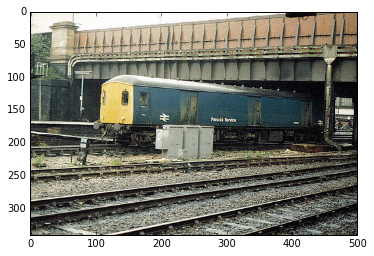

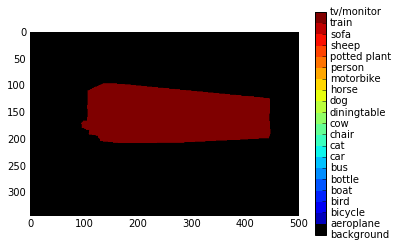

In [155]:
import matplotlib.pyplot as plt
for data, target in train_loader: break
print(data.shape)
print(target.shape)
data.min()
data_show, label_show = train_loader.dataset.untransform(data[0].cpu().clone(), target[0].cpu().clone())

plt.imshow(data_show)
plt.show()

def imshow_label(label_show):
    import matplotlib
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (0.0,0.0,0.0,1.0)
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = np.arange(0,len(train_loader.dataset.class_names))
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    plt.imshow(label_show, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=bounds)
    cbar.ax.set_yticklabels(train_loader.dataset.class_names)
    plt.show()    
    
imshow_label(label_show)


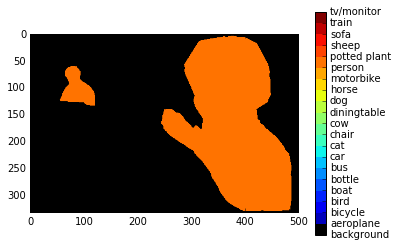

In [112]:
imshow_label(label_show)

## FCN - Model

In [156]:
import numpy as np
import torch.nn as nn

class FCN32s(nn.Module):

    def __init__(self, n_class=21):
        super(FCN32s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32,
                                          bias=False)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x, debug = False):
        h = x
        if debug: print(h.data.shape)
        h = self.relu1_1(self.conv1_1(h))
        if debug: print(h.data.shape)
        h = self.relu1_2(self.conv1_2(h))
        if debug: print(h.data.shape)
        h = self.pool1(h)
        if debug: print(h.data.shape)

        h = self.relu2_1(self.conv2_1(h))
        if debug: print(h.data.shape)
        h = self.relu2_2(self.conv2_2(h))
        if debug: print(h.data.shape)
        h = self.pool2(h)
        if debug: print(h.data.shape)

        h = self.relu3_1(self.conv3_1(h))
        if debug: print(h.data.shape)
        h = self.relu3_2(self.conv3_2(h))
        if debug: print(h.data.shape)
        h = self.relu3_3(self.conv3_3(h))
        if debug: print(h.data.shape)
        h = self.pool3(h)
        if debug: print(h.data.shape)

        h = self.relu4_1(self.conv4_1(h))
        if debug: print(h.data.shape)
        h = self.relu4_2(self.conv4_2(h))
        if debug: print(h.data.shape)
        h = self.relu4_3(self.conv4_3(h))
        if debug: print(h.data.shape)
        h = self.pool4(h)
        if debug: print(h.data.shape)

        h = self.relu5_1(self.conv5_1(h))
        if debug: print(h.data.shape)
        h = self.relu5_2(self.conv5_2(h))
        if debug: print(h.data.shape)
        h = self.relu5_3(self.conv5_3(h))
        if debug: print(h.data.shape)
        h = self.pool5(h)
        if debug: print(h.data.shape)

        h = self.relu6(self.fc6(h))
        if debug: print(h.data.shape)
        h = self.drop6(h)
        if debug: print(h.data.shape)

        h = self.relu7(self.fc7(h))
        if debug: print(h.data.shape)
        h = self.drop7(h)
        if debug: print(h.data.shape)

        h = self.score_fr(h)
        if debug: print(h.data.shape)

        h = self.upscore(h)
        if debug: print(h.data.shape)
        h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()
        if debug: print(h.data.shape)
            
        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())

In [116]:
# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

## From VGG16 weights

In [118]:
import torchvision
import fcn #PIP INSTALL

def VGG16(pretrained=False, folder='data/pretrained_models'):
    model = torchvision.models.vgg16(pretrained=False)
    if not pretrained:
        return model
    model_file = _get_vgg16_pretrained_model(folder)
    
    state_dict = torch.load(model_file)
    model.load_state_dict(state_dict)
    return model


def _get_vgg16_pretrained_model(folder):
    path_model = osp.join(os.getcwd(), folder, 'vgg16_from_caffe.pth')
    return fcn.data.cached_download(
                url='http://drive.google.com/uc?id=0B9P1L--7Wd2vLTJZMXpIRkVVRFk',
                path=path_model,
                md5='aa75b158f4181e7f6230029eb96c1b13',
            )
            

In [157]:
model = FCN32s(n_class=21)

In [120]:
model

FCN32s (
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU (inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU (inplace)
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU (inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU (inplace)
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU (inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU (inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU (inplace)
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv4_1): Conv2d(256, 512,

In [122]:
for data, target in train_loader: break
output = model(data)

TypeError: argument 0 is not a Variable

In [123]:
from torch.autograd import Variable
output = model(Variable(data, volatile=True))

In [129]:
print(output.data.shape)
print(data.shape)

torch.Size([1, 21, 333, 500])
torch.Size([1, 3, 333, 500])


In [158]:
for data, target in train_loader: break
output = model(Variable(data, volatile=True), debug=True)

torch.Size([1, 3, 375, 500])
torch.Size([1, 64, 573, 698])
torch.Size([1, 64, 573, 698])
torch.Size([1, 64, 287, 349])
torch.Size([1, 128, 287, 349])
torch.Size([1, 128, 287, 349])
torch.Size([1, 128, 144, 175])
torch.Size([1, 256, 144, 175])
torch.Size([1, 256, 144, 175])
torch.Size([1, 256, 144, 175])
torch.Size([1, 256, 72, 88])
torch.Size([1, 512, 72, 88])
torch.Size([1, 512, 72, 88])
torch.Size([1, 512, 72, 88])
torch.Size([1, 512, 36, 44])
torch.Size([1, 512, 36, 44])
torch.Size([1, 512, 36, 44])
torch.Size([1, 512, 36, 44])
torch.Size([1, 512, 18, 22])
torch.Size([1, 4096, 12, 16])
torch.Size([1, 4096, 12, 16])
torch.Size([1, 4096, 12, 16])
torch.Size([1, 4096, 12, 16])
torch.Size([1, 21, 12, 16])
torch.Size([1, 21, 416, 544])
torch.Size([1, 21, 375, 500])


In [159]:
for data, target in train_loader: break
output = model(Variable(data, volatile=True), debug=True)

torch.Size([1, 3, 500, 451])
torch.Size([1, 64, 698, 649])
torch.Size([1, 64, 698, 649])
torch.Size([1, 64, 349, 325])
torch.Size([1, 128, 349, 325])
torch.Size([1, 128, 349, 325])
torch.Size([1, 128, 175, 163])
torch.Size([1, 256, 175, 163])
torch.Size([1, 256, 175, 163])
torch.Size([1, 256, 175, 163])
torch.Size([1, 256, 88, 82])
torch.Size([1, 512, 88, 82])
torch.Size([1, 512, 88, 82])
torch.Size([1, 512, 88, 82])
torch.Size([1, 512, 44, 41])
torch.Size([1, 512, 44, 41])
torch.Size([1, 512, 44, 41])
torch.Size([1, 512, 44, 41])
torch.Size([1, 512, 22, 21])
torch.Size([1, 4096, 16, 15])
torch.Size([1, 4096, 16, 15])
torch.Size([1, 4096, 16, 15])
torch.Size([1, 4096, 16, 15])
torch.Size([1, 21, 16, 15])
torch.Size([1, 21, 544, 512])
torch.Size([1, 21, 500, 451])


In [160]:
for data, target in train_loader: break
output = model(Variable(data, volatile=True), debug=True)

torch.Size([1, 3, 333, 500])
torch.Size([1, 64, 531, 698])
torch.Size([1, 64, 531, 698])
torch.Size([1, 64, 266, 349])
torch.Size([1, 128, 266, 349])
torch.Size([1, 128, 266, 349])
torch.Size([1, 128, 133, 175])
torch.Size([1, 256, 133, 175])
torch.Size([1, 256, 133, 175])
torch.Size([1, 256, 133, 175])
torch.Size([1, 256, 67, 88])
torch.Size([1, 512, 67, 88])
torch.Size([1, 512, 67, 88])
torch.Size([1, 512, 67, 88])
torch.Size([1, 512, 34, 44])
torch.Size([1, 512, 34, 44])
torch.Size([1, 512, 34, 44])
torch.Size([1, 512, 34, 44])
torch.Size([1, 512, 17, 22])
torch.Size([1, 4096, 11, 16])
torch.Size([1, 4096, 11, 16])
torch.Size([1, 4096, 11, 16])
torch.Size([1, 4096, 11, 16])
torch.Size([1, 21, 11, 16])
torch.Size([1, 21, 384, 544])
torch.Size([1, 21, 333, 500])


In [161]:
if resume:
    print('Loading checkpoint from: '+resume)
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    vgg16 = VGG16(pretrained=True)
    model.copy_params_from_vgg16(vgg16)
    
if cuda:
    model = model.cuda()

[/home/afromero/datos2/Medellin/FCN/data/pretrained_models/vgg16_from_caffe.pth] Checking md5 (aa75b158f4181e7f6230029eb96c1b13)


## Optimizer

In [163]:
for idx, m in enumerate(model.modules()): print(str(idx)+' - '+ str(m)+'\n----')

0 - FCN32s (
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU (inplace)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU (inplace)
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU (inplace)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU (inplace)
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU (inplace)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU (inplace)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU (inplace)
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv4_1): Conv2d(256, 

In [162]:
def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        FCN32s,
    )
    for idx, m in enumerate(model.modules()):
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped) or idx==0:
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))

In [164]:
optim = torch.optim.SGD([
            {'params': get_parameters(model, bias=False)},
            {'params': get_parameters(model, bias=True), 'lr': cfg['lr'] * 2, 'weight_decay': 0},
                        ],
            lr=cfg['lr'],
            momentum=cfg['momentum'],
            weight_decay=cfg['weight_decay']
        )

In [132]:
if resume:
    optim.load_state_dict(checkpoint['optim_state_dict'])

## Loss

In [165]:
%matplotlib inline
import datetime
from distutils.version import LooseVersion
import math
import os
import os.path as osp
import shutil

import fcn
import numpy as np
import pytz
import scipy.misc
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import tqdm
import utils
import imageio

def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    if LooseVersion(torch.__version__) < LooseVersion('0.3'):
        # ==0.2.X
        log_p = F.log_softmax(input)
    else:
        # >=0.3
        log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, size_average=False)
    if size_average:
        loss /= mask.data.sum()
    return loss

In [190]:
class Trainer(object):

    def __init__(self, cuda, model, optimizer,
                 train_loader, val_loader, out, max_iter,
                 size_average=False, interval_validate=None):
        self.cuda = cuda

        self.model = model
        self.optim = optimizer

        self.train_loader = train_loader
        self.val_loader = val_loader

        self.timestamp_start = \
            datetime.datetime.now(pytz.timezone('America/Bogota'))
        self.size_average = size_average

        if interval_validate is None:
            self.interval_validate = len(self.train_loader)
        else:
            self.interval_validate = interval_validate

        self.out = out
        if not osp.exists(self.out):
            os.makedirs(self.out)

        self.log_headers = [
            'epoch',
            'iteration',
            'train/loss',
            'train/acc',
            'train/acc_cls',
            'train/mean_iu',
            'train/fwavacc',
            'valid/loss',
            'valid/acc',
            'valid/acc_cls',
            'valid/mean_iu',
            'valid/fwavacc',
            'elapsed_time',
        ]
        if not osp.exists(osp.join(self.out, 'log.csv')):
            with open(osp.join(self.out, 'log.csv'), 'w') as f:
                f.write(','.join(self.log_headers) + '\n')

        self.epoch = 0
        self.iteration = 0
        self.max_iter = max_iter
        self.best_mean_iu = 0

    def validate(self):
        training = self.model.training
        self.model.eval()

        n_class = len(self.val_loader.dataset.class_names)

        val_loss = 0
        visualizations = []
        label_trues, label_preds = [], []
        for batch_idx, (data, target) in tqdm.tqdm(
                enumerate(self.val_loader), total=len(self.val_loader),
                desc='Valid iteration=%d' % self.iteration, ncols=80,
                leave=False):
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            score = self.model(data)

            loss = cross_entropy2d(score, target,
                                   size_average=self.size_average)
            if np.isnan(float(loss.data[0])):
                raise ValueError('loss is nan while validating')
            val_loss += float(loss.data[0]) / len(data)

            imgs = data.data.cpu()
            lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
            lbl_true = target.data.cpu()
            for img, lt, lp in zip(imgs, lbl_true, lbl_pred):
                img, lt = self.val_loader.dataset.untransform(img, lt)
                label_trues.append(lt)
                label_preds.append(lp)
                if len(visualizations) < 9:
                    viz = fcn.utils.visualize_segmentation(
                        lbl_pred=lp, lbl_true=lt, img=img, n_class=n_class)
                    visualizations.append(viz)
        metrics = utils.label_accuracy_score(
            label_trues, label_preds, n_class)

        out = osp.join(self.out, 'visualization_viz')
        if not osp.exists(out):
            os.makedirs(out)
        out_file = osp.join(out, 'iter%012d.jpg' % self.iteration)
        img_ = fcn.utils.get_tile_image(visualizations)
        #scipy.misc.imsave(out_file, img_)
        imageio.imwrite(out_file, img_)
        plt.imshow(imageio.imread(out_file))
        plt.show()

        val_loss /= len(self.val_loader)

        with open(osp.join(self.out, 'log.csv'), 'a') as f:
            elapsed_time = (
                datetime.datetime.now(pytz.timezone('America/Bogota')) -
                self.timestamp_start).total_seconds()
            log = [self.epoch, self.iteration] + [''] * 5 + \
                  [val_loss] + list(metrics) + [elapsed_time]
            log = map(str, log)
            f.write(','.join(log) + '\n')

        mean_iu = metrics[2]
        is_best = mean_iu > self.best_mean_iu
        if is_best:
            self.best_mean_iu = mean_iu
        torch.save({
            'epoch': self.epoch,
            'iteration': self.iteration,
            'arch': self.model.__class__.__name__,
            'optim_state_dict': self.optim.state_dict(),
            'model_state_dict': self.model.state_dict(),
            'best_mean_iu': self.best_mean_iu,
        }, osp.join(self.out, 'checkpoint.pth.tar'))
        if is_best:
            shutil.copy(osp.join(self.out, 'checkpoint.pth.tar'),
                        osp.join(self.out, 'model_best.pth.tar'))

        if training:
            self.model.train()

    def train_epoch(self):
        self.model.train()

        n_class = len(self.train_loader.dataset.class_names)

        for batch_idx, (data, target) in tqdm.tqdm(
                enumerate(self.train_loader), total=len(self.train_loader),
                desc='Train epoch=%d' % self.epoch, ncols=80, leave=False):
            iteration = batch_idx + self.epoch * len(self.train_loader)
            if self.iteration != 0 and (iteration - 1) != self.iteration:
                continue  # for resuming
            self.iteration = iteration

            if self.iteration % self.interval_validate == 0:
                self.validate()

            assert self.model.training

            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            self.optim.zero_grad()
            score = self.model(data)

            loss = cross_entropy2d(score, target,
                                   size_average=self.size_average)
            loss /= len(data)
            if np.isnan(float(loss.data[0])):
                raise ValueError('loss is nan while training')
            loss.backward()
            self.optim.step()

            metrics = []
            lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
            lbl_true = target.data.cpu().numpy()
            acc, acc_cls, mean_iu, fwavacc = \
                utils.label_accuracy_score(
                    lbl_true, lbl_pred, n_class=n_class)
            metrics.append((acc, acc_cls, mean_iu, fwavacc))
            metrics = np.mean(metrics, axis=0)

            with open(osp.join(self.out, 'log.csv'), 'a') as f:
                elapsed_time = (
                    datetime.datetime.now(pytz.timezone('America/Bogota')) -
                    self.timestamp_start).total_seconds()
                log = [self.epoch, self.iteration] + [loss.data[0]] + \
                    metrics.tolist() + [''] * 5 + [elapsed_time]
                log = map(str, log)
                f.write(','.join(log) + '\n')

            if self.iteration >= self.max_iter:
                break

    def train(self):
        max_epoch = int(math.ceil(1. * self.max_iter / len(self.train_loader)))
        for epoch in tqdm.trange(self.epoch, max_epoch,
                                 desc='Train', ncols=80):
            self.epoch = epoch
            self.train_epoch()
            if self.iteration >= self.max_iter:
                break

In [174]:
model.train()
for data, target in train_loader: break
data, target = Variable(data), Variable(target)
if cuda:
    data, target = data.cuda(), target.cuda()

In [175]:
score = model(data)

loss = cross_entropy2d(score, target, size_average=False) / len(data)
print("Loss: "+str(loss.data.cpu().numpy()[0]))
if np.isnan(float(loss.data[0])):
    raise ValueError('loss is nan while training')

optim.zero_grad()
loss.backward()
optim.step()

Loss: Variable containing:
1.00000e+05 *
  4.9933
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [178]:
print("Loss: "+str(loss.data.cpu().numpy()[0]))

Loss: [499327.2]


In [179]:
#Again to see the optim update
score = model(data)
loss = cross_entropy2d(score, target, size_average=False) / len(data)
print("Loss: "+str(loss.data.cpu().numpy()[0]))

Loss: 492599.34


In [180]:
for i in tqdm.tqdm(range(10000000)): pass

100%|██████████| 10000000/10000000 [00:02<00:00, 4442997.21it/s]


In [191]:
trainer = Trainer(
        cuda=cuda,
        model=model,
        optimizer=optim,
        train_loader=train_loader,
        val_loader=val_loader,
        out=out,
        max_iter=cfg['max_iteration'],
        interval_validate=cfg.get('interval_validate', len(train_loader)),
        )

In [183]:
print(cfg.get('interval_validate', len(train_loader))) #Validate every 4000 iterations
print(out)

4000
logs/MODEL-fcn32s_CFG-001_WEIGHT_DECAY-0.0005_LR-1e-10_INTERVAL_VALIDATE-4000_MOMENTUM-0.99_MAX_ITERATION-100000_TIME-20180219-095417


In [184]:
start_epoch = 0
start_iteration = 0
if resume:
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']





Train:   0%|                                             | 0/12 [00:00<?, ?it/s]




Train epoch=0:   0%|                                   | 0/8498 [00:00<?, ?it/s]





Valid iteration=0:   0%|                                | 0/736 [00:00<?, ?it/s]





Valid iteration=0:   0%|                        | 1/736 [00:00<06:49,  1.80it/s]





Valid iteration=0:   0%|                        | 2/736 [00:01<06:27,  1.90it/s]





Valid iteration=0:   0%|                        | 3/736 [00:01<05:52,  2.08it/s]





Valid iteration=0:   1%|▏                       | 4/736 [00:01<05:39,  2.16it/s]





Valid iteration=0:   1%|▏                       | 5/736 [00:02<05:14,  2.32it/s]





Valid iteration=0:   1%|▏                       | 6/736 [00:02<04:57,  2.46it/s]





Valid iteration=0:   1%|▏                       | 7/736 [00:02<04:42,  2.58it/s]





Valid iteration=0:   1%|▎                       | 8/736 [00:03<04:28,  2.71it/s]





Valid iteration=0:   1%|▎                       | 9

Valid iteration=0:  20%|████▍                 | 147/736 [00:11<00:32, 18.14it/s]





Valid iteration=0:  20%|████▍                 | 150/736 [00:11<00:31, 18.83it/s]





Valid iteration=0:  21%|████▌                 | 152/736 [00:11<00:31, 18.49it/s]





Valid iteration=0:  21%|████▌                 | 154/736 [00:11<00:31, 18.42it/s]





Valid iteration=0:  21%|████▋                 | 156/736 [00:11<00:31, 18.16it/s]





Valid iteration=0:  21%|████▋                 | 158/736 [00:11<00:31, 18.10it/s]





Valid iteration=0:  22%|████▊                 | 160/736 [00:11<00:32, 17.95it/s]





Valid iteration=0:  22%|████▊                 | 162/736 [00:11<00:32, 17.75it/s]





Valid iteration=0:  22%|████▉                 | 164/736 [00:11<00:32, 17.87it/s]





Valid iteration=0:  23%|████▉                 | 166/736 [00:12<00:31, 18.08it/s]





Valid iteration=0:  23%|█████                 | 169/736 [00:12<00:30, 18.37it/s]





Valid iteration=0:  23%|█████                 | 171/73

Valid iteration=0:  42%|█████████▎            | 310/736 [00:19<00:23, 18.10it/s]





Valid iteration=0:  42%|█████████▎            | 312/736 [00:20<00:23, 18.30it/s]





Valid iteration=0:  43%|█████████▍            | 314/736 [00:20<00:23, 18.15it/s]





Valid iteration=0:  43%|█████████▍            | 316/736 [00:20<00:23, 17.91it/s]





Valid iteration=0:  43%|█████████▌            | 318/736 [00:20<00:23, 17.82it/s]





Valid iteration=0:  43%|█████████▌            | 320/736 [00:20<00:22, 18.12it/s]





Valid iteration=0:  44%|█████████▋            | 322/736 [00:20<00:23, 17.86it/s]





Valid iteration=0:  44%|█████████▋            | 324/736 [00:20<00:23, 17.84it/s]





Valid iteration=0:  44%|█████████▋            | 326/736 [00:20<00:22, 17.84it/s]





Valid iteration=0:  45%|█████████▊            | 328/736 [00:20<00:22, 17.98it/s]





Valid iteration=0:  45%|█████████▊            | 330/736 [00:21<00:22, 18.45it/s]





Valid iteration=0:  45%|█████████▉            | 332/73

Valid iteration=0:  64%|██████████████        | 471/736 [00:28<00:14, 17.98it/s]





Valid iteration=0:  64%|██████████████▏       | 473/736 [00:29<00:14, 18.12it/s]





Valid iteration=0:  65%|██████████████▏       | 475/736 [00:29<00:14, 17.95it/s]





Valid iteration=0:  65%|██████████████▎       | 477/736 [00:29<00:14, 17.86it/s]





Valid iteration=0:  65%|██████████████▎       | 479/736 [00:29<00:14, 17.47it/s]





Valid iteration=0:  65%|██████████████▍       | 481/736 [00:29<00:14, 17.47it/s]





Valid iteration=0:  66%|██████████████▍       | 483/736 [00:29<00:14, 17.75it/s]





Valid iteration=0:  66%|██████████████▍       | 485/736 [00:29<00:14, 17.65it/s]





Valid iteration=0:  66%|██████████████▌       | 487/736 [00:29<00:13, 17.90it/s]





Valid iteration=0:  66%|██████████████▌       | 489/736 [00:29<00:13, 18.44it/s]





Valid iteration=0:  67%|██████████████▋       | 491/736 [00:30<00:13, 18.40it/s]





Valid iteration=0:  67%|██████████████▋       | 493/73

Valid iteration=0:  86%|██████████████████▊   | 631/736 [00:37<00:06, 17.09it/s]





Valid iteration=0:  86%|██████████████████▉   | 633/736 [00:38<00:05, 17.29it/s]





Valid iteration=0:  86%|██████████████████▉   | 635/736 [00:38<00:05, 17.45it/s]





Valid iteration=0:  87%|███████████████████   | 637/736 [00:38<00:05, 18.08it/s]





Valid iteration=0:  87%|███████████████████   | 639/736 [00:38<00:05, 18.31it/s]





Valid iteration=0:  87%|███████████████████▏  | 641/736 [00:38<00:05, 18.19it/s]





Valid iteration=0:  87%|███████████████████▏  | 643/736 [00:38<00:04, 18.64it/s]





Valid iteration=0:  88%|███████████████████▎  | 645/736 [00:38<00:04, 18.31it/s]





Valid iteration=0:  88%|███████████████████▎  | 648/736 [00:38<00:04, 19.10it/s]





Valid iteration=0:  88%|███████████████████▍  | 650/736 [00:38<00:04, 18.89it/s]





Valid iteration=0:  89%|███████████████████▍  | 652/736 [00:39<00:04, 18.86it/s]





Valid iteration=0:  89%|███████████████████▌  | 654/73

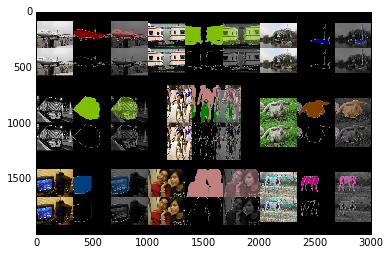

utils.py:24: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
utils.py:26: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))





Train epoch=0:   0%|                       | 1/8498 [00:49<117:03:32, 49.60s/it]




Train epoch=0:   0%|                        | 2/8498 [00:49<82:03:22, 34.77s/it]




Train epoch=0:   0%|                        | 3/8498 [00:49<57:33:28, 24.39s/it]




Train epoch=0:   0%|                        | 4/8498 [00:50<40:24:55, 17.13s/it]




Train epoch=0:   0%|                        | 5/8498 [00:50<28:24:54, 12.04s/it]




Train epoch=0:   0%|                        | 6/8498 [00:50<19:59:50,  8.48s/it]




Train epoch=0:   0%|                        | 7/8498 [00:50<14:07:27,  5.99s/it]




Train epoch=0:   0%|                        | 8/8498 [00:50<10:00:48,  4.25s/it]




Train epoch=0:   0%|                         | 9/8498 [00:51<7:

Train epoch=0:   1%|▏                         | 80/8498 [01:03<25:37,  5.48it/s]




Train epoch=0:   1%|▏                         | 81/8498 [01:04<26:44,  5.24it/s]




Train epoch=0:   1%|▎                         | 82/8498 [01:04<26:16,  5.34it/s]




Train epoch=0:   1%|▎                         | 83/8498 [01:04<25:50,  5.43it/s]




Train epoch=0:   1%|▎                         | 84/8498 [01:04<25:38,  5.47it/s]




Train epoch=0:   1%|▎                         | 85/8498 [01:04<25:42,  5.46it/s]




Train epoch=0:   1%|▎                         | 86/8498 [01:04<25:27,  5.51it/s]




Train epoch=0:   1%|▎                         | 87/8498 [01:05<25:45,  5.44it/s]




Train epoch=0:   1%|▎                         | 88/8498 [01:05<25:24,  5.52it/s]




Train epoch=0:   1%|▎                         | 89/8498 [01:05<24:36,  5.70it/s]




Train epoch=0:   1%|▎                         | 90/8498 [01:05<23:40,  5.92it/s]




Train epoch=0:   1%|▎                         | 91/8498 [01:05<24

Train epoch=0:   2%|▍                        | 161/8498 [01:18<25:04,  5.54it/s]




Train epoch=0:   2%|▍                        | 162/8498 [01:18<24:10,  5.75it/s]




Train epoch=0:   2%|▍                        | 163/8498 [01:18<25:01,  5.55it/s]




Train epoch=0:   2%|▍                        | 164/8498 [01:18<25:26,  5.46it/s]




Train epoch=0:   2%|▍                        | 165/8498 [01:19<26:06,  5.32it/s]




Train epoch=0:   2%|▍                        | 166/8498 [01:19<26:16,  5.28it/s]




Train epoch=0:   2%|▍                        | 167/8498 [01:19<26:13,  5.29it/s]




Train epoch=0:   2%|▍                        | 168/8498 [01:19<26:15,  5.29it/s]




Train epoch=0:   2%|▍                        | 169/8498 [01:19<25:46,  5.39it/s]




Train epoch=0:   2%|▌                        | 170/8498 [01:20<26:40,  5.20it/s]




Train epoch=0:   2%|▌                        | 171/8498 [01:20<26:07,  5.31it/s]




Train epoch=0:   2%|▌                        | 172/8498 [01:20<26

Train epoch=0:   3%|▋                        | 242/8498 [01:33<25:47,  5.34it/s]




Train epoch=0:   3%|▋                        | 243/8498 [01:33<25:36,  5.37it/s]




Train epoch=0:   3%|▋                        | 244/8498 [01:34<26:22,  5.22it/s]




Train epoch=0:   3%|▋                        | 245/8498 [01:34<26:01,  5.29it/s]




Train epoch=0:   3%|▋                        | 246/8498 [01:34<25:48,  5.33it/s]




Train epoch=0:   3%|▋                        | 247/8498 [01:34<24:18,  5.66it/s]




Train epoch=0:   3%|▋                        | 248/8498 [01:34<24:19,  5.65it/s]




Train epoch=0:   3%|▋                        | 249/8498 [01:34<24:11,  5.68it/s]




Train epoch=0:   3%|▋                        | 250/8498 [01:35<24:40,  5.57it/s]




Train epoch=0:   3%|▋                        | 251/8498 [01:35<24:50,  5.53it/s]




Train epoch=0:   3%|▋                        | 252/8498 [01:35<24:59,  5.50it/s]




Train epoch=0:   3%|▋                        | 253/8498 [01:35<24

Train epoch=0:   4%|▉                        | 323/8498 [01:48<24:09,  5.64it/s]




Train epoch=0:   4%|▉                        | 324/8498 [01:49<23:59,  5.68it/s]




Train epoch=0:   4%|▉                        | 325/8498 [01:49<24:19,  5.60it/s]




Train epoch=0:   4%|▉                        | 326/8498 [01:49<25:22,  5.37it/s]




Train epoch=0:   4%|▉                        | 327/8498 [01:49<25:58,  5.24it/s]




Train epoch=0:   4%|▉                        | 328/8498 [01:49<26:24,  5.16it/s]




Train epoch=0:   4%|▉                        | 329/8498 [01:50<26:34,  5.12it/s]




Train epoch=0:   4%|▉                        | 330/8498 [01:50<26:58,  5.05it/s]




Train epoch=0:   4%|▉                        | 331/8498 [01:50<26:49,  5.08it/s]




Train epoch=0:   4%|▉                        | 332/8498 [01:50<26:22,  5.16it/s]




Train epoch=0:   4%|▉                        | 333/8498 [01:50<26:10,  5.20it/s]




Train epoch=0:   4%|▉                        | 334/8498 [01:51<25

Train epoch=0:   5%|█▏                       | 404/8498 [02:04<24:42,  5.46it/s]




Train epoch=0:   5%|█▏                       | 405/8498 [02:04<25:41,  5.25it/s]




Train epoch=0:   5%|█▏                       | 406/8498 [02:04<25:26,  5.30it/s]




Train epoch=0:   5%|█▏                       | 407/8498 [02:05<25:17,  5.33it/s]




Train epoch=0:   5%|█▏                       | 408/8498 [02:05<24:50,  5.43it/s]




Train epoch=0:   5%|█▏                       | 409/8498 [02:05<24:55,  5.41it/s]




Train epoch=0:   5%|█▏                       | 410/8498 [02:05<24:46,  5.44it/s]




Train epoch=0:   5%|█▏                       | 411/8498 [02:05<24:48,  5.43it/s]




Train epoch=0:   5%|█▏                       | 412/8498 [02:05<25:04,  5.38it/s]




Train epoch=0:   5%|█▏                       | 413/8498 [02:06<24:39,  5.46it/s]




Train epoch=0:   5%|█▏                       | 414/8498 [02:06<24:37,  5.47it/s]




Train epoch=0:   5%|█▏                       | 415/8498 [02:06<24

Train epoch=0:   6%|█▍                       | 485/8498 [02:19<24:58,  5.35it/s]




Train epoch=0:   6%|█▍                       | 486/8498 [02:19<25:30,  5.23it/s]




Train epoch=0:   6%|█▍                       | 487/8498 [02:19<25:21,  5.26it/s]




Train epoch=0:   6%|█▍                       | 488/8498 [02:20<25:08,  5.31it/s]




Train epoch=0:   6%|█▍                       | 489/8498 [02:20<24:54,  5.36it/s]




Train epoch=0:   6%|█▍                       | 490/8498 [02:20<24:22,  5.48it/s]




Train epoch=0:   6%|█▍                       | 491/8498 [02:20<24:28,  5.45it/s]




Train epoch=0:   6%|█▍                       | 492/8498 [02:20<24:31,  5.44it/s]




Train epoch=0:   6%|█▍                       | 493/8498 [02:21<24:41,  5.40it/s]




Train epoch=0:   6%|█▍                       | 494/8498 [02:21<24:51,  5.37it/s]




Train epoch=0:   6%|█▍                       | 495/8498 [02:21<25:12,  5.29it/s]




Train epoch=0:   6%|█▍                       | 496/8498 [02:21<25

Train epoch=0:   7%|█▋                       | 566/8498 [02:34<23:58,  5.51it/s]




Train epoch=0:   7%|█▋                       | 567/8498 [02:34<24:12,  5.46it/s]




Train epoch=0:   7%|█▋                       | 568/8498 [02:35<24:04,  5.49it/s]




Train epoch=0:   7%|█▋                       | 569/8498 [02:35<24:19,  5.43it/s]




Train epoch=0:   7%|█▋                       | 570/8498 [02:35<23:09,  5.71it/s]




Train epoch=0:   7%|█▋                       | 571/8498 [02:35<23:40,  5.58it/s]




Train epoch=0:   7%|█▋                       | 572/8498 [02:35<23:54,  5.52it/s]




Train epoch=0:   7%|█▋                       | 573/8498 [02:35<24:05,  5.48it/s]




Train epoch=0:   7%|█▋                       | 574/8498 [02:36<24:14,  5.45it/s]




Train epoch=0:   7%|█▋                       | 575/8498 [02:36<24:23,  5.41it/s]




Train epoch=0:   7%|█▋                       | 576/8498 [02:36<24:25,  5.40it/s]




Train epoch=0:   7%|█▋                       | 577/8498 [02:36<24

Train epoch=0:   8%|█▉                       | 648/8498 [02:49<26:07,  5.01it/s]




Train epoch=0:   8%|█▉                       | 649/8498 [02:50<26:16,  4.98it/s]




Train epoch=0:   8%|█▉                       | 650/8498 [02:50<25:56,  5.04it/s]




Train epoch=0:   8%|█▉                       | 651/8498 [02:50<26:04,  5.02it/s]




Train epoch=0:   8%|█▉                       | 652/8498 [02:50<25:49,  5.06it/s]




Train epoch=0:   8%|█▉                       | 653/8498 [02:50<26:20,  4.96it/s]




Train epoch=0:   8%|█▉                       | 654/8498 [02:51<26:15,  4.98it/s]




Train epoch=0:   8%|█▉                       | 655/8498 [02:51<26:23,  4.95it/s]




Train epoch=0:   8%|█▉                       | 656/8498 [02:51<26:23,  4.95it/s]




Train epoch=0:   8%|█▉                       | 657/8498 [02:51<26:13,  4.98it/s]




Train epoch=0:   8%|█▉                       | 658/8498 [02:51<26:07,  5.00it/s]




Train epoch=0:   8%|█▉                       | 659/8498 [02:52<25

Train epoch=0:   9%|██▏                      | 729/8498 [03:04<24:46,  5.23it/s]




Train epoch=0:   9%|██▏                      | 730/8498 [03:05<24:26,  5.30it/s]




Train epoch=0:   9%|██▏                      | 731/8498 [03:05<23:58,  5.40it/s]




Train epoch=0:   9%|██▏                      | 732/8498 [03:05<25:28,  5.08it/s]




Train epoch=0:   9%|██▏                      | 733/8498 [03:05<24:23,  5.31it/s]




Train epoch=0:   9%|██▏                      | 734/8498 [03:05<22:39,  5.71it/s]




Train epoch=0:   9%|██▏                      | 735/8498 [03:05<23:29,  5.51it/s]




Train epoch=0:   9%|██▏                      | 736/8498 [03:06<23:37,  5.48it/s]




Train epoch=0:   9%|██▏                      | 737/8498 [03:06<23:25,  5.52it/s]




Train epoch=0:   9%|██▏                      | 738/8498 [03:06<23:13,  5.57it/s]




Train epoch=0:   9%|██▏                      | 739/8498 [03:06<23:12,  5.57it/s]




Train epoch=0:   9%|██▏                      | 740/8498 [03:06<23

Train epoch=0:  10%|██▍                      | 810/8498 [03:20<23:47,  5.38it/s]




Train epoch=0:  10%|██▍                      | 811/8498 [03:20<23:48,  5.38it/s]




Train epoch=0:  10%|██▍                      | 812/8498 [03:20<23:46,  5.39it/s]




Train epoch=0:  10%|██▍                      | 813/8498 [03:20<23:26,  5.47it/s]




Train epoch=0:  10%|██▍                      | 814/8498 [03:20<24:03,  5.32it/s]




Train epoch=0:  10%|██▍                      | 815/8498 [03:21<24:29,  5.23it/s]




Train epoch=0:  10%|██▍                      | 816/8498 [03:21<24:32,  5.22it/s]




Train epoch=0:  10%|██▍                      | 817/8498 [03:21<24:59,  5.12it/s]




Train epoch=0:  10%|██▍                      | 818/8498 [03:21<23:17,  5.49it/s]




Train epoch=0:  10%|██▍                      | 819/8498 [03:21<24:00,  5.33it/s]




Train epoch=0:  10%|██▍                      | 820/8498 [03:22<24:11,  5.29it/s]




Train epoch=0:  10%|██▍                      | 821/8498 [03:22<23

Train epoch=0:  10%|██▌                      | 892/8498 [03:35<25:07,  5.04it/s]




Train epoch=0:  11%|██▋                      | 893/8498 [03:35<24:44,  5.12it/s]




Train epoch=0:  11%|██▋                      | 894/8498 [03:35<24:41,  5.13it/s]




Train epoch=0:  11%|██▋                      | 895/8498 [03:36<24:28,  5.18it/s]




Train epoch=0:  11%|██▋                      | 896/8498 [03:36<24:05,  5.26it/s]




Train epoch=0:  11%|██▋                      | 897/8498 [03:36<23:48,  5.32it/s]




Train epoch=0:  11%|██▋                      | 898/8498 [03:36<23:42,  5.34it/s]




Train epoch=0:  11%|██▋                      | 899/8498 [03:36<23:40,  5.35it/s]




Train epoch=0:  11%|██▋                      | 900/8498 [03:37<24:05,  5.25it/s]




Train epoch=0:  11%|██▋                      | 901/8498 [03:37<23:42,  5.34it/s]




Train epoch=0:  11%|██▋                      | 902/8498 [03:37<21:48,  5.80it/s]




Train epoch=0:  11%|██▋                      | 903/8498 [03:37<22

Train epoch=0:  11%|██▊                      | 974/8498 [03:50<20:32,  6.10it/s]




Train epoch=0:  11%|██▊                      | 975/8498 [03:50<21:23,  5.86it/s]




Train epoch=0:  11%|██▊                      | 976/8498 [03:50<22:10,  5.66it/s]




Train epoch=0:  11%|██▊                      | 977/8498 [03:51<23:09,  5.41it/s]




Train epoch=0:  12%|██▉                      | 978/8498 [03:51<23:47,  5.27it/s]




Train epoch=0:  12%|██▉                      | 979/8498 [03:51<23:59,  5.22it/s]




Train epoch=0:  12%|██▉                      | 980/8498 [03:51<23:43,  5.28it/s]




Train epoch=0:  12%|██▉                      | 981/8498 [03:51<23:32,  5.32it/s]




Train epoch=0:  12%|██▉                      | 982/8498 [03:52<23:26,  5.34it/s]




Train epoch=0:  12%|██▉                      | 983/8498 [03:52<23:15,  5.39it/s]




Train epoch=0:  12%|██▉                      | 984/8498 [03:52<23:08,  5.41it/s]




Train epoch=0:  12%|██▉                      | 985/8498 [03:52<23

Train epoch=0:  12%|██▉                     | 1055/8498 [04:06<22:45,  5.45it/s]




Train epoch=0:  12%|██▉                     | 1056/8498 [04:06<23:40,  5.24it/s]




Train epoch=0:  12%|██▉                     | 1057/8498 [04:06<22:45,  5.45it/s]




Train epoch=0:  12%|██▉                     | 1058/8498 [04:06<22:23,  5.54it/s]




Train epoch=0:  12%|██▉                     | 1059/8498 [04:06<22:36,  5.48it/s]




Train epoch=0:  12%|██▉                     | 1060/8498 [04:06<22:53,  5.41it/s]




Train epoch=0:  12%|██▉                     | 1061/8498 [04:07<22:05,  5.61it/s]




Train epoch=0:  12%|██▉                     | 1062/8498 [04:07<22:21,  5.54it/s]




Train epoch=0:  13%|███                     | 1063/8498 [04:07<23:09,  5.35it/s]




Train epoch=0:  13%|███                     | 1064/8498 [04:07<20:07,  6.16it/s]




Train epoch=0:  13%|███                     | 1065/8498 [04:07<21:27,  5.77it/s]




Train epoch=0:  13%|███                     | 1066/8498 [04:08<22

Train epoch=0:  13%|███▏                    | 1136/8498 [04:21<22:02,  5.57it/s]




Train epoch=0:  13%|███▏                    | 1137/8498 [04:21<22:28,  5.46it/s]




Train epoch=0:  13%|███▏                    | 1138/8498 [04:21<22:37,  5.42it/s]




Train epoch=0:  13%|███▏                    | 1139/8498 [04:21<22:41,  5.40it/s]




Train epoch=0:  13%|███▏                    | 1140/8498 [04:22<22:48,  5.38it/s]




Train epoch=0:  13%|███▏                    | 1141/8498 [04:22<22:51,  5.36it/s]




Train epoch=0:  13%|███▏                    | 1142/8498 [04:22<22:46,  5.38it/s]




Train epoch=0:  13%|███▏                    | 1143/8498 [04:22<22:14,  5.51it/s]




Train epoch=0:  13%|███▏                    | 1144/8498 [04:22<23:04,  5.31it/s]




Train epoch=0:  13%|███▏                    | 1145/8498 [04:23<23:25,  5.23it/s]




Train epoch=0:  13%|███▏                    | 1146/8498 [04:23<23:32,  5.20it/s]




Train epoch=0:  13%|███▏                    | 1147/8498 [04:23<23

Train epoch=0:  14%|███▍                    | 1217/8498 [04:36<24:08,  5.03it/s]




Train epoch=0:  14%|███▍                    | 1218/8498 [04:36<23:54,  5.07it/s]




Train epoch=0:  14%|███▍                    | 1219/8498 [04:36<23:46,  5.10it/s]




Train epoch=0:  14%|███▍                    | 1220/8498 [04:37<23:26,  5.17it/s]




Train epoch=0:  14%|███▍                    | 1221/8498 [04:37<22:48,  5.32it/s]




Train epoch=0:  14%|███▍                    | 1222/8498 [04:37<22:20,  5.43it/s]




Train epoch=0:  14%|███▍                    | 1223/8498 [04:37<22:02,  5.50it/s]




Train epoch=0:  14%|███▍                    | 1224/8498 [04:37<21:52,  5.54it/s]




Train epoch=0:  14%|███▍                    | 1225/8498 [04:38<22:56,  5.28it/s]




Train epoch=0:  14%|███▍                    | 1226/8498 [04:38<23:24,  5.18it/s]




Train epoch=0:  14%|███▍                    | 1227/8498 [04:38<23:47,  5.09it/s]




Train epoch=0:  14%|███▍                    | 1228/8498 [04:38<23

Train epoch=0:  15%|███▋                    | 1298/8498 [04:51<22:16,  5.39it/s]




Train epoch=0:  15%|███▋                    | 1299/8498 [04:51<22:19,  5.37it/s]




Train epoch=0:  15%|███▋                    | 1300/8498 [04:51<22:16,  5.39it/s]




Train epoch=0:  15%|███▋                    | 1301/8498 [04:52<21:52,  5.48it/s]




Train epoch=0:  15%|███▋                    | 1302/8498 [04:52<22:22,  5.36it/s]




Train epoch=0:  15%|███▋                    | 1303/8498 [04:52<22:32,  5.32it/s]




Train epoch=0:  15%|███▋                    | 1304/8498 [04:52<22:46,  5.27it/s]




Train epoch=0:  15%|███▋                    | 1305/8498 [04:52<24:06,  4.97it/s]




Train epoch=0:  15%|███▋                    | 1306/8498 [04:53<24:14,  4.95it/s]




Train epoch=0:  15%|███▋                    | 1307/8498 [04:53<24:11,  4.95it/s]




Train epoch=0:  15%|███▋                    | 1308/8498 [04:53<23:43,  5.05it/s]




Train epoch=0:  15%|███▋                    | 1309/8498 [04:53<21

Train epoch=0:  16%|███▉                    | 1379/8498 [05:06<22:25,  5.29it/s]




Train epoch=0:  16%|███▉                    | 1380/8498 [05:07<22:36,  5.25it/s]




Train epoch=0:  16%|███▉                    | 1381/8498 [05:07<22:42,  5.22it/s]




Train epoch=0:  16%|███▉                    | 1382/8498 [05:07<23:01,  5.15it/s]




Train epoch=0:  16%|███▉                    | 1383/8498 [05:07<23:18,  5.09it/s]




Train epoch=0:  16%|███▉                    | 1384/8498 [05:07<23:27,  5.05it/s]




Train epoch=0:  16%|███▉                    | 1385/8498 [05:08<24:05,  4.92it/s]




Train epoch=0:  16%|███▉                    | 1386/8498 [05:08<24:44,  4.79it/s]




Train epoch=0:  16%|███▉                    | 1387/8498 [05:08<24:18,  4.88it/s]




Train epoch=0:  16%|███▉                    | 1388/8498 [05:08<23:44,  4.99it/s]




Train epoch=0:  16%|███▉                    | 1389/8498 [05:08<23:22,  5.07it/s]




Train epoch=0:  16%|███▉                    | 1390/8498 [05:09<22

Train epoch=0:  17%|████                    | 1460/8498 [05:22<21:28,  5.46it/s]




Train epoch=0:  17%|████▏                   | 1461/8498 [05:22<21:29,  5.46it/s]




Train epoch=0:  17%|████▏                   | 1462/8498 [05:22<21:29,  5.45it/s]




Train epoch=0:  17%|████▏                   | 1463/8498 [05:22<20:46,  5.64it/s]




Train epoch=0:  17%|████▏                   | 1464/8498 [05:22<21:04,  5.56it/s]




Train epoch=0:  17%|████▏                   | 1465/8498 [05:23<21:19,  5.50it/s]




Train epoch=0:  17%|████▏                   | 1466/8498 [05:23<21:30,  5.45it/s]




Train epoch=0:  17%|████▏                   | 1467/8498 [05:23<19:45,  5.93it/s]




Train epoch=0:  17%|████▏                   | 1468/8498 [05:23<20:27,  5.73it/s]




Train epoch=0:  17%|████▏                   | 1469/8498 [05:23<18:34,  6.31it/s]




Train epoch=0:  17%|████▏                   | 1470/8498 [05:23<19:31,  6.00it/s]




Train epoch=0:  17%|████▏                   | 1471/8498 [05:24<20

Train epoch=0:  18%|████▎                   | 1541/8498 [05:37<22:17,  5.20it/s]




Train epoch=0:  18%|████▎                   | 1542/8498 [05:37<22:14,  5.21it/s]




Train epoch=0:  18%|████▎                   | 1543/8498 [05:37<21:40,  5.35it/s]




Train epoch=0:  18%|████▎                   | 1544/8498 [05:37<21:42,  5.34it/s]




Train epoch=0:  18%|████▎                   | 1545/8498 [05:38<21:50,  5.31it/s]




Train epoch=0:  18%|████▎                   | 1546/8498 [05:38<22:17,  5.20it/s]




Train epoch=0:  18%|████▎                   | 1547/8498 [05:38<22:36,  5.12it/s]




Train epoch=0:  18%|████▎                   | 1548/8498 [05:38<22:22,  5.18it/s]




Train epoch=0:  18%|████▎                   | 1549/8498 [05:38<22:25,  5.16it/s]




Train epoch=0:  18%|████▍                   | 1550/8498 [05:39<22:12,  5.21it/s]




Train epoch=0:  18%|████▍                   | 1551/8498 [05:39<22:23,  5.17it/s]




Train epoch=0:  18%|████▍                   | 1552/8498 [05:39<22

Train epoch=0:  19%|████▌                   | 1622/8498 [05:52<21:41,  5.28it/s]




Train epoch=0:  19%|████▌                   | 1623/8498 [05:52<20:34,  5.57it/s]




Train epoch=0:  19%|████▌                   | 1624/8498 [05:53<21:14,  5.39it/s]




Train epoch=0:  19%|████▌                   | 1625/8498 [05:53<21:22,  5.36it/s]




Train epoch=0:  19%|████▌                   | 1626/8498 [05:53<21:46,  5.26it/s]




Train epoch=0:  19%|████▌                   | 1627/8498 [05:53<22:09,  5.17it/s]




Train epoch=0:  19%|████▌                   | 1628/8498 [05:53<22:26,  5.10it/s]




Train epoch=0:  19%|████▌                   | 1629/8498 [05:54<22:38,  5.06it/s]




Train epoch=0:  19%|████▌                   | 1630/8498 [05:54<22:33,  5.07it/s]




Train epoch=0:  19%|████▌                   | 1631/8498 [05:54<22:21,  5.12it/s]




Train epoch=0:  19%|████▌                   | 1632/8498 [05:54<22:09,  5.17it/s]




Train epoch=0:  19%|████▌                   | 1633/8498 [05:54<21

Train epoch=0:  20%|████▊                   | 1703/8498 [06:08<21:15,  5.33it/s]




Train epoch=0:  20%|████▊                   | 1704/8498 [06:08<21:21,  5.30it/s]




Train epoch=0:  20%|████▊                   | 1705/8498 [06:08<21:24,  5.29it/s]




Train epoch=0:  20%|████▊                   | 1706/8498 [06:08<21:33,  5.25it/s]




Train epoch=0:  20%|████▊                   | 1707/8498 [06:08<21:38,  5.23it/s]




Train epoch=0:  20%|████▊                   | 1708/8498 [06:09<21:42,  5.21it/s]




Train epoch=0:  20%|████▊                   | 1709/8498 [06:09<21:12,  5.34it/s]




Train epoch=0:  20%|████▊                   | 1710/8498 [06:09<21:03,  5.37it/s]




Train epoch=0:  20%|████▊                   | 1711/8498 [06:09<21:03,  5.37it/s]




Train epoch=0:  20%|████▊                   | 1712/8498 [06:09<20:57,  5.39it/s]




Train epoch=0:  20%|████▊                   | 1713/8498 [06:09<20:38,  5.48it/s]




Train epoch=0:  20%|████▊                   | 1714/8498 [06:10<21

Train epoch=0:  21%|█████                   | 1784/8498 [06:23<20:40,  5.41it/s]




Train epoch=0:  21%|█████                   | 1785/8498 [06:23<20:25,  5.48it/s]




Train epoch=0:  21%|█████                   | 1786/8498 [06:23<20:56,  5.34it/s]




Train epoch=0:  21%|█████                   | 1787/8498 [06:23<21:26,  5.22it/s]




Train epoch=0:  21%|█████                   | 1788/8498 [06:24<21:47,  5.13it/s]




Train epoch=0:  21%|█████                   | 1789/8498 [06:24<22:01,  5.08it/s]




Train epoch=0:  21%|█████                   | 1790/8498 [06:24<22:04,  5.07it/s]




Train epoch=0:  21%|█████                   | 1791/8498 [06:24<21:53,  5.11it/s]




Train epoch=0:  21%|█████                   | 1792/8498 [06:24<21:46,  5.13it/s]




Train epoch=0:  21%|█████                   | 1793/8498 [06:25<21:27,  5.21it/s]




Train epoch=0:  21%|█████                   | 1794/8498 [06:25<21:39,  5.16it/s]




Train epoch=0:  21%|█████                   | 1795/8498 [06:25<20

Train epoch=0:  22%|█████▎                  | 1865/8498 [06:38<21:23,  5.17it/s]




Train epoch=0:  22%|█████▎                  | 1866/8498 [06:38<21:42,  5.09it/s]




Train epoch=0:  22%|█████▎                  | 1867/8498 [06:38<21:41,  5.09it/s]




Train epoch=0:  22%|█████▎                  | 1868/8498 [06:39<21:50,  5.06it/s]




Train epoch=0:  22%|█████▎                  | 1869/8498 [06:39<21:38,  5.11it/s]




Train epoch=0:  22%|█████▎                  | 1870/8498 [06:39<21:21,  5.17it/s]




Train epoch=0:  22%|█████▎                  | 1871/8498 [06:39<21:28,  5.14it/s]




Train epoch=0:  22%|█████▎                  | 1872/8498 [06:39<20:23,  5.41it/s]




Train epoch=0:  22%|█████▎                  | 1873/8498 [06:39<20:21,  5.42it/s]




Train epoch=0:  22%|█████▎                  | 1874/8498 [06:40<20:11,  5.47it/s]




Train epoch=0:  22%|█████▎                  | 1875/8498 [06:40<20:14,  5.45it/s]




Train epoch=0:  22%|█████▎                  | 1876/8498 [06:40<20

Train epoch=0:  23%|█████▍                  | 1946/8498 [06:53<20:33,  5.31it/s]




Train epoch=0:  23%|█████▍                  | 1947/8498 [06:53<20:30,  5.33it/s]




Train epoch=0:  23%|█████▌                  | 1948/8498 [06:53<20:23,  5.35it/s]




Train epoch=0:  23%|█████▌                  | 1949/8498 [06:54<20:16,  5.38it/s]




Train epoch=0:  23%|█████▌                  | 1950/8498 [06:54<19:53,  5.48it/s]




Train epoch=0:  23%|█████▌                  | 1951/8498 [06:54<19:58,  5.46it/s]




Train epoch=0:  23%|█████▌                  | 1952/8498 [06:54<18:54,  5.77it/s]




Train epoch=0:  23%|█████▌                  | 1953/8498 [06:54<19:26,  5.61it/s]




Train epoch=0:  23%|█████▌                  | 1954/8498 [06:54<18:35,  5.87it/s]




Train epoch=0:  23%|█████▌                  | 1955/8498 [06:55<19:04,  5.72it/s]




Train epoch=0:  23%|█████▌                  | 1956/8498 [06:55<19:01,  5.73it/s]




Train epoch=0:  23%|█████▌                  | 1957/8498 [06:55<19

Train epoch=0:  24%|█████▋                  | 2028/8498 [07:08<19:39,  5.49it/s]




Train epoch=0:  24%|█████▋                  | 2029/8498 [07:08<19:40,  5.48it/s]




Train epoch=0:  24%|█████▋                  | 2030/8498 [07:08<20:03,  5.38it/s]




Train epoch=0:  24%|█████▋                  | 2031/8498 [07:09<20:32,  5.25it/s]




Train epoch=0:  24%|█████▋                  | 2032/8498 [07:09<20:59,  5.13it/s]




Train epoch=0:  24%|█████▋                  | 2033/8498 [07:09<21:13,  5.08it/s]




Train epoch=0:  24%|█████▋                  | 2034/8498 [07:09<21:17,  5.06it/s]




Train epoch=0:  24%|█████▋                  | 2035/8498 [07:10<21:42,  4.96it/s]




Train epoch=0:  24%|█████▊                  | 2036/8498 [07:10<21:44,  4.95it/s]




Train epoch=0:  24%|█████▊                  | 2037/8498 [07:10<21:45,  4.95it/s]




Train epoch=0:  24%|█████▊                  | 2038/8498 [07:10<21:51,  4.93it/s]




Train epoch=0:  24%|█████▊                  | 2039/8498 [07:10<21

Train epoch=0:  25%|█████▉                  | 2109/8498 [07:23<19:52,  5.36it/s]




Train epoch=0:  25%|█████▉                  | 2110/8498 [07:23<19:57,  5.33it/s]




Train epoch=0:  25%|█████▉                  | 2111/8498 [07:24<20:00,  5.32it/s]




Train epoch=0:  25%|█████▉                  | 2112/8498 [07:24<20:15,  5.25it/s]




Train epoch=0:  25%|█████▉                  | 2113/8498 [07:24<20:37,  5.16it/s]




Train epoch=0:  25%|█████▉                  | 2114/8498 [07:24<20:30,  5.19it/s]




Train epoch=0:  25%|█████▉                  | 2115/8498 [07:24<20:42,  5.14it/s]




Train epoch=0:  25%|█████▉                  | 2116/8498 [07:24<20:14,  5.26it/s]




Train epoch=0:  25%|█████▉                  | 2117/8498 [07:25<20:12,  5.26it/s]




Train epoch=0:  25%|█████▉                  | 2118/8498 [07:25<20:14,  5.25it/s]




Train epoch=0:  25%|█████▉                  | 2119/8498 [07:25<20:24,  5.21it/s]




Train epoch=0:  25%|█████▉                  | 2120/8498 [07:25<20

Train epoch=0:  26%|██████▏                 | 2190/8498 [07:38<19:16,  5.45it/s]




Train epoch=0:  26%|██████▏                 | 2191/8498 [07:39<19:32,  5.38it/s]




Train epoch=0:  26%|██████▏                 | 2192/8498 [07:39<19:22,  5.42it/s]




Train epoch=0:  26%|██████▏                 | 2193/8498 [07:39<19:31,  5.38it/s]




Train epoch=0:  26%|██████▏                 | 2194/8498 [07:39<20:08,  5.22it/s]




Train epoch=0:  26%|██████▏                 | 2195/8498 [07:39<20:04,  5.23it/s]




Train epoch=0:  26%|██████▏                 | 2196/8498 [07:40<20:02,  5.24it/s]




Train epoch=0:  26%|██████▏                 | 2197/8498 [07:40<19:44,  5.32it/s]




Train epoch=0:  26%|██████▏                 | 2198/8498 [07:40<19:23,  5.41it/s]




Train epoch=0:  26%|██████▏                 | 2199/8498 [07:40<19:20,  5.43it/s]




Train epoch=0:  26%|██████▏                 | 2200/8498 [07:40<19:11,  5.47it/s]




Train epoch=0:  26%|██████▏                 | 2201/8498 [07:40<19

Train epoch=0:  27%|██████▍                 | 2271/8498 [07:53<19:34,  5.30it/s]




Train epoch=0:  27%|██████▍                 | 2272/8498 [07:54<19:22,  5.36it/s]




Train epoch=0:  27%|██████▍                 | 2273/8498 [07:54<19:12,  5.40it/s]




Train epoch=0:  27%|██████▍                 | 2274/8498 [07:54<19:27,  5.33it/s]




Train epoch=0:  27%|██████▍                 | 2275/8498 [07:54<19:23,  5.35it/s]




Train epoch=0:  27%|██████▍                 | 2276/8498 [07:54<20:07,  5.15it/s]




Train epoch=0:  27%|██████▍                 | 2277/8498 [07:55<19:46,  5.24it/s]




Train epoch=0:  27%|██████▍                 | 2278/8498 [07:55<19:12,  5.40it/s]




Train epoch=0:  27%|██████▍                 | 2279/8498 [07:55<19:18,  5.37it/s]




Train epoch=0:  27%|██████▍                 | 2280/8498 [07:55<19:06,  5.42it/s]




Train epoch=0:  27%|██████▍                 | 2281/8498 [07:55<18:40,  5.55it/s]




Train epoch=0:  27%|██████▍                 | 2282/8498 [07:55<18

Train epoch=0:  28%|██████▋                 | 2352/8498 [08:08<19:18,  5.31it/s]




Train epoch=0:  28%|██████▋                 | 2353/8498 [08:09<19:38,  5.21it/s]




Train epoch=0:  28%|██████▋                 | 2354/8498 [08:09<19:44,  5.19it/s]




Train epoch=0:  28%|██████▋                 | 2355/8498 [08:09<19:38,  5.21it/s]




Train epoch=0:  28%|██████▋                 | 2356/8498 [08:09<19:23,  5.28it/s]




Train epoch=0:  28%|██████▋                 | 2357/8498 [08:09<19:00,  5.38it/s]




Train epoch=0:  28%|██████▋                 | 2358/8498 [08:10<18:41,  5.47it/s]




Train epoch=0:  28%|██████▋                 | 2359/8498 [08:10<18:06,  5.65it/s]




Train epoch=0:  28%|██████▋                 | 2360/8498 [08:10<18:30,  5.52it/s]




Train epoch=0:  28%|██████▋                 | 2361/8498 [08:10<18:22,  5.57it/s]




Train epoch=0:  28%|██████▋                 | 2362/8498 [08:10<18:58,  5.39it/s]




Train epoch=0:  28%|██████▋                 | 2363/8498 [08:11<19

Train epoch=0:  29%|██████▊                 | 2433/8498 [08:23<19:12,  5.26it/s]




Train epoch=0:  29%|██████▊                 | 2434/8498 [08:24<19:07,  5.28it/s]




Train epoch=0:  29%|██████▉                 | 2435/8498 [08:24<19:02,  5.31it/s]




Train epoch=0:  29%|██████▉                 | 2436/8498 [08:24<18:40,  5.41it/s]




Train epoch=0:  29%|██████▉                 | 2437/8498 [08:24<18:41,  5.41it/s]




Train epoch=0:  29%|██████▉                 | 2438/8498 [08:24<18:42,  5.40it/s]




Train epoch=0:  29%|██████▉                 | 2439/8498 [08:25<18:46,  5.38it/s]




Train epoch=0:  29%|██████▉                 | 2440/8498 [08:25<18:52,  5.35it/s]




Train epoch=0:  29%|██████▉                 | 2441/8498 [08:25<18:54,  5.34it/s]




Train epoch=0:  29%|██████▉                 | 2442/8498 [08:25<19:04,  5.29it/s]




Train epoch=0:  29%|██████▉                 | 2443/8498 [08:25<19:32,  5.17it/s]




Train epoch=0:  29%|██████▉                 | 2444/8498 [08:25<19

Train epoch=0:  30%|███████                 | 2514/8498 [08:39<18:26,  5.41it/s]




Train epoch=0:  30%|███████                 | 2515/8498 [08:39<18:05,  5.51it/s]




Train epoch=0:  30%|███████                 | 2516/8498 [08:39<18:15,  5.46it/s]




Train epoch=0:  30%|███████                 | 2517/8498 [08:39<19:11,  5.19it/s]




Train epoch=0:  30%|███████                 | 2518/8498 [08:40<19:14,  5.18it/s]




Train epoch=0:  30%|███████                 | 2519/8498 [08:40<19:29,  5.11it/s]




Train epoch=0:  30%|███████                 | 2520/8498 [08:40<19:15,  5.17it/s]




Train epoch=0:  30%|███████                 | 2521/8498 [08:40<19:27,  5.12it/s]




Train epoch=0:  30%|███████                 | 2522/8498 [08:40<19:34,  5.09it/s]




Train epoch=0:  30%|███████▏                | 2523/8498 [08:41<19:42,  5.05it/s]




Train epoch=0:  30%|███████▏                | 2524/8498 [08:41<19:28,  5.11it/s]




Train epoch=0:  30%|███████▏                | 2525/8498 [08:41<19

Train epoch=0:  31%|███████▎                | 2596/8498 [08:54<18:29,  5.32it/s]




Train epoch=0:  31%|███████▎                | 2597/8498 [08:55<18:54,  5.20it/s]




Train epoch=0:  31%|███████▎                | 2598/8498 [08:55<19:21,  5.08it/s]




Train epoch=0:  31%|███████▎                | 2599/8498 [08:55<19:18,  5.09it/s]




Train epoch=0:  31%|███████▎                | 2600/8498 [08:55<19:07,  5.14it/s]




Train epoch=0:  31%|███████▎                | 2601/8498 [08:55<18:36,  5.28it/s]




Train epoch=0:  31%|███████▎                | 2602/8498 [08:55<18:31,  5.31it/s]




Train epoch=0:  31%|███████▎                | 2603/8498 [08:56<18:35,  5.29it/s]




Train epoch=0:  31%|███████▎                | 2604/8498 [08:56<18:11,  5.40it/s]




Train epoch=0:  31%|███████▎                | 2605/8498 [08:56<17:54,  5.48it/s]




Train epoch=0:  31%|███████▎                | 2606/8498 [08:56<16:04,  6.11it/s]




Train epoch=0:  31%|███████▎                | 2607/8498 [08:56<16

Train epoch=0:  32%|███████▌                | 2677/8498 [09:10<17:49,  5.44it/s]




Train epoch=0:  32%|███████▌                | 2678/8498 [09:10<18:04,  5.37it/s]




Train epoch=0:  32%|███████▌                | 2679/8498 [09:10<18:30,  5.24it/s]




Train epoch=0:  32%|███████▌                | 2680/8498 [09:10<18:32,  5.23it/s]




Train epoch=0:  32%|███████▌                | 2681/8498 [09:10<19:29,  4.98it/s]




Train epoch=0:  32%|███████▌                | 2682/8498 [09:11<19:23,  5.00it/s]




Train epoch=0:  32%|███████▌                | 2683/8498 [09:11<18:24,  5.26it/s]




Train epoch=0:  32%|███████▌                | 2684/8498 [09:11<18:30,  5.23it/s]




Train epoch=0:  32%|███████▌                | 2685/8498 [09:11<18:39,  5.19it/s]




Train epoch=0:  32%|███████▌                | 2686/8498 [09:11<18:28,  5.24it/s]




Train epoch=0:  32%|███████▌                | 2687/8498 [09:11<18:48,  5.15it/s]




Train epoch=0:  32%|███████▌                | 2688/8498 [09:12<18

Train epoch=0:  32%|███████▊                | 2758/8498 [09:25<16:28,  5.81it/s]




Train epoch=0:  32%|███████▊                | 2759/8498 [09:25<16:43,  5.72it/s]




Train epoch=0:  32%|███████▊                | 2760/8498 [09:25<16:38,  5.74it/s]




Train epoch=0:  32%|███████▊                | 2761/8498 [09:25<17:27,  5.48it/s]




Train epoch=0:  33%|███████▊                | 2762/8498 [09:26<17:54,  5.34it/s]




Train epoch=0:  33%|███████▊                | 2763/8498 [09:26<18:15,  5.23it/s]




Train epoch=0:  33%|███████▊                | 2764/8498 [09:26<18:29,  5.17it/s]




Train epoch=0:  33%|███████▊                | 2765/8498 [09:26<18:40,  5.12it/s]




Train epoch=0:  33%|███████▊                | 2766/8498 [09:26<16:41,  5.72it/s]




Train epoch=0:  33%|███████▊                | 2767/8498 [09:26<17:13,  5.54it/s]




Train epoch=0:  33%|███████▊                | 2768/8498 [09:27<17:31,  5.45it/s]




Train epoch=0:  33%|███████▊                | 2769/8498 [09:27<17

Train epoch=0:  33%|████████                | 2839/8498 [09:40<18:04,  5.22it/s]




Train epoch=0:  33%|████████                | 2840/8498 [09:40<18:00,  5.23it/s]




Train epoch=0:  33%|████████                | 2841/8498 [09:40<17:45,  5.31it/s]




Train epoch=0:  33%|████████                | 2842/8498 [09:41<17:37,  5.35it/s]




Train epoch=0:  33%|████████                | 2843/8498 [09:41<17:31,  5.38it/s]




Train epoch=0:  33%|████████                | 2844/8498 [09:41<17:16,  5.46it/s]




Train epoch=0:  33%|████████                | 2845/8498 [09:41<17:19,  5.44it/s]




Train epoch=0:  33%|████████                | 2846/8498 [09:41<17:11,  5.48it/s]




Train epoch=0:  34%|████████                | 2847/8498 [09:41<17:05,  5.51it/s]




Train epoch=0:  34%|████████                | 2848/8498 [09:42<17:11,  5.48it/s]




Train epoch=0:  34%|████████                | 2849/8498 [09:42<17:44,  5.31it/s]




Train epoch=0:  34%|████████                | 2850/8498 [09:42<17

Train epoch=0:  34%|████████▏               | 2920/8498 [09:55<16:46,  5.54it/s]




Train epoch=0:  34%|████████▏               | 2921/8498 [09:55<16:44,  5.55it/s]




Train epoch=0:  34%|████████▎               | 2922/8498 [09:55<16:39,  5.58it/s]




Train epoch=0:  34%|████████▎               | 2923/8498 [09:56<16:50,  5.52it/s]




Train epoch=0:  34%|████████▎               | 2924/8498 [09:56<16:13,  5.72it/s]




Train epoch=0:  34%|████████▎               | 2925/8498 [09:56<16:55,  5.49it/s]




Train epoch=0:  34%|████████▎               | 2926/8498 [09:56<17:05,  5.43it/s]




Train epoch=0:  34%|████████▎               | 2927/8498 [09:56<17:17,  5.37it/s]




Train epoch=0:  34%|████████▎               | 2928/8498 [09:57<17:16,  5.37it/s]




Train epoch=0:  34%|████████▎               | 2929/8498 [09:57<17:04,  5.44it/s]




Train epoch=0:  34%|████████▎               | 2930/8498 [09:57<17:07,  5.42it/s]




Train epoch=0:  34%|████████▎               | 2931/8498 [09:57<16

Train epoch=0:  35%|████████▍               | 3001/8498 [10:10<16:12,  5.65it/s]




Train epoch=0:  35%|████████▍               | 3002/8498 [10:10<16:13,  5.65it/s]




Train epoch=0:  35%|████████▍               | 3003/8498 [10:10<16:23,  5.59it/s]




Train epoch=0:  35%|████████▍               | 3004/8498 [10:11<16:13,  5.64it/s]




Train epoch=0:  35%|████████▍               | 3005/8498 [10:11<16:26,  5.57it/s]




Train epoch=0:  35%|████████▍               | 3006/8498 [10:11<16:37,  5.51it/s]




Train epoch=0:  35%|████████▍               | 3007/8498 [10:11<16:35,  5.52it/s]




Train epoch=0:  35%|████████▍               | 3008/8498 [10:11<16:33,  5.52it/s]




Train epoch=0:  35%|████████▍               | 3009/8498 [10:12<16:08,  5.67it/s]




Train epoch=0:  35%|████████▌               | 3010/8498 [10:12<16:36,  5.51it/s]




Train epoch=0:  35%|████████▌               | 3011/8498 [10:12<16:41,  5.48it/s]




Train epoch=0:  35%|████████▌               | 3012/8498 [10:12<16

Train epoch=0:  36%|████████▋               | 3083/8498 [10:25<17:08,  5.26it/s]




Train epoch=0:  36%|████████▋               | 3084/8498 [10:25<16:36,  5.43it/s]




Train epoch=0:  36%|████████▋               | 3085/8498 [10:26<16:36,  5.43it/s]




Train epoch=0:  36%|████████▋               | 3086/8498 [10:26<16:17,  5.53it/s]




Train epoch=0:  36%|████████▋               | 3087/8498 [10:26<15:35,  5.78it/s]




Train epoch=0:  36%|████████▋               | 3088/8498 [10:26<15:49,  5.70it/s]




Train epoch=0:  36%|████████▋               | 3089/8498 [10:26<16:13,  5.56it/s]




Train epoch=0:  36%|████████▋               | 3090/8498 [10:26<15:43,  5.73it/s]




Train epoch=0:  36%|████████▋               | 3091/8498 [10:27<16:26,  5.48it/s]




Train epoch=0:  36%|████████▋               | 3092/8498 [10:27<16:34,  5.43it/s]




Train epoch=0:  36%|████████▋               | 3093/8498 [10:27<16:34,  5.44it/s]




Train epoch=0:  36%|████████▋               | 3094/8498 [10:27<15

Train epoch=0:  37%|████████▉               | 3164/8498 [10:40<16:36,  5.36it/s]




Train epoch=0:  37%|████████▉               | 3165/8498 [10:41<16:34,  5.36it/s]




Train epoch=0:  37%|████████▉               | 3166/8498 [10:41<16:31,  5.38it/s]




Train epoch=0:  37%|████████▉               | 3167/8498 [10:41<16:28,  5.39it/s]




Train epoch=0:  37%|████████▉               | 3168/8498 [10:41<16:26,  5.40it/s]




Train epoch=0:  37%|████████▉               | 3169/8498 [10:41<16:26,  5.40it/s]




Train epoch=0:  37%|████████▉               | 3170/8498 [10:42<16:23,  5.42it/s]




Train epoch=0:  37%|████████▉               | 3171/8498 [10:42<16:28,  5.39it/s]




Train epoch=0:  37%|████████▉               | 3172/8498 [10:42<16:50,  5.27it/s]




Train epoch=0:  37%|████████▉               | 3173/8498 [10:42<17:10,  5.17it/s]




Train epoch=0:  37%|████████▉               | 3174/8498 [10:42<17:24,  5.10it/s]




Train epoch=0:  37%|████████▉               | 3175/8498 [10:42<17

Train epoch=0:  38%|█████████▏              | 3245/8498 [10:56<16:17,  5.37it/s]




Train epoch=0:  38%|█████████▏              | 3246/8498 [10:56<16:41,  5.25it/s]




Train epoch=0:  38%|█████████▏              | 3247/8498 [10:56<16:53,  5.18it/s]




Train epoch=0:  38%|█████████▏              | 3248/8498 [10:56<17:05,  5.12it/s]




Train epoch=0:  38%|█████████▏              | 3249/8498 [10:56<17:07,  5.11it/s]




Train epoch=0:  38%|█████████▏              | 3250/8498 [10:57<16:24,  5.33it/s]




Train epoch=0:  38%|█████████▏              | 3251/8498 [10:57<16:20,  5.35it/s]




Train epoch=0:  38%|█████████▏              | 3252/8498 [10:57<16:12,  5.40it/s]




Train epoch=0:  38%|█████████▏              | 3253/8498 [10:57<16:07,  5.42it/s]




Train epoch=0:  38%|█████████▏              | 3254/8498 [10:57<16:05,  5.43it/s]




Train epoch=0:  38%|█████████▏              | 3255/8498 [10:58<16:15,  5.37it/s]




Train epoch=0:  38%|█████████▏              | 3256/8498 [10:58<16

Train epoch=0:  39%|█████████▍              | 3326/8498 [11:11<15:25,  5.59it/s]




Train epoch=0:  39%|█████████▍              | 3327/8498 [11:11<15:20,  5.62it/s]




Train epoch=0:  39%|█████████▍              | 3328/8498 [11:11<15:35,  5.53it/s]




Train epoch=0:  39%|█████████▍              | 3329/8498 [11:11<15:57,  5.40it/s]




Train epoch=0:  39%|█████████▍              | 3330/8498 [11:11<16:26,  5.24it/s]




Train epoch=0:  39%|█████████▍              | 3331/8498 [11:12<14:21,  6.00it/s]




Train epoch=0:  39%|█████████▍              | 3332/8498 [11:12<15:09,  5.68it/s]




Train epoch=0:  39%|█████████▍              | 3333/8498 [11:12<15:22,  5.60it/s]




Train epoch=0:  39%|█████████▍              | 3334/8498 [11:12<15:37,  5.51it/s]




Train epoch=0:  39%|█████████▍              | 3335/8498 [11:12<16:04,  5.35it/s]




Train epoch=0:  39%|█████████▍              | 3336/8498 [11:12<16:35,  5.19it/s]




Train epoch=0:  39%|█████████▍              | 3337/8498 [11:13<16

Train epoch=0:  40%|█████████▌              | 3408/8498 [11:26<16:12,  5.23it/s]




Train epoch=0:  40%|█████████▋              | 3409/8498 [11:26<16:03,  5.28it/s]




Train epoch=0:  40%|█████████▋              | 3410/8498 [11:26<15:55,  5.33it/s]




Train epoch=0:  40%|█████████▋              | 3411/8498 [11:27<15:51,  5.35it/s]




Train epoch=0:  40%|█████████▋              | 3412/8498 [11:27<15:46,  5.37it/s]




Train epoch=0:  40%|█████████▋              | 3413/8498 [11:27<15:41,  5.40it/s]




Train epoch=0:  40%|█████████▋              | 3414/8498 [11:27<15:38,  5.42it/s]




Train epoch=0:  40%|█████████▋              | 3415/8498 [11:27<15:23,  5.50it/s]




Train epoch=0:  40%|█████████▋              | 3416/8498 [11:28<15:31,  5.46it/s]




Train epoch=0:  40%|█████████▋              | 3417/8498 [11:28<15:44,  5.38it/s]




Train epoch=0:  40%|█████████▋              | 3418/8498 [11:28<16:02,  5.28it/s]




Train epoch=0:  40%|█████████▋              | 3419/8498 [11:28<16

Train epoch=0:  41%|█████████▊              | 3489/8498 [11:41<16:17,  5.13it/s]




Train epoch=0:  41%|█████████▊              | 3490/8498 [11:41<16:03,  5.20it/s]




Train epoch=0:  41%|█████████▊              | 3491/8498 [11:41<15:56,  5.23it/s]




Train epoch=0:  41%|█████████▊              | 3492/8498 [11:42<15:33,  5.36it/s]




Train epoch=0:  41%|█████████▊              | 3493/8498 [11:42<15:16,  5.46it/s]




Train epoch=0:  41%|█████████▊              | 3494/8498 [11:42<15:57,  5.22it/s]




Train epoch=0:  41%|█████████▊              | 3495/8498 [11:42<15:56,  5.23it/s]




Train epoch=0:  41%|█████████▊              | 3496/8498 [11:42<15:52,  5.25it/s]




Train epoch=0:  41%|█████████▉              | 3497/8498 [11:43<15:36,  5.34it/s]




Train epoch=0:  41%|█████████▉              | 3498/8498 [11:43<15:45,  5.29it/s]




Train epoch=0:  41%|█████████▉              | 3499/8498 [11:43<15:51,  5.25it/s]




Train epoch=0:  41%|█████████▉              | 3500/8498 [11:43<15

Train epoch=0:  42%|██████████              | 3570/8498 [11:56<14:36,  5.62it/s]




Train epoch=0:  42%|██████████              | 3571/8498 [11:56<14:51,  5.53it/s]




Train epoch=0:  42%|██████████              | 3572/8498 [11:56<14:55,  5.50it/s]




Train epoch=0:  42%|██████████              | 3573/8498 [11:57<14:58,  5.48it/s]




Train epoch=0:  42%|██████████              | 3574/8498 [11:57<15:00,  5.47it/s]




Train epoch=0:  42%|██████████              | 3575/8498 [11:57<15:09,  5.42it/s]




Train epoch=0:  42%|██████████              | 3576/8498 [11:57<14:28,  5.67it/s]




Train epoch=0:  42%|██████████              | 3577/8498 [11:57<14:01,  5.85it/s]




Train epoch=0:  42%|██████████              | 3578/8498 [11:57<14:25,  5.68it/s]




Train epoch=0:  42%|██████████              | 3579/8498 [11:58<14:25,  5.68it/s]




Train epoch=0:  42%|██████████              | 3580/8498 [11:58<14:40,  5.59it/s]




Train epoch=0:  42%|██████████              | 3581/8498 [11:58<14

Train epoch=0:  43%|██████████▎             | 3651/8498 [12:11<15:20,  5.26it/s]




Train epoch=0:  43%|██████████▎             | 3652/8498 [12:11<15:00,  5.38it/s]




Train epoch=0:  43%|██████████▎             | 3653/8498 [12:11<14:49,  5.45it/s]




Train epoch=0:  43%|██████████▎             | 3654/8498 [12:12<14:48,  5.45it/s]




Train epoch=0:  43%|██████████▎             | 3655/8498 [12:12<14:29,  5.57it/s]




Train epoch=0:  43%|██████████▎             | 3656/8498 [12:12<15:04,  5.35it/s]




Train epoch=0:  43%|██████████▎             | 3657/8498 [12:12<15:00,  5.37it/s]




Train epoch=0:  43%|██████████▎             | 3658/8498 [12:12<15:07,  5.33it/s]




Train epoch=0:  43%|██████████▎             | 3659/8498 [12:13<15:27,  5.22it/s]




Train epoch=0:  43%|██████████▎             | 3660/8498 [12:13<15:32,  5.19it/s]




Train epoch=0:  43%|██████████▎             | 3661/8498 [12:13<15:48,  5.10it/s]




Train epoch=0:  43%|██████████▎             | 3662/8498 [12:13<15

Train epoch=0:  44%|██████████▌             | 3732/8498 [12:26<14:47,  5.37it/s]




Train epoch=0:  44%|██████████▌             | 3733/8498 [12:26<14:35,  5.44it/s]




Train epoch=0:  44%|██████████▌             | 3734/8498 [12:27<14:44,  5.38it/s]




Train epoch=0:  44%|██████████▌             | 3735/8498 [12:27<14:44,  5.39it/s]




Train epoch=0:  44%|██████████▌             | 3736/8498 [12:27<14:10,  5.60it/s]




Train epoch=0:  44%|██████████▌             | 3737/8498 [12:27<14:21,  5.53it/s]




Train epoch=0:  44%|██████████▌             | 3738/8498 [12:27<14:28,  5.48it/s]




Train epoch=0:  44%|██████████▌             | 3739/8498 [12:28<14:36,  5.43it/s]




Train epoch=0:  44%|██████████▌             | 3740/8498 [12:28<14:32,  5.45it/s]




Train epoch=0:  44%|██████████▌             | 3741/8498 [12:28<14:19,  5.53it/s]




Train epoch=0:  44%|██████████▌             | 3742/8498 [12:28<14:15,  5.56it/s]




Train epoch=0:  44%|██████████▌             | 3743/8498 [12:28<13

Train epoch=0:  45%|██████████▊             | 3813/8498 [12:41<14:58,  5.21it/s]




Train epoch=0:  45%|██████████▊             | 3814/8498 [12:42<15:14,  5.12it/s]




Train epoch=0:  45%|██████████▊             | 3815/8498 [12:42<15:26,  5.05it/s]




Train epoch=0:  45%|██████████▊             | 3816/8498 [12:42<15:32,  5.02it/s]




Train epoch=0:  45%|██████████▊             | 3817/8498 [12:42<15:32,  5.02it/s]




Train epoch=0:  45%|██████████▊             | 3818/8498 [12:42<15:27,  5.05it/s]




Train epoch=0:  45%|██████████▊             | 3819/8498 [12:42<15:24,  5.06it/s]




Train epoch=0:  45%|██████████▊             | 3820/8498 [12:43<15:09,  5.15it/s]




Train epoch=0:  45%|██████████▊             | 3821/8498 [12:43<14:43,  5.30it/s]




Train epoch=0:  45%|██████████▊             | 3822/8498 [12:43<14:39,  5.32it/s]




Train epoch=0:  45%|██████████▊             | 3823/8498 [12:43<14:18,  5.44it/s]




Train epoch=0:  45%|██████████▊             | 3824/8498 [12:43<14

Train epoch=0:  46%|██████████▉             | 3894/8498 [12:57<15:21,  5.00it/s]




Train epoch=0:  46%|███████████             | 3895/8498 [12:57<15:23,  4.99it/s]




Train epoch=0:  46%|███████████             | 3896/8498 [12:57<15:24,  4.98it/s]




Train epoch=0:  46%|███████████             | 3897/8498 [12:57<15:33,  4.93it/s]




Train epoch=0:  46%|███████████             | 3898/8498 [12:57<15:20,  4.99it/s]




Train epoch=0:  46%|███████████             | 3899/8498 [12:58<14:47,  5.18it/s]




Train epoch=0:  46%|███████████             | 3900/8498 [12:58<14:32,  5.27it/s]




Train epoch=0:  46%|███████████             | 3901/8498 [12:58<14:17,  5.36it/s]




Train epoch=0:  46%|███████████             | 3902/8498 [12:58<14:14,  5.38it/s]




Train epoch=0:  46%|███████████             | 3903/8498 [12:58<14:24,  5.32it/s]




Train epoch=0:  46%|███████████             | 3904/8498 [12:59<14:20,  5.34it/s]




Train epoch=0:  46%|███████████             | 3905/8498 [12:59<14

Train epoch=0:  47%|███████████▏            | 3975/8498 [13:12<14:27,  5.21it/s]




Train epoch=0:  47%|███████████▏            | 3976/8498 [13:12<14:11,  5.31it/s]




Train epoch=0:  47%|███████████▏            | 3977/8498 [13:12<14:10,  5.32it/s]




Train epoch=0:  47%|███████████▏            | 3978/8498 [13:13<14:13,  5.29it/s]




Train epoch=0:  47%|███████████▏            | 3979/8498 [13:13<14:17,  5.27it/s]




Train epoch=0:  47%|███████████▏            | 3980/8498 [13:13<14:28,  5.20it/s]




Train epoch=0:  47%|███████████▏            | 3981/8498 [13:13<14:36,  5.15it/s]




Train epoch=0:  47%|███████████▏            | 3982/8498 [13:13<14:31,  5.18it/s]




Train epoch=0:  47%|███████████▏            | 3983/8498 [13:14<14:24,  5.22it/s]




Train epoch=0:  47%|███████████▎            | 3984/8498 [13:14<14:39,  5.13it/s]




Train epoch=0:  47%|███████████▎            | 3985/8498 [13:14<14:32,  5.17it/s]




Train epoch=0:  47%|███████████▎            | 3986/8498 [13:14<14

Valid iteration=4000:  14%|██▌                | 100/736 [00:08<00:37, 16.81it/s]





Valid iteration=4000:  14%|██▋                | 102/736 [00:08<00:37, 16.85it/s]





Valid iteration=4000:  14%|██▋                | 104/736 [00:08<00:36, 17.14it/s]





Valid iteration=4000:  14%|██▋                | 106/736 [00:08<00:36, 17.39it/s]





Valid iteration=4000:  15%|██▊                | 108/736 [00:08<00:36, 17.08it/s]





Valid iteration=4000:  15%|██▊                | 110/736 [00:08<00:36, 17.24it/s]





Valid iteration=4000:  15%|██▉                | 112/736 [00:08<00:35, 17.52it/s]





Valid iteration=4000:  15%|██▉                | 114/736 [00:08<00:35, 17.70it/s]





Valid iteration=4000:  16%|██▉                | 116/736 [00:09<00:35, 17.66it/s]





Valid iteration=4000:  16%|███                | 118/736 [00:09<00:34, 17.68it/s]





Valid iteration=4000:  16%|███                | 120/736 [00:09<00:35, 17.60it/s]





Valid iteration=4000:  17%|███▏               | 122/73

Valid iteration=4000:  35%|██████▋            | 259/736 [00:17<00:27, 17.59it/s]





Valid iteration=4000:  35%|██████▋            | 261/736 [00:17<00:26, 17.62it/s]





Valid iteration=4000:  36%|██████▊            | 263/736 [00:17<00:26, 17.98it/s]





Valid iteration=4000:  36%|██████▊            | 265/736 [00:17<00:26, 18.02it/s]





Valid iteration=4000:  36%|██████▉            | 267/736 [00:17<00:25, 18.05it/s]





Valid iteration=4000:  37%|██████▉            | 269/736 [00:17<00:26, 17.89it/s]





Valid iteration=4000:  37%|██████▉            | 271/736 [00:17<00:26, 17.87it/s]





Valid iteration=4000:  37%|███████            | 273/736 [00:17<00:26, 17.76it/s]





Valid iteration=4000:  37%|███████            | 275/736 [00:18<00:26, 17.70it/s]





Valid iteration=4000:  38%|███████▏           | 278/736 [00:18<00:24, 18.71it/s]





Valid iteration=4000:  38%|███████▏           | 280/736 [00:18<00:25, 18.09it/s]





Valid iteration=4000:  38%|███████▎           | 282/73

Valid iteration=4000:  57%|██████████▊        | 419/736 [00:26<00:18, 16.90it/s]





Valid iteration=4000:  57%|██████████▊        | 421/736 [00:26<00:18, 16.58it/s]





Valid iteration=4000:  57%|██████████▉        | 423/736 [00:26<00:18, 16.58it/s]





Valid iteration=4000:  58%|██████████▉        | 425/736 [00:26<00:18, 16.69it/s]





Valid iteration=4000:  58%|███████████        | 427/736 [00:26<00:18, 16.75it/s]





Valid iteration=4000:  58%|███████████        | 429/736 [00:27<00:17, 17.21it/s]





Valid iteration=4000:  59%|███████████▏       | 431/736 [00:27<00:17, 17.03it/s]





Valid iteration=4000:  59%|███████████▏       | 433/736 [00:27<00:17, 16.98it/s]





Valid iteration=4000:  59%|███████████▏       | 435/736 [00:27<00:17, 17.21it/s]





Valid iteration=4000:  59%|███████████▎       | 437/736 [00:27<00:17, 17.44it/s]





Valid iteration=4000:  60%|███████████▎       | 439/736 [00:27<00:16, 17.49it/s]





Valid iteration=4000:  60%|███████████▍       | 441/73

Valid iteration=4000:  79%|██████████████▉    | 578/736 [00:35<00:09, 16.68it/s]





Valid iteration=4000:  79%|██████████████▉    | 580/736 [00:35<00:09, 16.59it/s]





Valid iteration=4000:  79%|███████████████    | 582/736 [00:35<00:09, 16.40it/s]





Valid iteration=4000:  79%|███████████████    | 584/736 [00:35<00:09, 16.84it/s]





Valid iteration=4000:  80%|███████████████▏   | 586/736 [00:36<00:08, 16.74it/s]





Valid iteration=4000:  80%|███████████████▏   | 588/736 [00:36<00:08, 16.60it/s]





Valid iteration=4000:  80%|███████████████▏   | 590/736 [00:36<00:08, 16.75it/s]





Valid iteration=4000:  80%|███████████████▎   | 592/736 [00:36<00:08, 16.99it/s]





Valid iteration=4000:  81%|███████████████▎   | 594/736 [00:36<00:08, 16.90it/s]





Valid iteration=4000:  81%|███████████████▍   | 596/736 [00:36<00:08, 17.26it/s]





Valid iteration=4000:  81%|███████████████▍   | 598/736 [00:36<00:08, 17.13it/s]





Valid iteration=4000:  82%|███████████████▍   | 600/73

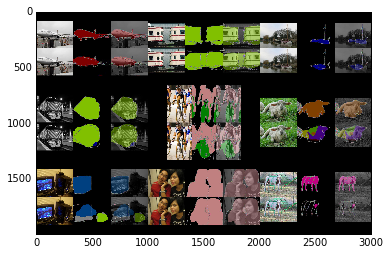






Train epoch=0:  47%|█████████▉           | 4001/8498 [14:18<22:53:01, 18.32s/it]




Train epoch=0:  47%|█████████▉           | 4002/8498 [14:18<16:04:45, 12.87s/it]




Train epoch=0:  47%|█████████▉           | 4003/8498 [14:18<11:18:26,  9.06s/it]




Train epoch=0:  47%|██████████▎           | 4004/8498 [14:18<7:58:52,  6.39s/it]




Train epoch=0:  47%|██████████▎           | 4005/8498 [14:18<5:39:11,  4.53s/it]




Train epoch=0:  47%|██████████▎           | 4006/8498 [14:18<4:01:30,  3.23s/it]




Train epoch=0:  47%|██████████▎           | 4007/8498 [14:19<2:53:06,  2.31s/it]




Train epoch=0:  47%|██████████▍           | 4008/8498 [14:19<2:04:47,  1.67s/it]




Train epoch=0:  47%|██████████▍           | 4009/8498 [14:19<1:31:30,  1.22s/it]




Train epoch=0:  47%|██████████▍           | 4010/8498 [14:19<1:08:05,  1.10it/s]




Train epoch=0:  47%|███████████▎            | 4011/8498 [14:19<51:45,  1.44it/s]




Train epoch=0:  47%|███████████▎            | 4012/8498 [14:

Train epoch=0:  48%|███████████▌            | 4082/8498 [14:32<13:04,  5.63it/s]




Train epoch=0:  48%|███████████▌            | 4083/8498 [14:32<13:14,  5.55it/s]




Train epoch=0:  48%|███████████▌            | 4084/8498 [14:32<13:18,  5.53it/s]




Train epoch=0:  48%|███████████▌            | 4085/8498 [14:33<13:10,  5.58it/s]




Train epoch=0:  48%|███████████▌            | 4086/8498 [14:33<13:05,  5.62it/s]




Train epoch=0:  48%|███████████▌            | 4087/8498 [14:33<13:03,  5.63it/s]




Train epoch=0:  48%|███████████▌            | 4088/8498 [14:33<12:52,  5.71it/s]




Train epoch=0:  48%|███████████▌            | 4089/8498 [14:33<12:54,  5.69it/s]




Train epoch=0:  48%|███████████▌            | 4090/8498 [14:33<13:05,  5.61it/s]




Train epoch=0:  48%|███████████▌            | 4091/8498 [14:34<13:11,  5.56it/s]




Train epoch=0:  48%|███████████▌            | 4092/8498 [14:34<13:15,  5.54it/s]




Train epoch=0:  48%|███████████▌            | 4093/8498 [14:34<13

Train epoch=0:  49%|███████████▊            | 4163/8498 [14:47<13:16,  5.44it/s]




Train epoch=0:  49%|███████████▊            | 4164/8498 [14:47<13:05,  5.51it/s]




Train epoch=0:  49%|███████████▊            | 4165/8498 [14:47<13:07,  5.50it/s]




Train epoch=0:  49%|███████████▊            | 4166/8498 [14:48<12:25,  5.81it/s]




Train epoch=0:  49%|███████████▊            | 4167/8498 [14:48<13:05,  5.52it/s]




Train epoch=0:  49%|███████████▊            | 4168/8498 [14:48<13:32,  5.33it/s]




Train epoch=0:  49%|███████████▊            | 4169/8498 [14:48<13:38,  5.29it/s]




Train epoch=0:  49%|███████████▊            | 4170/8498 [14:48<13:56,  5.17it/s]




Train epoch=0:  49%|███████████▊            | 4171/8498 [14:49<13:00,  5.54it/s]




Train epoch=0:  49%|███████████▊            | 4172/8498 [14:49<13:24,  5.38it/s]




Train epoch=0:  49%|███████████▊            | 4173/8498 [14:49<13:41,  5.26it/s]




Train epoch=0:  49%|███████████▊            | 4174/8498 [14:49<13

Train epoch=0:  50%|███████████▉            | 4244/8498 [15:02<12:54,  5.49it/s]




Train epoch=0:  50%|███████████▉            | 4245/8498 [15:02<12:56,  5.48it/s]




Train epoch=0:  50%|███████████▉            | 4246/8498 [15:02<13:02,  5.43it/s]




Train epoch=0:  50%|███████████▉            | 4247/8498 [15:03<13:27,  5.26it/s]




Train epoch=0:  50%|███████████▉            | 4248/8498 [15:03<13:38,  5.19it/s]




Train epoch=0:  50%|████████████            | 4249/8498 [15:03<13:52,  5.11it/s]




Train epoch=0:  50%|████████████            | 4250/8498 [15:03<13:52,  5.10it/s]




Train epoch=0:  50%|████████████            | 4251/8498 [15:03<13:47,  5.13it/s]




Train epoch=0:  50%|████████████            | 4252/8498 [15:04<13:46,  5.14it/s]




Train epoch=0:  50%|████████████            | 4253/8498 [15:04<13:39,  5.18it/s]




Train epoch=0:  50%|████████████            | 4254/8498 [15:04<13:25,  5.27it/s]




Train epoch=0:  50%|████████████            | 4255/8498 [15:04<13

Train epoch=0:  51%|████████████▏           | 4325/8498 [15:17<12:40,  5.49it/s]




Train epoch=0:  51%|████████████▏           | 4326/8498 [15:17<11:52,  5.85it/s]




Train epoch=0:  51%|████████████▏           | 4327/8498 [15:17<11:27,  6.06it/s]




Train epoch=0:  51%|████████████▏           | 4328/8498 [15:18<11:58,  5.80it/s]




Train epoch=0:  51%|████████████▏           | 4329/8498 [15:18<12:15,  5.67it/s]




Train epoch=0:  51%|████████████▏           | 4330/8498 [15:18<12:25,  5.59it/s]




Train epoch=0:  51%|████████████▏           | 4331/8498 [15:18<12:31,  5.54it/s]




Train epoch=0:  51%|████████████▏           | 4332/8498 [15:18<12:49,  5.41it/s]




Train epoch=0:  51%|████████████▏           | 4333/8498 [15:19<12:26,  5.58it/s]




Train epoch=0:  51%|████████████▏           | 4334/8498 [15:19<12:33,  5.53it/s]




Train epoch=0:  51%|████████████▏           | 4335/8498 [15:19<12:41,  5.47it/s]




Train epoch=0:  51%|████████████▏           | 4336/8498 [15:19<12

Train epoch=0:  52%|████████████▍           | 4406/8498 [15:32<12:33,  5.43it/s]




Train epoch=0:  52%|████████████▍           | 4407/8498 [15:32<12:35,  5.42it/s]




Train epoch=0:  52%|████████████▍           | 4408/8498 [15:33<12:27,  5.47it/s]




Train epoch=0:  52%|████████████▍           | 4409/8498 [15:33<12:30,  5.45it/s]




Train epoch=0:  52%|████████████▍           | 4410/8498 [15:33<12:32,  5.43it/s]




Train epoch=0:  52%|████████████▍           | 4411/8498 [15:33<12:26,  5.47it/s]




Train epoch=0:  52%|████████████▍           | 4412/8498 [15:33<12:22,  5.50it/s]




Train epoch=0:  52%|████████████▍           | 4413/8498 [15:34<12:41,  5.36it/s]




Train epoch=0:  52%|████████████▍           | 4414/8498 [15:34<13:00,  5.23it/s]




Train epoch=0:  52%|████████████▍           | 4415/8498 [15:34<13:16,  5.13it/s]




Train epoch=0:  52%|████████████▍           | 4416/8498 [15:34<13:26,  5.06it/s]




Train epoch=0:  52%|████████████▍           | 4417/8498 [15:34<13

Train epoch=0:  53%|████████████▋           | 4487/8498 [15:48<12:52,  5.19it/s]




Train epoch=0:  53%|████████████▋           | 4488/8498 [15:48<13:04,  5.11it/s]




Train epoch=0:  53%|████████████▋           | 4489/8498 [15:48<13:08,  5.08it/s]




Train epoch=0:  53%|████████████▋           | 4490/8498 [15:48<12:59,  5.14it/s]




Train epoch=0:  53%|████████████▋           | 4491/8498 [15:48<13:03,  5.11it/s]




Train epoch=0:  53%|████████████▋           | 4492/8498 [15:49<13:05,  5.10it/s]




Train epoch=0:  53%|████████████▋           | 4493/8498 [15:49<12:58,  5.14it/s]




Train epoch=0:  53%|████████████▋           | 4494/8498 [15:49<12:46,  5.23it/s]




Train epoch=0:  53%|████████████▋           | 4495/8498 [15:49<12:39,  5.27it/s]




Train epoch=0:  53%|████████████▋           | 4496/8498 [15:49<12:31,  5.33it/s]




Train epoch=0:  53%|████████████▋           | 4497/8498 [15:50<12:26,  5.36it/s]




Train epoch=0:  53%|████████████▋           | 4498/8498 [15:50<12

Train epoch=0:  54%|████████████▉           | 4568/8498 [16:03<12:12,  5.36it/s]




Train epoch=0:  54%|████████████▉           | 4569/8498 [16:03<12:10,  5.37it/s]




Train epoch=0:  54%|████████████▉           | 4570/8498 [16:03<12:06,  5.40it/s]




Train epoch=0:  54%|████████████▉           | 4571/8498 [16:04<12:13,  5.36it/s]




Train epoch=0:  54%|████████████▉           | 4572/8498 [16:04<12:28,  5.25it/s]




Train epoch=0:  54%|████████████▉           | 4573/8498 [16:04<12:46,  5.12it/s]




Train epoch=0:  54%|████████████▉           | 4574/8498 [16:04<12:55,  5.06it/s]




Train epoch=0:  54%|████████████▉           | 4575/8498 [16:04<12:54,  5.07it/s]




Train epoch=0:  54%|████████████▉           | 4576/8498 [16:05<12:46,  5.12it/s]




Train epoch=0:  54%|████████████▉           | 4577/8498 [16:05<12:46,  5.12it/s]




Train epoch=0:  54%|████████████▉           | 4578/8498 [16:05<13:03,  5.00it/s]




Train epoch=0:  54%|████████████▉           | 4579/8498 [16:05<12

Train epoch=0:  55%|█████████████▏          | 4649/8498 [16:18<12:02,  5.33it/s]




Train epoch=0:  55%|█████████████▏          | 4650/8498 [16:19<12:08,  5.28it/s]




Train epoch=0:  55%|█████████████▏          | 4651/8498 [16:19<12:22,  5.18it/s]




Train epoch=0:  55%|█████████████▏          | 4652/8498 [16:19<12:01,  5.33it/s]




Train epoch=0:  55%|█████████████▏          | 4653/8498 [16:19<11:58,  5.35it/s]




Train epoch=0:  55%|█████████████▏          | 4654/8498 [16:19<12:14,  5.23it/s]




Train epoch=0:  55%|█████████████▏          | 4655/8498 [16:20<12:15,  5.23it/s]




Train epoch=0:  55%|█████████████▏          | 4656/8498 [16:20<12:26,  5.14it/s]




Train epoch=0:  55%|█████████████▏          | 4657/8498 [16:20<12:24,  5.16it/s]




Train epoch=0:  55%|█████████████▏          | 4658/8498 [16:20<12:25,  5.15it/s]




Train epoch=0:  55%|█████████████▏          | 4659/8498 [16:20<12:36,  5.08it/s]




Train epoch=0:  55%|█████████████▏          | 4660/8498 [16:21<12

Train epoch=0:  56%|█████████████▎          | 4730/8498 [16:34<11:17,  5.56it/s]




Train epoch=0:  56%|█████████████▎          | 4731/8498 [16:34<11:25,  5.50it/s]




Train epoch=0:  56%|█████████████▎          | 4732/8498 [16:34<11:43,  5.35it/s]




Train epoch=0:  56%|█████████████▎          | 4733/8498 [16:34<11:50,  5.30it/s]




Train epoch=0:  56%|█████████████▎          | 4734/8498 [16:35<11:44,  5.34it/s]




Train epoch=0:  56%|█████████████▎          | 4735/8498 [16:35<11:45,  5.34it/s]




Train epoch=0:  56%|█████████████▍          | 4736/8498 [16:35<11:32,  5.44it/s]




Train epoch=0:  56%|█████████████▍          | 4737/8498 [16:35<11:33,  5.42it/s]




Train epoch=0:  56%|█████████████▍          | 4738/8498 [16:35<11:32,  5.43it/s]




Train epoch=0:  56%|█████████████▍          | 4739/8498 [16:35<11:34,  5.41it/s]




Train epoch=0:  56%|█████████████▍          | 4740/8498 [16:36<11:36,  5.40it/s]




Train epoch=0:  56%|█████████████▍          | 4741/8498 [16:36<11

Train epoch=0:  57%|█████████████▌          | 4811/8498 [16:49<11:49,  5.20it/s]




Train epoch=0:  57%|█████████████▌          | 4812/8498 [16:49<12:01,  5.11it/s]




Train epoch=0:  57%|█████████████▌          | 4813/8498 [16:49<12:04,  5.08it/s]




Train epoch=0:  57%|█████████████▌          | 4814/8498 [16:50<12:02,  5.10it/s]




Train epoch=0:  57%|█████████████▌          | 4815/8498 [16:50<11:46,  5.21it/s]




Train epoch=0:  57%|█████████████▌          | 4816/8498 [16:50<11:32,  5.32it/s]




Train epoch=0:  57%|█████████████▌          | 4817/8498 [16:50<11:34,  5.30it/s]




Train epoch=0:  57%|█████████████▌          | 4818/8498 [16:50<11:32,  5.31it/s]




Train epoch=0:  57%|█████████████▌          | 4819/8498 [16:51<11:29,  5.33it/s]




Train epoch=0:  57%|█████████████▌          | 4820/8498 [16:51<11:16,  5.44it/s]




Train epoch=0:  57%|█████████████▌          | 4821/8498 [16:51<11:19,  5.41it/s]




Train epoch=0:  57%|█████████████▌          | 4822/8498 [16:51<11

Train epoch=0:  58%|█████████████▊          | 4892/8498 [17:04<11:37,  5.17it/s]




Train epoch=0:  58%|█████████████▊          | 4893/8498 [17:04<11:26,  5.26it/s]




Train epoch=0:  58%|█████████████▊          | 4894/8498 [17:05<11:20,  5.30it/s]




Train epoch=0:  58%|█████████████▊          | 4895/8498 [17:05<11:13,  5.35it/s]




Train epoch=0:  58%|█████████████▊          | 4896/8498 [17:05<11:15,  5.33it/s]




Train epoch=0:  58%|█████████████▊          | 4897/8498 [17:05<11:03,  5.43it/s]




Train epoch=0:  58%|█████████████▊          | 4898/8498 [17:05<10:57,  5.47it/s]




Train epoch=0:  58%|█████████████▊          | 4899/8498 [17:05<10:50,  5.53it/s]




Train epoch=0:  58%|█████████████▊          | 4900/8498 [17:06<10:50,  5.53it/s]




Train epoch=0:  58%|█████████████▊          | 4901/8498 [17:06<10:29,  5.72it/s]




Train epoch=0:  58%|█████████████▊          | 4902/8498 [17:06<10:41,  5.60it/s]




Train epoch=0:  58%|█████████████▊          | 4903/8498 [17:06<10

Train epoch=0:  59%|██████████████          | 4973/8498 [17:19<10:26,  5.62it/s]




Train epoch=0:  59%|██████████████          | 4974/8498 [17:19<10:36,  5.54it/s]




Train epoch=0:  59%|██████████████          | 4975/8498 [17:20<10:41,  5.49it/s]




Train epoch=0:  59%|██████████████          | 4976/8498 [17:20<10:55,  5.38it/s]




Train epoch=0:  59%|██████████████          | 4977/8498 [17:20<11:12,  5.24it/s]




Train epoch=0:  59%|██████████████          | 4978/8498 [17:20<11:20,  5.17it/s]




Train epoch=0:  59%|██████████████          | 4979/8498 [17:20<11:30,  5.09it/s]




Train epoch=0:  59%|██████████████          | 4980/8498 [17:21<11:35,  5.06it/s]




Train epoch=0:  59%|██████████████          | 4981/8498 [17:21<11:40,  5.02it/s]




Train epoch=0:  59%|██████████████          | 4982/8498 [17:21<11:31,  5.08it/s]




Train epoch=0:  59%|██████████████          | 4983/8498 [17:21<11:35,  5.05it/s]




Train epoch=0:  59%|██████████████          | 4984/8498 [17:21<11

Train epoch=0:  59%|██████████████▎         | 5054/8498 [17:35<10:26,  5.49it/s]




Train epoch=0:  59%|██████████████▎         | 5055/8498 [17:35<10:26,  5.50it/s]




Train epoch=0:  59%|██████████████▎         | 5056/8498 [17:35<10:24,  5.51it/s]




Train epoch=0:  60%|██████████████▎         | 5057/8498 [17:35<10:44,  5.34it/s]




Train epoch=0:  60%|██████████████▎         | 5058/8498 [17:35<10:46,  5.32it/s]




Train epoch=0:  60%|██████████████▎         | 5059/8498 [17:36<10:49,  5.30it/s]




Train epoch=0:  60%|██████████████▎         | 5060/8498 [17:36<10:48,  5.30it/s]




Train epoch=0:  60%|██████████████▎         | 5061/8498 [17:36<11:00,  5.20it/s]




Train epoch=0:  60%|██████████████▎         | 5062/8498 [17:36<10:54,  5.25it/s]




Train epoch=0:  60%|██████████████▎         | 5063/8498 [17:36<11:29,  4.98it/s]




Train epoch=0:  60%|██████████████▎         | 5064/8498 [17:37<11:13,  5.10it/s]




Train epoch=0:  60%|██████████████▎         | 5065/8498 [17:37<10

Train epoch=0:  60%|██████████████▌         | 5135/8498 [17:50<10:26,  5.37it/s]




Train epoch=0:  60%|██████████████▌         | 5136/8498 [17:50<10:21,  5.41it/s]




Train epoch=0:  60%|██████████████▌         | 5137/8498 [17:50<10:21,  5.41it/s]




Train epoch=0:  60%|██████████████▌         | 5138/8498 [17:51<10:27,  5.35it/s]




Train epoch=0:  60%|██████████████▌         | 5139/8498 [17:51<10:41,  5.24it/s]




Train epoch=0:  60%|██████████████▌         | 5140/8498 [17:51<10:50,  5.16it/s]




Train epoch=0:  60%|██████████████▌         | 5141/8498 [17:51<10:59,  5.09it/s]




Train epoch=0:  61%|██████████████▌         | 5142/8498 [17:51<10:51,  5.15it/s]




Train epoch=0:  61%|██████████████▌         | 5143/8498 [17:52<10:54,  5.13it/s]




Train epoch=0:  61%|██████████████▌         | 5144/8498 [17:52<10:56,  5.11it/s]




Train epoch=0:  61%|██████████████▌         | 5145/8498 [17:52<11:02,  5.06it/s]




Train epoch=0:  61%|██████████████▌         | 5146/8498 [17:52<10

Train epoch=0:  61%|██████████████▋         | 5216/8498 [18:05<10:42,  5.10it/s]




Train epoch=0:  61%|██████████████▋         | 5217/8498 [18:06<10:32,  5.19it/s]




Train epoch=0:  61%|██████████████▋         | 5218/8498 [18:06<10:32,  5.19it/s]




Train epoch=0:  61%|██████████████▋         | 5219/8498 [18:06<10:34,  5.16it/s]




Train epoch=0:  61%|██████████████▋         | 5220/8498 [18:06<10:31,  5.19it/s]




Train epoch=0:  61%|██████████████▋         | 5221/8498 [18:06<10:29,  5.20it/s]




Train epoch=0:  61%|██████████████▋         | 5222/8498 [18:07<10:03,  5.43it/s]




Train epoch=0:  61%|██████████████▊         | 5223/8498 [18:07<09:53,  5.52it/s]




Train epoch=0:  61%|██████████████▊         | 5224/8498 [18:07<10:25,  5.23it/s]




Train epoch=0:  61%|██████████████▊         | 5225/8498 [18:07<10:04,  5.42it/s]




Train epoch=0:  61%|██████████████▊         | 5226/8498 [18:07<10:09,  5.37it/s]




Train epoch=0:  62%|██████████████▊         | 5227/8498 [18:08<10

Train epoch=0:  62%|██████████████▉         | 5297/8498 [18:21<09:59,  5.34it/s]




Train epoch=0:  62%|██████████████▉         | 5298/8498 [18:21<10:18,  5.17it/s]




Train epoch=0:  62%|██████████████▉         | 5299/8498 [18:21<09:43,  5.48it/s]




Train epoch=0:  62%|██████████████▉         | 5300/8498 [18:21<09:58,  5.34it/s]




Train epoch=0:  62%|██████████████▉         | 5301/8498 [18:21<10:02,  5.30it/s]




Train epoch=0:  62%|██████████████▉         | 5302/8498 [18:22<10:14,  5.20it/s]




Train epoch=0:  62%|██████████████▉         | 5303/8498 [18:22<10:24,  5.12it/s]




Train epoch=0:  62%|██████████████▉         | 5304/8498 [18:22<09:57,  5.35it/s]




Train epoch=0:  62%|██████████████▉         | 5305/8498 [18:22<10:21,  5.14it/s]




Train epoch=0:  62%|██████████████▉         | 5306/8498 [18:22<10:16,  5.17it/s]




Train epoch=0:  62%|██████████████▉         | 5307/8498 [18:23<10:06,  5.26it/s]




Train epoch=0:  62%|██████████████▉         | 5308/8498 [18:23<10

Train epoch=0:  63%|███████████████▏        | 5379/8498 [18:36<10:21,  5.02it/s]




Train epoch=0:  63%|███████████████▏        | 5380/8498 [18:37<10:22,  5.01it/s]




Train epoch=0:  63%|███████████████▏        | 5381/8498 [18:37<10:18,  5.04it/s]




Train epoch=0:  63%|███████████████▏        | 5382/8498 [18:37<10:10,  5.11it/s]




Train epoch=0:  63%|███████████████▏        | 5383/8498 [18:37<10:15,  5.06it/s]




Train epoch=0:  63%|███████████████▏        | 5384/8498 [18:37<10:10,  5.10it/s]




Train epoch=0:  63%|███████████████▏        | 5385/8498 [18:38<10:05,  5.14it/s]




Train epoch=0:  63%|███████████████▏        | 5386/8498 [18:38<10:27,  4.96it/s]




Train epoch=0:  63%|███████████████▏        | 5387/8498 [18:38<10:17,  5.04it/s]




Train epoch=0:  63%|███████████████▏        | 5388/8498 [18:38<10:05,  5.14it/s]




Train epoch=0:  63%|███████████████▏        | 5389/8498 [18:38<10:02,  5.16it/s]




Train epoch=0:  63%|███████████████▏        | 5390/8498 [18:39<09

Train epoch=0:  64%|███████████████▍        | 5460/8498 [18:52<09:28,  5.34it/s]




Train epoch=0:  64%|███████████████▍        | 5461/8498 [18:52<09:16,  5.46it/s]




Train epoch=0:  64%|███████████████▍        | 5462/8498 [18:52<09:19,  5.43it/s]




Train epoch=0:  64%|███████████████▍        | 5463/8498 [18:52<10:02,  5.04it/s]




Train epoch=0:  64%|███████████████▍        | 5464/8498 [18:53<09:58,  5.07it/s]




Train epoch=0:  64%|███████████████▍        | 5465/8498 [18:53<09:58,  5.07it/s]




Train epoch=0:  64%|███████████████▍        | 5466/8498 [18:53<10:01,  5.04it/s]




Train epoch=0:  64%|███████████████▍        | 5467/8498 [18:53<09:10,  5.50it/s]




Train epoch=0:  64%|███████████████▍        | 5468/8498 [18:53<09:21,  5.40it/s]




Train epoch=0:  64%|███████████████▍        | 5469/8498 [18:54<09:29,  5.32it/s]




Train epoch=0:  64%|███████████████▍        | 5470/8498 [18:54<09:33,  5.28it/s]




Train epoch=0:  64%|███████████████▍        | 5471/8498 [18:54<09

Train epoch=0:  65%|███████████████▋        | 5541/8498 [19:07<09:37,  5.12it/s]




Train epoch=0:  65%|███████████████▋        | 5542/8498 [19:07<09:38,  5.11it/s]




Train epoch=0:  65%|███████████████▋        | 5543/8498 [19:08<09:34,  5.14it/s]




Train epoch=0:  65%|███████████████▋        | 5544/8498 [19:08<09:25,  5.22it/s]




Train epoch=0:  65%|███████████████▋        | 5545/8498 [19:08<09:22,  5.25it/s]




Train epoch=0:  65%|███████████████▋        | 5546/8498 [19:08<09:26,  5.21it/s]




Train epoch=0:  65%|███████████████▋        | 5547/8498 [19:08<09:20,  5.26it/s]




Train epoch=0:  65%|███████████████▋        | 5548/8498 [19:09<08:59,  5.47it/s]




Train epoch=0:  65%|███████████████▋        | 5549/8498 [19:09<09:01,  5.45it/s]




Train epoch=0:  65%|███████████████▋        | 5550/8498 [19:09<09:07,  5.38it/s]




Train epoch=0:  65%|███████████████▋        | 5551/8498 [19:09<09:20,  5.26it/s]




Train epoch=0:  65%|███████████████▋        | 5552/8498 [19:09<09

Train epoch=0:  66%|███████████████▉        | 5622/8498 [19:23<09:37,  4.98it/s]




Train epoch=0:  66%|███████████████▉        | 5623/8498 [19:23<09:40,  4.95it/s]




Train epoch=0:  66%|███████████████▉        | 5624/8498 [19:23<09:41,  4.94it/s]




Train epoch=0:  66%|███████████████▉        | 5625/8498 [19:23<09:40,  4.95it/s]




Train epoch=0:  66%|███████████████▉        | 5626/8498 [19:23<09:42,  4.93it/s]




Train epoch=0:  66%|███████████████▉        | 5627/8498 [19:24<09:32,  5.01it/s]




Train epoch=0:  66%|███████████████▉        | 5628/8498 [19:24<09:31,  5.02it/s]




Train epoch=0:  66%|███████████████▉        | 5629/8498 [19:24<09:32,  5.01it/s]




Train epoch=0:  66%|███████████████▉        | 5630/8498 [19:24<09:21,  5.11it/s]




Train epoch=0:  66%|███████████████▉        | 5631/8498 [19:24<09:23,  5.08it/s]




Train epoch=0:  66%|███████████████▉        | 5632/8498 [19:25<09:29,  5.03it/s]




Train epoch=0:  66%|███████████████▉        | 5633/8498 [19:25<09

Train epoch=0:  67%|████████████████        | 5703/8498 [19:38<08:32,  5.46it/s]




Train epoch=0:  67%|████████████████        | 5704/8498 [19:38<08:31,  5.47it/s]




Train epoch=0:  67%|████████████████        | 5705/8498 [19:38<08:34,  5.43it/s]




Train epoch=0:  67%|████████████████        | 5706/8498 [19:39<08:50,  5.26it/s]




Train epoch=0:  67%|████████████████        | 5707/8498 [19:39<08:49,  5.27it/s]




Train epoch=0:  67%|████████████████        | 5708/8498 [19:39<08:56,  5.20it/s]




Train epoch=0:  67%|████████████████        | 5709/8498 [19:39<08:56,  5.20it/s]




Train epoch=0:  67%|████████████████▏       | 5710/8498 [19:39<08:45,  5.31it/s]




Train epoch=0:  67%|████████████████▏       | 5711/8498 [19:40<08:52,  5.23it/s]




Train epoch=0:  67%|████████████████▏       | 5712/8498 [19:40<08:59,  5.17it/s]




Train epoch=0:  67%|████████████████▏       | 5713/8498 [19:40<09:05,  5.11it/s]




Train epoch=0:  67%|████████████████▏       | 5714/8498 [19:40<09

Train epoch=0:  68%|████████████████▎       | 5784/8498 [19:53<08:11,  5.52it/s]




Train epoch=0:  68%|████████████████▎       | 5785/8498 [19:54<08:15,  5.47it/s]




Train epoch=0:  68%|████████████████▎       | 5786/8498 [19:54<08:22,  5.40it/s]




Train epoch=0:  68%|████████████████▎       | 5787/8498 [19:54<08:03,  5.60it/s]




Train epoch=0:  68%|████████████████▎       | 5788/8498 [19:54<08:12,  5.50it/s]




Train epoch=0:  68%|████████████████▎       | 5789/8498 [19:54<08:22,  5.39it/s]




Train epoch=0:  68%|████████████████▎       | 5790/8498 [19:54<08:19,  5.42it/s]




Train epoch=0:  68%|████████████████▎       | 5791/8498 [19:55<08:24,  5.37it/s]




Train epoch=0:  68%|████████████████▎       | 5792/8498 [19:55<08:14,  5.48it/s]




Train epoch=0:  68%|████████████████▎       | 5793/8498 [19:55<08:10,  5.52it/s]




Train epoch=0:  68%|████████████████▎       | 5794/8498 [19:55<08:14,  5.47it/s]




Train epoch=0:  68%|████████████████▎       | 5795/8498 [19:55<08

Train epoch=0:  69%|████████████████▌       | 5865/8498 [20:08<08:01,  5.47it/s]




Train epoch=0:  69%|████████████████▌       | 5866/8498 [20:09<08:08,  5.39it/s]




Train epoch=0:  69%|████████████████▌       | 5867/8498 [20:09<08:19,  5.27it/s]




Train epoch=0:  69%|████████████████▌       | 5868/8498 [20:09<07:46,  5.64it/s]




Train epoch=0:  69%|████████████████▌       | 5869/8498 [20:09<07:48,  5.61it/s]




Train epoch=0:  69%|████████████████▌       | 5870/8498 [20:09<07:12,  6.07it/s]




Train epoch=0:  69%|████████████████▌       | 5871/8498 [20:09<07:31,  5.82it/s]




Train epoch=0:  69%|████████████████▌       | 5872/8498 [20:10<07:47,  5.62it/s]




Train epoch=0:  69%|████████████████▌       | 5873/8498 [20:10<08:05,  5.41it/s]




Train epoch=0:  69%|████████████████▌       | 5874/8498 [20:10<08:19,  5.25it/s]




Train epoch=0:  69%|████████████████▌       | 5875/8498 [20:10<08:19,  5.25it/s]




Train epoch=0:  69%|████████████████▌       | 5876/8498 [20:10<08

Train epoch=0:  70%|████████████████▊       | 5946/8498 [20:24<08:16,  5.14it/s]




Train epoch=0:  70%|████████████████▊       | 5947/8498 [20:24<08:13,  5.17it/s]




Train epoch=0:  70%|████████████████▊       | 5948/8498 [20:24<08:04,  5.27it/s]




Train epoch=0:  70%|████████████████▊       | 5949/8498 [20:24<08:00,  5.31it/s]




Train epoch=0:  70%|████████████████▊       | 5950/8498 [20:24<07:56,  5.35it/s]




Train epoch=0:  70%|████████████████▊       | 5951/8498 [20:24<07:53,  5.38it/s]




Train epoch=0:  70%|████████████████▊       | 5952/8498 [20:25<07:55,  5.35it/s]




Train epoch=0:  70%|████████████████▊       | 5953/8498 [20:25<07:51,  5.40it/s]




Train epoch=0:  70%|████████████████▊       | 5954/8498 [20:25<07:52,  5.39it/s]




Train epoch=0:  70%|████████████████▊       | 5955/8498 [20:25<07:53,  5.37it/s]




Train epoch=0:  70%|████████████████▊       | 5956/8498 [20:25<07:51,  5.40it/s]




Train epoch=0:  70%|████████████████▊       | 5957/8498 [20:26<07

Train epoch=0:  71%|█████████████████       | 6027/8498 [20:39<07:34,  5.44it/s]




Train epoch=0:  71%|█████████████████       | 6028/8498 [20:39<07:30,  5.49it/s]




Train epoch=0:  71%|█████████████████       | 6029/8498 [20:39<07:28,  5.50it/s]




Train epoch=0:  71%|█████████████████       | 6030/8498 [20:39<07:25,  5.54it/s]




Train epoch=0:  71%|█████████████████       | 6031/8498 [20:40<07:29,  5.49it/s]




Train epoch=0:  71%|█████████████████       | 6032/8498 [20:40<07:41,  5.34it/s]




Train epoch=0:  71%|█████████████████       | 6033/8498 [20:40<07:44,  5.30it/s]




Train epoch=0:  71%|█████████████████       | 6034/8498 [20:40<07:45,  5.29it/s]




Train epoch=0:  71%|█████████████████       | 6035/8498 [20:40<07:49,  5.24it/s]




Train epoch=0:  71%|█████████████████       | 6036/8498 [20:40<07:30,  5.47it/s]




Train epoch=0:  71%|█████████████████       | 6037/8498 [20:41<07:27,  5.50it/s]




Train epoch=0:  71%|█████████████████       | 6038/8498 [20:41<07

Train epoch=0:  72%|█████████████████▎      | 6108/8498 [20:54<07:30,  5.30it/s]




Train epoch=0:  72%|█████████████████▎      | 6109/8498 [20:54<07:24,  5.37it/s]




Train epoch=0:  72%|█████████████████▎      | 6110/8498 [20:55<07:25,  5.36it/s]




Train epoch=0:  72%|█████████████████▎      | 6111/8498 [20:55<07:26,  5.35it/s]




Train epoch=0:  72%|█████████████████▎      | 6112/8498 [20:55<07:24,  5.37it/s]




Train epoch=0:  72%|█████████████████▎      | 6113/8498 [20:55<07:21,  5.40it/s]




Train epoch=0:  72%|█████████████████▎      | 6114/8498 [20:55<07:33,  5.25it/s]




Train epoch=0:  72%|█████████████████▎      | 6115/8498 [20:55<07:42,  5.15it/s]




Train epoch=0:  72%|█████████████████▎      | 6116/8498 [20:56<07:47,  5.09it/s]




Train epoch=0:  72%|█████████████████▎      | 6117/8498 [20:56<07:47,  5.09it/s]




Train epoch=0:  72%|█████████████████▎      | 6118/8498 [20:56<07:40,  5.16it/s]




Train epoch=0:  72%|█████████████████▎      | 6119/8498 [20:56<07

Train epoch=0:  73%|█████████████████▍      | 6189/8498 [21:09<07:02,  5.46it/s]




Train epoch=0:  73%|█████████████████▍      | 6190/8498 [21:09<07:06,  5.41it/s]




Train epoch=0:  73%|█████████████████▍      | 6191/8498 [21:09<06:49,  5.63it/s]




Train epoch=0:  73%|█████████████████▍      | 6192/8498 [21:10<06:48,  5.65it/s]




Train epoch=0:  73%|█████████████████▍      | 6193/8498 [21:10<06:54,  5.57it/s]




Train epoch=0:  73%|█████████████████▍      | 6194/8498 [21:10<06:56,  5.54it/s]




Train epoch=0:  73%|█████████████████▍      | 6195/8498 [21:10<06:53,  5.57it/s]




Train epoch=0:  73%|█████████████████▍      | 6196/8498 [21:10<06:55,  5.54it/s]




Train epoch=0:  73%|█████████████████▌      | 6197/8498 [21:11<07:00,  5.47it/s]




Train epoch=0:  73%|█████████████████▌      | 6198/8498 [21:11<07:31,  5.10it/s]




Train epoch=0:  73%|█████████████████▌      | 6199/8498 [21:11<07:32,  5.08it/s]




Train epoch=0:  73%|█████████████████▌      | 6200/8498 [21:11<07

Train epoch=0:  74%|█████████████████▋      | 6270/8498 [21:24<07:22,  5.04it/s]




Train epoch=0:  74%|█████████████████▋      | 6271/8498 [21:25<07:17,  5.09it/s]




Train epoch=0:  74%|█████████████████▋      | 6272/8498 [21:25<07:12,  5.15it/s]




Train epoch=0:  74%|█████████████████▋      | 6273/8498 [21:25<07:05,  5.23it/s]




Train epoch=0:  74%|█████████████████▋      | 6274/8498 [21:25<07:00,  5.28it/s]




Train epoch=0:  74%|█████████████████▋      | 6275/8498 [21:25<06:50,  5.41it/s]




Train epoch=0:  74%|█████████████████▋      | 6276/8498 [21:25<06:52,  5.39it/s]




Train epoch=0:  74%|█████████████████▋      | 6277/8498 [21:26<06:52,  5.38it/s]




Train epoch=0:  74%|█████████████████▋      | 6278/8498 [21:26<06:50,  5.41it/s]




Train epoch=0:  74%|█████████████████▋      | 6279/8498 [21:26<06:43,  5.49it/s]




Train epoch=0:  74%|█████████████████▋      | 6280/8498 [21:26<06:52,  5.38it/s]




Train epoch=0:  74%|█████████████████▋      | 6281/8498 [21:26<06

Train epoch=0:  75%|█████████████████▉      | 6351/8498 [21:39<06:12,  5.77it/s]




Train epoch=0:  75%|█████████████████▉      | 6352/8498 [21:39<06:23,  5.60it/s]




Train epoch=0:  75%|█████████████████▉      | 6353/8498 [21:40<06:30,  5.49it/s]




Train epoch=0:  75%|█████████████████▉      | 6354/8498 [21:40<06:32,  5.46it/s]




Train epoch=0:  75%|█████████████████▉      | 6355/8498 [21:40<06:34,  5.43it/s]




Train epoch=0:  75%|█████████████████▉      | 6356/8498 [21:40<06:33,  5.44it/s]




Train epoch=0:  75%|█████████████████▉      | 6357/8498 [21:40<06:34,  5.42it/s]




Train epoch=0:  75%|█████████████████▉      | 6358/8498 [21:41<06:36,  5.39it/s]




Train epoch=0:  75%|█████████████████▉      | 6359/8498 [21:41<06:37,  5.38it/s]




Train epoch=0:  75%|█████████████████▉      | 6360/8498 [21:41<06:43,  5.30it/s]




Train epoch=0:  75%|█████████████████▉      | 6361/8498 [21:41<06:44,  5.28it/s]




Train epoch=0:  75%|█████████████████▉      | 6362/8498 [21:41<06

Train epoch=0:  76%|██████████████████▏     | 6432/8498 [21:55<06:20,  5.43it/s]




Train epoch=0:  76%|██████████████████▏     | 6433/8498 [21:55<06:20,  5.43it/s]




Train epoch=0:  76%|██████████████████▏     | 6434/8498 [21:55<06:17,  5.47it/s]




Train epoch=0:  76%|██████████████████▏     | 6435/8498 [21:55<06:23,  5.38it/s]




Train epoch=0:  76%|██████████████████▏     | 6436/8498 [21:55<06:27,  5.33it/s]




Train epoch=0:  76%|██████████████████▏     | 6437/8498 [21:55<06:28,  5.31it/s]




Train epoch=0:  76%|██████████████████▏     | 6438/8498 [21:56<06:23,  5.37it/s]




Train epoch=0:  76%|██████████████████▏     | 6439/8498 [21:56<06:23,  5.37it/s]




Train epoch=0:  76%|██████████████████▏     | 6440/8498 [21:56<06:18,  5.44it/s]




Train epoch=0:  76%|██████████████████▏     | 6441/8498 [21:56<06:08,  5.58it/s]




Train epoch=0:  76%|██████████████████▏     | 6442/8498 [21:56<06:08,  5.58it/s]




Train epoch=0:  76%|██████████████████▏     | 6443/8498 [21:57<06

Train epoch=0:  77%|██████████████████▍     | 6513/8498 [22:10<06:16,  5.28it/s]




Train epoch=0:  77%|██████████████████▍     | 6514/8498 [22:10<06:06,  5.41it/s]




Train epoch=0:  77%|██████████████████▍     | 6515/8498 [22:10<05:59,  5.51it/s]




Train epoch=0:  77%|██████████████████▍     | 6516/8498 [22:10<05:50,  5.66it/s]




Train epoch=0:  77%|██████████████████▍     | 6517/8498 [22:10<05:49,  5.67it/s]




Train epoch=0:  77%|██████████████████▍     | 6518/8498 [22:10<05:53,  5.60it/s]




Train epoch=0:  77%|██████████████████▍     | 6519/8498 [22:11<06:05,  5.42it/s]




Train epoch=0:  77%|██████████████████▍     | 6520/8498 [22:11<06:12,  5.31it/s]




Train epoch=0:  77%|██████████████████▍     | 6521/8498 [22:11<06:13,  5.29it/s]




Train epoch=0:  77%|██████████████████▍     | 6522/8498 [22:11<06:11,  5.31it/s]




Train epoch=0:  77%|██████████████████▍     | 6523/8498 [22:11<06:14,  5.27it/s]




Train epoch=0:  77%|██████████████████▍     | 6524/8498 [22:12<06

Train epoch=0:  78%|██████████████████▋     | 6595/8498 [22:25<06:25,  4.94it/s]




Train epoch=0:  78%|██████████████████▋     | 6596/8498 [22:25<06:17,  5.04it/s]




Train epoch=0:  78%|██████████████████▋     | 6597/8498 [22:26<06:19,  5.02it/s]




Train epoch=0:  78%|██████████████████▋     | 6598/8498 [22:26<06:18,  5.02it/s]




Train epoch=0:  78%|██████████████████▋     | 6599/8498 [22:26<06:17,  5.03it/s]




Train epoch=0:  78%|██████████████████▋     | 6600/8498 [22:26<06:14,  5.06it/s]




Train epoch=0:  78%|██████████████████▋     | 6601/8498 [22:26<06:09,  5.14it/s]




Train epoch=0:  78%|██████████████████▋     | 6602/8498 [22:27<06:03,  5.21it/s]




Train epoch=0:  78%|██████████████████▋     | 6603/8498 [22:27<05:58,  5.29it/s]




Train epoch=0:  78%|██████████████████▋     | 6604/8498 [22:27<05:55,  5.32it/s]




Train epoch=0:  78%|██████████████████▋     | 6605/8498 [22:27<05:52,  5.37it/s]




Train epoch=0:  78%|██████████████████▋     | 6606/8498 [22:27<05

Train epoch=0:  79%|██████████████████▊     | 6676/8498 [22:40<05:28,  5.55it/s]




Train epoch=0:  79%|██████████████████▊     | 6677/8498 [22:41<05:31,  5.49it/s]




Train epoch=0:  79%|██████████████████▊     | 6678/8498 [22:41<05:40,  5.35it/s]




Train epoch=0:  79%|██████████████████▊     | 6679/8498 [22:41<05:46,  5.25it/s]




Train epoch=0:  79%|██████████████████▊     | 6680/8498 [22:41<05:46,  5.25it/s]




Train epoch=0:  79%|██████████████████▊     | 6681/8498 [22:41<05:46,  5.24it/s]




Train epoch=0:  79%|██████████████████▊     | 6682/8498 [22:42<05:45,  5.25it/s]




Train epoch=0:  79%|██████████████████▊     | 6683/8498 [22:42<05:40,  5.33it/s]




Train epoch=0:  79%|██████████████████▉     | 6684/8498 [22:42<05:26,  5.55it/s]




Train epoch=0:  79%|██████████████████▉     | 6685/8498 [22:42<05:23,  5.61it/s]




Train epoch=0:  79%|██████████████████▉     | 6686/8498 [22:42<05:27,  5.54it/s]




Train epoch=0:  79%|██████████████████▉     | 6687/8498 [22:42<05

Train epoch=0:  80%|███████████████████     | 6757/8498 [22:56<05:42,  5.08it/s]




Train epoch=0:  80%|███████████████████     | 6758/8498 [22:56<05:45,  5.04it/s]




Train epoch=0:  80%|███████████████████     | 6759/8498 [22:56<05:41,  5.10it/s]




Train epoch=0:  80%|███████████████████     | 6760/8498 [22:56<05:42,  5.07it/s]




Train epoch=0:  80%|███████████████████     | 6761/8498 [22:57<05:11,  5.58it/s]




Train epoch=0:  80%|███████████████████     | 6762/8498 [22:57<05:22,  5.38it/s]




Train epoch=0:  80%|███████████████████     | 6763/8498 [22:57<05:27,  5.30it/s]




Train epoch=0:  80%|███████████████████     | 6764/8498 [22:57<05:28,  5.28it/s]




Train epoch=0:  80%|███████████████████     | 6765/8498 [22:57<05:30,  5.25it/s]




Train epoch=0:  80%|███████████████████     | 6766/8498 [22:58<05:30,  5.24it/s]




Train epoch=0:  80%|███████████████████     | 6767/8498 [22:58<05:24,  5.34it/s]




Train epoch=0:  80%|███████████████████     | 6768/8498 [22:58<05

Train epoch=0:  80%|███████████████████▎    | 6838/8498 [23:11<05:16,  5.25it/s]




Train epoch=0:  80%|███████████████████▎    | 6839/8498 [23:11<05:12,  5.30it/s]




Train epoch=0:  80%|███████████████████▎    | 6840/8498 [23:12<05:08,  5.37it/s]




Train epoch=0:  81%|███████████████████▎    | 6841/8498 [23:12<05:08,  5.38it/s]




Train epoch=0:  81%|███████████████████▎    | 6842/8498 [23:12<05:11,  5.31it/s]




Train epoch=0:  81%|███████████████████▎    | 6843/8498 [23:12<05:06,  5.40it/s]




Train epoch=0:  81%|███████████████████▎    | 6844/8498 [23:12<05:01,  5.48it/s]




Train epoch=0:  81%|███████████████████▎    | 6845/8498 [23:13<05:10,  5.32it/s]




Train epoch=0:  81%|███████████████████▎    | 6846/8498 [23:13<05:17,  5.20it/s]




Train epoch=0:  81%|███████████████████▎    | 6847/8498 [23:13<05:17,  5.21it/s]




Train epoch=0:  81%|███████████████████▎    | 6848/8498 [23:13<05:22,  5.12it/s]




Train epoch=0:  81%|███████████████████▎    | 6849/8498 [23:13<05

Train epoch=0:  81%|███████████████████▌    | 6919/8498 [23:27<04:54,  5.36it/s]




Train epoch=0:  81%|███████████████████▌    | 6920/8498 [23:27<04:55,  5.35it/s]




Train epoch=0:  81%|███████████████████▌    | 6921/8498 [23:27<04:53,  5.37it/s]




Train epoch=0:  81%|███████████████████▌    | 6922/8498 [23:27<04:22,  6.00it/s]




Train epoch=0:  81%|███████████████████▌    | 6923/8498 [23:27<04:22,  5.99it/s]




Train epoch=0:  81%|███████████████████▌    | 6924/8498 [23:27<04:28,  5.85it/s]




Train epoch=0:  81%|███████████████████▌    | 6925/8498 [23:28<04:29,  5.83it/s]




Train epoch=0:  82%|███████████████████▌    | 6926/8498 [23:28<04:43,  5.55it/s]




Train epoch=0:  82%|███████████████████▌    | 6927/8498 [23:28<04:41,  5.58it/s]




Train epoch=0:  82%|███████████████████▌    | 6928/8498 [23:28<04:43,  5.54it/s]




Train epoch=0:  82%|███████████████████▌    | 6929/8498 [23:28<04:38,  5.63it/s]




Train epoch=0:  82%|███████████████████▌    | 6930/8498 [23:28<04

Train epoch=0:  82%|███████████████████▊    | 7000/8498 [23:42<04:44,  5.26it/s]




Train epoch=0:  82%|███████████████████▊    | 7001/8498 [23:42<04:49,  5.16it/s]




Train epoch=0:  82%|███████████████████▊    | 7002/8498 [23:42<04:53,  5.10it/s]




Train epoch=0:  82%|███████████████████▊    | 7003/8498 [23:42<04:55,  5.06it/s]




Train epoch=0:  82%|███████████████████▊    | 7004/8498 [23:42<04:57,  5.02it/s]




Train epoch=0:  82%|███████████████████▊    | 7005/8498 [23:43<04:58,  5.00it/s]




Train epoch=0:  82%|███████████████████▊    | 7006/8498 [23:43<04:51,  5.11it/s]




Train epoch=0:  82%|███████████████████▊    | 7007/8498 [23:43<04:54,  5.06it/s]




Train epoch=0:  82%|███████████████████▊    | 7008/8498 [23:43<04:53,  5.08it/s]




Train epoch=0:  82%|███████████████████▊    | 7009/8498 [23:43<04:53,  5.07it/s]




Train epoch=0:  82%|███████████████████▊    | 7010/8498 [23:44<04:55,  5.03it/s]




Train epoch=0:  83%|███████████████████▊    | 7011/8498 [23:44<04

Train epoch=0:  83%|███████████████████▉    | 7081/8498 [23:57<04:18,  5.47it/s]




Train epoch=0:  83%|████████████████████    | 7082/8498 [23:57<04:26,  5.31it/s]




Train epoch=0:  83%|████████████████████    | 7083/8498 [23:58<04:31,  5.22it/s]




Train epoch=0:  83%|████████████████████    | 7084/8498 [23:58<04:30,  5.23it/s]




Train epoch=0:  83%|████████████████████    | 7085/8498 [23:58<04:30,  5.22it/s]




Train epoch=0:  83%|████████████████████    | 7086/8498 [23:58<04:29,  5.24it/s]




Train epoch=0:  83%|████████████████████    | 7087/8498 [23:58<04:26,  5.29it/s]




Train epoch=0:  83%|████████████████████    | 7088/8498 [23:58<03:57,  5.92it/s]




Train epoch=0:  83%|████████████████████    | 7089/8498 [23:59<04:01,  5.84it/s]




Train epoch=0:  83%|████████████████████    | 7090/8498 [23:59<03:56,  5.96it/s]




Train epoch=0:  83%|████████████████████    | 7091/8498 [23:59<04:03,  5.78it/s]




Train epoch=0:  83%|████████████████████    | 7092/8498 [23:59<03

Train epoch=0:  84%|████████████████████▏   | 7162/8498 [24:12<04:02,  5.52it/s]




Train epoch=0:  84%|████████████████████▏   | 7163/8498 [24:12<04:02,  5.51it/s]




Train epoch=0:  84%|████████████████████▏   | 7164/8498 [24:12<03:56,  5.64it/s]




Train epoch=0:  84%|████████████████████▏   | 7165/8498 [24:13<03:59,  5.57it/s]




Train epoch=0:  84%|████████████████████▏   | 7166/8498 [24:13<04:02,  5.49it/s]




Train epoch=0:  84%|████████████████████▏   | 7167/8498 [24:13<03:44,  5.92it/s]




Train epoch=0:  84%|████████████████████▏   | 7168/8498 [24:13<03:53,  5.69it/s]




Train epoch=0:  84%|████████████████████▏   | 7169/8498 [24:13<04:00,  5.54it/s]




Train epoch=0:  84%|████████████████████▏   | 7170/8498 [24:13<03:47,  5.85it/s]




Train epoch=0:  84%|████████████████████▎   | 7171/8498 [24:14<03:47,  5.82it/s]




Train epoch=0:  84%|████████████████████▎   | 7172/8498 [24:14<03:32,  6.23it/s]




Train epoch=0:  84%|████████████████████▎   | 7173/8498 [24:14<03

Train epoch=0:  85%|████████████████████▍   | 7243/8498 [24:27<03:53,  5.38it/s]




Train epoch=0:  85%|████████████████████▍   | 7244/8498 [24:27<03:56,  5.31it/s]




Train epoch=0:  85%|████████████████████▍   | 7245/8498 [24:27<03:32,  5.91it/s]




Train epoch=0:  85%|████████████████████▍   | 7246/8498 [24:27<03:38,  5.74it/s]




Train epoch=0:  85%|████████████████████▍   | 7247/8498 [24:28<03:43,  5.60it/s]




Train epoch=0:  85%|████████████████████▍   | 7248/8498 [24:28<03:43,  5.60it/s]




Train epoch=0:  85%|████████████████████▍   | 7249/8498 [24:28<03:45,  5.54it/s]




Train epoch=0:  85%|████████████████████▍   | 7250/8498 [24:28<03:45,  5.52it/s]




Train epoch=0:  85%|████████████████████▍   | 7251/8498 [24:28<03:44,  5.54it/s]




Train epoch=0:  85%|████████████████████▍   | 7252/8498 [24:29<03:48,  5.45it/s]




Train epoch=0:  85%|████████████████████▍   | 7253/8498 [24:29<03:48,  5.46it/s]




Train epoch=0:  85%|████████████████████▍   | 7254/8498 [24:29<03

Train epoch=0:  86%|████████████████████▋   | 7324/8498 [24:42<03:38,  5.37it/s]




Train epoch=0:  86%|████████████████████▋   | 7325/8498 [24:42<03:39,  5.34it/s]




Train epoch=0:  86%|████████████████████▋   | 7326/8498 [24:42<03:53,  5.02it/s]




Train epoch=0:  86%|████████████████████▋   | 7327/8498 [24:43<03:51,  5.06it/s]




Train epoch=0:  86%|████████████████████▋   | 7328/8498 [24:43<03:51,  5.05it/s]




Train epoch=0:  86%|████████████████████▋   | 7329/8498 [24:43<04:01,  4.83it/s]




Train epoch=0:  86%|████████████████████▋   | 7330/8498 [24:43<04:00,  4.86it/s]




Train epoch=0:  86%|████████████████████▋   | 7331/8498 [24:43<03:58,  4.89it/s]




Train epoch=0:  86%|████████████████████▋   | 7332/8498 [24:44<03:57,  4.91it/s]




Train epoch=0:  86%|████████████████████▋   | 7333/8498 [24:44<03:57,  4.91it/s]




Train epoch=0:  86%|████████████████████▋   | 7334/8498 [24:44<03:52,  5.00it/s]




Train epoch=0:  86%|████████████████████▋   | 7335/8498 [24:44<03

Train epoch=0:  87%|████████████████████▉   | 7405/8498 [24:58<03:26,  5.29it/s]




Train epoch=0:  87%|████████████████████▉   | 7406/8498 [24:58<03:28,  5.23it/s]




Train epoch=0:  87%|████████████████████▉   | 7407/8498 [24:58<03:31,  5.15it/s]




Train epoch=0:  87%|████████████████████▉   | 7408/8498 [24:58<03:32,  5.12it/s]




Train epoch=0:  87%|████████████████████▉   | 7409/8498 [24:58<03:32,  5.12it/s]




Train epoch=0:  87%|████████████████████▉   | 7410/8498 [24:59<03:27,  5.23it/s]




Train epoch=0:  87%|████████████████████▉   | 7411/8498 [24:59<03:25,  5.30it/s]




Train epoch=0:  87%|████████████████████▉   | 7412/8498 [24:59<03:20,  5.42it/s]




Train epoch=0:  87%|████████████████████▉   | 7413/8498 [24:59<03:18,  5.47it/s]




Train epoch=0:  87%|████████████████████▉   | 7414/8498 [24:59<03:20,  5.41it/s]




Train epoch=0:  87%|████████████████████▉   | 7415/8498 [24:59<03:25,  5.27it/s]




Train epoch=0:  87%|████████████████████▉   | 7416/8498 [25:00<03

Train epoch=0:  88%|█████████████████████▏  | 7486/8498 [25:13<03:09,  5.34it/s]




Train epoch=0:  88%|█████████████████████▏  | 7487/8498 [25:13<03:13,  5.22it/s]




Train epoch=0:  88%|█████████████████████▏  | 7488/8498 [25:13<03:16,  5.15it/s]




Train epoch=0:  88%|█████████████████████▏  | 7489/8498 [25:13<03:16,  5.13it/s]




Train epoch=0:  88%|█████████████████████▏  | 7490/8498 [25:14<03:18,  5.08it/s]




Train epoch=0:  88%|█████████████████████▏  | 7491/8498 [25:14<03:19,  5.04it/s]




Train epoch=0:  88%|█████████████████████▏  | 7492/8498 [25:14<03:20,  5.01it/s]




Train epoch=0:  88%|█████████████████████▏  | 7493/8498 [25:14<03:20,  5.01it/s]




Train epoch=0:  88%|█████████████████████▏  | 7494/8498 [25:14<03:05,  5.42it/s]




Train epoch=0:  88%|█████████████████████▏  | 7495/8498 [25:14<03:07,  5.35it/s]




Train epoch=0:  88%|█████████████████████▏  | 7496/8498 [25:15<03:05,  5.41it/s]




Train epoch=0:  88%|█████████████████████▏  | 7497/8498 [25:15<03

Train epoch=0:  89%|█████████████████████▎  | 7568/8498 [25:28<02:57,  5.25it/s]




Train epoch=0:  89%|█████████████████████▍  | 7569/8498 [25:29<02:54,  5.32it/s]




Train epoch=0:  89%|█████████████████████▍  | 7570/8498 [25:29<02:56,  5.25it/s]




Train epoch=0:  89%|█████████████████████▍  | 7571/8498 [25:29<03:00,  5.14it/s]




Train epoch=0:  89%|█████████████████████▍  | 7572/8498 [25:29<03:01,  5.10it/s]




Train epoch=0:  89%|█████████████████████▍  | 7573/8498 [25:29<03:00,  5.12it/s]




Train epoch=0:  89%|█████████████████████▍  | 7574/8498 [25:30<03:01,  5.09it/s]




Train epoch=0:  89%|█████████████████████▍  | 7575/8498 [25:30<03:00,  5.10it/s]




Train epoch=0:  89%|█████████████████████▍  | 7576/8498 [25:30<02:58,  5.17it/s]




Train epoch=0:  89%|█████████████████████▍  | 7577/8498 [25:30<02:56,  5.22it/s]




Train epoch=0:  89%|█████████████████████▍  | 7578/8498 [25:30<02:48,  5.46it/s]




Train epoch=0:  89%|█████████████████████▍  | 7579/8498 [25:30<02

Train epoch=0:  90%|█████████████████████▌  | 7649/8498 [25:44<02:36,  5.41it/s]




Train epoch=0:  90%|█████████████████████▌  | 7650/8498 [25:44<02:40,  5.28it/s]




Train epoch=0:  90%|█████████████████████▌  | 7651/8498 [25:44<02:43,  5.17it/s]




Train epoch=0:  90%|█████████████████████▌  | 7652/8498 [25:44<02:48,  5.04it/s]




Train epoch=0:  90%|█████████████████████▌  | 7653/8498 [25:45<02:47,  5.04it/s]




Train epoch=0:  90%|█████████████████████▌  | 7654/8498 [25:45<02:44,  5.13it/s]




Train epoch=0:  90%|█████████████████████▌  | 7655/8498 [25:45<02:44,  5.13it/s]




Train epoch=0:  90%|█████████████████████▌  | 7656/8498 [25:45<02:37,  5.33it/s]




Train epoch=0:  90%|█████████████████████▌  | 7657/8498 [25:45<02:39,  5.28it/s]




Train epoch=0:  90%|█████████████████████▋  | 7658/8498 [25:46<02:36,  5.35it/s]




Train epoch=0:  90%|█████████████████████▋  | 7659/8498 [25:46<02:36,  5.37it/s]




Train epoch=0:  90%|█████████████████████▋  | 7660/8498 [25:46<02

Train epoch=0:  91%|█████████████████████▊  | 7730/8498 [25:59<02:16,  5.61it/s]




Train epoch=0:  91%|█████████████████████▊  | 7731/8498 [25:59<02:20,  5.45it/s]




Train epoch=0:  91%|█████████████████████▊  | 7732/8498 [25:59<02:21,  5.40it/s]




Train epoch=0:  91%|█████████████████████▊  | 7733/8498 [26:00<02:19,  5.49it/s]




Train epoch=0:  91%|█████████████████████▊  | 7734/8498 [26:00<02:19,  5.49it/s]




Train epoch=0:  91%|█████████████████████▊  | 7735/8498 [26:00<02:21,  5.40it/s]




Train epoch=0:  91%|█████████████████████▊  | 7736/8498 [26:00<02:18,  5.50it/s]




Train epoch=0:  91%|█████████████████████▊  | 7737/8498 [26:00<02:17,  5.53it/s]




Train epoch=0:  91%|█████████████████████▊  | 7738/8498 [26:00<02:22,  5.34it/s]




Train epoch=0:  91%|█████████████████████▊  | 7739/8498 [26:01<02:25,  5.22it/s]




Train epoch=0:  91%|█████████████████████▊  | 7740/8498 [26:01<02:28,  5.09it/s]




Train epoch=0:  91%|█████████████████████▊  | 7741/8498 [26:01<02

Train epoch=0:  92%|██████████████████████  | 7811/8498 [26:14<02:17,  4.99it/s]




Train epoch=0:  92%|██████████████████████  | 7812/8498 [26:14<02:18,  4.95it/s]




Train epoch=0:  92%|██████████████████████  | 7813/8498 [26:15<02:14,  5.09it/s]




Train epoch=0:  92%|██████████████████████  | 7814/8498 [26:15<02:15,  5.04it/s]




Train epoch=0:  92%|██████████████████████  | 7815/8498 [26:15<02:15,  5.03it/s]




Train epoch=0:  92%|██████████████████████  | 7816/8498 [26:15<02:16,  5.01it/s]




Train epoch=0:  92%|██████████████████████  | 7817/8498 [26:15<02:15,  5.01it/s]




Train epoch=0:  92%|██████████████████████  | 7818/8498 [26:16<02:15,  5.02it/s]




Train epoch=0:  92%|██████████████████████  | 7819/8498 [26:16<02:14,  5.04it/s]




Train epoch=0:  92%|██████████████████████  | 7820/8498 [26:16<02:11,  5.14it/s]




Train epoch=0:  92%|██████████████████████  | 7821/8498 [26:16<02:09,  5.23it/s]




Train epoch=0:  92%|██████████████████████  | 7822/8498 [26:16<02

Train epoch=0:  93%|██████████████████████▎ | 7892/8498 [26:29<01:49,  5.54it/s]




Train epoch=0:  93%|██████████████████████▎ | 7893/8498 [26:30<01:52,  5.40it/s]




Train epoch=0:  93%|██████████████████████▎ | 7894/8498 [26:30<01:53,  5.34it/s]




Train epoch=0:  93%|██████████████████████▎ | 7895/8498 [26:30<01:54,  5.27it/s]




Train epoch=0:  93%|██████████████████████▎ | 7896/8498 [26:30<01:52,  5.37it/s]




Train epoch=0:  93%|██████████████████████▎ | 7897/8498 [26:30<01:50,  5.45it/s]




Train epoch=0:  93%|██████████████████████▎ | 7898/8498 [26:30<01:48,  5.53it/s]




Train epoch=0:  93%|██████████████████████▎ | 7899/8498 [26:31<01:49,  5.49it/s]




Train epoch=0:  93%|██████████████████████▎ | 7900/8498 [26:31<01:47,  5.57it/s]




Train epoch=0:  93%|██████████████████████▎ | 7901/8498 [26:31<01:48,  5.51it/s]




Train epoch=0:  93%|██████████████████████▎ | 7902/8498 [26:31<01:49,  5.45it/s]




Train epoch=0:  93%|██████████████████████▎ | 7903/8498 [26:31<01

Train epoch=0:  94%|██████████████████████▌ | 7973/8498 [26:45<01:35,  5.53it/s]




Train epoch=0:  94%|██████████████████████▌ | 7974/8498 [26:45<01:37,  5.37it/s]




Train epoch=0:  94%|██████████████████████▌ | 7975/8498 [26:45<01:40,  5.22it/s]




Train epoch=0:  94%|██████████████████████▌ | 7976/8498 [26:45<01:41,  5.13it/s]




Train epoch=0:  94%|██████████████████████▌ | 7977/8498 [26:45<01:44,  5.01it/s]




Train epoch=0:  94%|██████████████████████▌ | 7978/8498 [26:46<01:42,  5.05it/s]




Train epoch=0:  94%|██████████████████████▌ | 7979/8498 [26:46<01:43,  5.01it/s]




Train epoch=0:  94%|██████████████████████▌ | 7980/8498 [26:46<01:43,  5.00it/s]




Train epoch=0:  94%|██████████████████████▌ | 7981/8498 [26:46<01:43,  5.02it/s]




Train epoch=0:  94%|██████████████████████▌ | 7982/8498 [26:46<01:43,  4.99it/s]




Train epoch=0:  94%|██████████████████████▌ | 7983/8498 [26:47<01:43,  4.98it/s]




Train epoch=0:  94%|██████████████████████▌ | 7984/8498 [26:47<01

Valid iteration=8000:  13%|██▌                 | 94/736 [00:08<00:36, 17.76it/s]





Valid iteration=8000:  13%|██▌                 | 96/736 [00:08<00:36, 17.54it/s]





Valid iteration=8000:  13%|██▋                 | 98/736 [00:08<00:36, 17.67it/s]





Valid iteration=8000:  14%|██▌                | 100/736 [00:08<00:36, 17.57it/s]





Valid iteration=8000:  14%|██▋                | 102/736 [00:08<00:35, 17.70it/s]





Valid iteration=8000:  14%|██▋                | 104/736 [00:08<00:36, 17.18it/s]





Valid iteration=8000:  14%|██▋                | 106/736 [00:09<00:36, 17.15it/s]





Valid iteration=8000:  15%|██▊                | 108/736 [00:09<00:35, 17.54it/s]





Valid iteration=8000:  15%|██▊                | 110/736 [00:09<00:35, 17.64it/s]





Valid iteration=8000:  15%|██▉                | 112/736 [00:09<00:35, 17.73it/s]





Valid iteration=8000:  15%|██▉                | 114/736 [00:09<00:35, 17.40it/s]





Valid iteration=8000:  16%|██▉                | 116/73

Valid iteration=8000:  35%|██████▌            | 254/736 [00:17<00:27, 17.59it/s]





Valid iteration=8000:  35%|██████▌            | 256/736 [00:17<00:26, 18.04it/s]





Valid iteration=8000:  35%|██████▋            | 258/736 [00:17<00:27, 17.66it/s]





Valid iteration=8000:  35%|██████▋            | 260/736 [00:17<00:27, 17.47it/s]





Valid iteration=8000:  36%|██████▊            | 262/736 [00:18<00:27, 17.55it/s]





Valid iteration=8000:  36%|██████▊            | 264/736 [00:18<00:26, 17.49it/s]





Valid iteration=8000:  36%|██████▊            | 266/736 [00:18<00:27, 17.16it/s]





Valid iteration=8000:  36%|██████▉            | 268/736 [00:18<00:27, 17.21it/s]





Valid iteration=8000:  37%|██████▉            | 270/736 [00:18<00:27, 17.24it/s]





Valid iteration=8000:  37%|███████            | 272/736 [00:18<00:26, 17.43it/s]





Valid iteration=8000:  37%|███████            | 274/736 [00:18<00:26, 17.37it/s]





Valid iteration=8000:  38%|███████▏           | 276/73

Valid iteration=8000:  56%|██████████▋        | 415/736 [00:26<00:18, 17.57it/s]





Valid iteration=8000:  57%|██████████▊        | 417/736 [00:26<00:18, 17.51it/s]





Valid iteration=8000:  57%|██████████▊        | 419/736 [00:27<00:18, 17.34it/s]





Valid iteration=8000:  57%|██████████▊        | 421/736 [00:27<00:18, 17.28it/s]





Valid iteration=8000:  57%|██████████▉        | 423/736 [00:27<00:18, 17.27it/s]





Valid iteration=8000:  58%|██████████▉        | 425/736 [00:27<00:17, 17.36it/s]





Valid iteration=8000:  58%|███████████        | 427/736 [00:27<00:17, 17.52it/s]





Valid iteration=8000:  58%|███████████        | 429/736 [00:27<00:17, 17.50it/s]





Valid iteration=8000:  59%|███████████▏       | 431/736 [00:27<00:17, 17.24it/s]





Valid iteration=8000:  59%|███████████▏       | 433/736 [00:27<00:17, 17.15it/s]





Valid iteration=8000:  59%|███████████▏       | 435/736 [00:28<00:17, 17.18it/s]





Valid iteration=8000:  59%|███████████▎       | 437/73

Valid iteration=8000:  78%|██████████████▊    | 574/736 [00:36<00:09, 17.12it/s]





Valid iteration=8000:  78%|██████████████▊    | 576/736 [00:36<00:09, 17.24it/s]





Valid iteration=8000:  79%|██████████████▉    | 578/736 [00:36<00:09, 16.95it/s]





Valid iteration=8000:  79%|██████████████▉    | 580/736 [00:36<00:09, 16.91it/s]





Valid iteration=8000:  79%|███████████████    | 582/736 [00:36<00:09, 16.93it/s]





Valid iteration=8000:  79%|███████████████    | 584/736 [00:36<00:08, 17.01it/s]





Valid iteration=8000:  80%|███████████████▏   | 586/736 [00:36<00:08, 17.31it/s]





Valid iteration=8000:  80%|███████████████▏   | 588/736 [00:36<00:08, 17.20it/s]





Valid iteration=8000:  80%|███████████████▏   | 590/736 [00:36<00:08, 17.19it/s]





Valid iteration=8000:  80%|███████████████▎   | 592/736 [00:37<00:08, 17.24it/s]





Valid iteration=8000:  81%|███████████████▎   | 594/736 [00:37<00:08, 17.11it/s]





Valid iteration=8000:  81%|███████████████▍   | 596/73

Valid iteration=8000: 100%|██████████████████▉| 733/736 [00:45<00:00, 17.37it/s]





Valid iteration=8000: 100%|██████████████████▉| 735/736 [00:45<00:00, 17.54it/s]





                                                                                

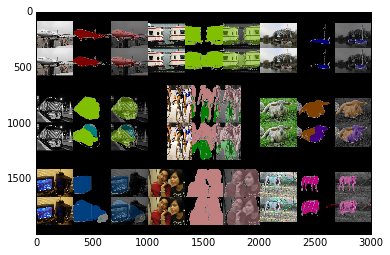






Train epoch=0:  94%|████████████████████▋ | 8001/8498 [27:51<2:33:03, 18.48s/it]




Train epoch=0:  94%|████████████████████▋ | 8002/8498 [27:51<1:47:22, 12.99s/it]




Train epoch=0:  94%|████████████████████▋ | 8003/8498 [27:51<1:15:27,  9.15s/it]




Train epoch=0:  94%|██████████████████████▌ | 8004/8498 [27:51<53:09,  6.46s/it]




Train epoch=0:  94%|██████████████████████▌ | 8005/8498 [27:52<37:33,  4.57s/it]




Train epoch=0:  94%|██████████████████████▌ | 8006/8498 [27:52<26:40,  3.25s/it]




Train epoch=0:  94%|██████████████████████▌ | 8007/8498 [27:52<19:04,  2.33s/it]




Train epoch=0:  94%|██████████████████████▌ | 8008/8498 [27:52<13:45,  1.69s/it]




Train epoch=0:  94%|██████████████████████▌ | 8009/8498 [27:52<10:04,  1.24s/it]




Train epoch=0:  94%|██████████████████████▌ | 8010/8498 [27:53<07:27,  1.09it/s]




Train epoch=0:  94%|██████████████████████▌ | 8011/8498 [27:53<05:36,  1.45it/s]




Train epoch=0:  94%|██████████████████████▋ | 8012/8498 [27:

Train epoch=0:  95%|██████████████████████▊ | 8082/8498 [28:06<01:15,  5.54it/s]




Train epoch=0:  95%|██████████████████████▊ | 8083/8498 [28:06<01:15,  5.52it/s]




Train epoch=0:  95%|██████████████████████▊ | 8084/8498 [28:06<01:15,  5.47it/s]




Train epoch=0:  95%|██████████████████████▊ | 8085/8498 [28:06<01:08,  6.01it/s]




Train epoch=0:  95%|██████████████████████▊ | 8086/8498 [28:06<01:10,  5.83it/s]




Train epoch=0:  95%|██████████████████████▊ | 8087/8498 [28:06<01:12,  5.69it/s]




Train epoch=0:  95%|██████████████████████▊ | 8088/8498 [28:07<01:12,  5.63it/s]




Train epoch=0:  95%|██████████████████████▊ | 8089/8498 [28:07<01:12,  5.63it/s]




Train epoch=0:  95%|██████████████████████▊ | 8090/8498 [28:07<01:13,  5.57it/s]




Train epoch=0:  95%|██████████████████████▊ | 8091/8498 [28:07<01:12,  5.58it/s]




Train epoch=0:  95%|██████████████████████▊ | 8092/8498 [28:07<01:12,  5.63it/s]




Train epoch=0:  95%|██████████████████████▊ | 8093/8498 [28:08<01

Train epoch=0:  96%|███████████████████████ | 8163/8498 [28:21<01:04,  5.19it/s]




Train epoch=0:  96%|███████████████████████ | 8164/8498 [28:21<01:05,  5.12it/s]




Train epoch=0:  96%|███████████████████████ | 8165/8498 [28:21<01:05,  5.06it/s]




Train epoch=0:  96%|███████████████████████ | 8166/8498 [28:21<01:06,  5.02it/s]




Train epoch=0:  96%|███████████████████████ | 8167/8498 [28:22<01:06,  4.98it/s]




Train epoch=0:  96%|███████████████████████ | 8168/8498 [28:22<01:05,  5.02it/s]




Train epoch=0:  96%|███████████████████████ | 8169/8498 [28:22<01:04,  5.11it/s]




Train epoch=0:  96%|███████████████████████ | 8170/8498 [28:22<01:04,  5.11it/s]




Train epoch=0:  96%|███████████████████████ | 8171/8498 [28:22<01:04,  5.07it/s]




Train epoch=0:  96%|███████████████████████ | 8172/8498 [28:22<01:03,  5.17it/s]




Train epoch=0:  96%|███████████████████████ | 8173/8498 [28:23<01:02,  5.19it/s]




Train epoch=0:  96%|███████████████████████ | 8174/8498 [28:23<01

Train epoch=0:  97%|███████████████████████▎| 8244/8498 [28:36<00:45,  5.55it/s]




Train epoch=0:  97%|███████████████████████▎| 8245/8498 [28:36<00:45,  5.52it/s]




Train epoch=0:  97%|███████████████████████▎| 8246/8498 [28:37<00:45,  5.55it/s]




Train epoch=0:  97%|███████████████████████▎| 8247/8498 [28:37<00:45,  5.51it/s]




Train epoch=0:  97%|███████████████████████▎| 8248/8498 [28:37<00:44,  5.58it/s]




Train epoch=0:  97%|███████████████████████▎| 8249/8498 [28:37<00:44,  5.56it/s]




Train epoch=0:  97%|███████████████████████▎| 8250/8498 [28:37<00:45,  5.48it/s]




Train epoch=0:  97%|███████████████████████▎| 8251/8498 [28:37<00:45,  5.46it/s]




Train epoch=0:  97%|███████████████████████▎| 8252/8498 [28:38<00:44,  5.53it/s]




Train epoch=0:  97%|███████████████████████▎| 8253/8498 [28:38<00:44,  5.51it/s]




Train epoch=0:  97%|███████████████████████▎| 8254/8498 [28:38<00:44,  5.46it/s]




Train epoch=0:  97%|███████████████████████▎| 8255/8498 [28:38<00

Train epoch=0:  98%|███████████████████████▌| 8325/8498 [28:51<00:33,  5.13it/s]




Train epoch=0:  98%|███████████████████████▌| 8326/8498 [28:51<00:32,  5.35it/s]




Train epoch=0:  98%|███████████████████████▌| 8327/8498 [28:52<00:31,  5.44it/s]




Train epoch=0:  98%|███████████████████████▌| 8328/8498 [28:52<00:30,  5.52it/s]




Train epoch=0:  98%|███████████████████████▌| 8329/8498 [28:52<00:30,  5.45it/s]




Train epoch=0:  98%|███████████████████████▌| 8330/8498 [28:52<00:31,  5.28it/s]




Train epoch=0:  98%|███████████████████████▌| 8331/8498 [28:52<00:31,  5.26it/s]




Train epoch=0:  98%|███████████████████████▌| 8332/8498 [28:52<00:29,  5.69it/s]




Train epoch=0:  98%|███████████████████████▌| 8333/8498 [28:53<00:29,  5.61it/s]




Train epoch=0:  98%|███████████████████████▌| 8334/8498 [28:53<00:29,  5.63it/s]




Train epoch=0:  98%|███████████████████████▌| 8335/8498 [28:53<00:29,  5.56it/s]




Train epoch=0:  98%|███████████████████████▌| 8336/8498 [28:53<00

Train epoch=0:  99%|███████████████████████▋| 8406/8498 [29:06<00:17,  5.32it/s]




Train epoch=0:  99%|███████████████████████▋| 8407/8498 [29:07<00:17,  5.23it/s]




Train epoch=0:  99%|███████████████████████▋| 8408/8498 [29:07<00:17,  5.25it/s]




Train epoch=0:  99%|███████████████████████▋| 8409/8498 [29:07<00:17,  5.20it/s]




Train epoch=0:  99%|███████████████████████▊| 8410/8498 [29:07<00:16,  5.21it/s]




Train epoch=0:  99%|███████████████████████▊| 8411/8498 [29:07<00:16,  5.36it/s]




Train epoch=0:  99%|███████████████████████▊| 8412/8498 [29:08<00:15,  5.39it/s]




Train epoch=0:  99%|███████████████████████▊| 8413/8498 [29:08<00:15,  5.39it/s]




Train epoch=0:  99%|███████████████████████▊| 8414/8498 [29:08<00:15,  5.33it/s]




Train epoch=0:  99%|███████████████████████▊| 8415/8498 [29:08<00:14,  5.61it/s]




Train epoch=0:  99%|███████████████████████▊| 8416/8498 [29:08<00:14,  5.53it/s]




Train epoch=0:  99%|███████████████████████▊| 8417/8498 [29:08<00

Train epoch=0: 100%|███████████████████████▉| 8487/8498 [29:21<00:01,  5.64it/s]




Train epoch=0: 100%|███████████████████████▉| 8488/8498 [29:22<00:01,  5.61it/s]




Train epoch=0: 100%|███████████████████████▉| 8489/8498 [29:22<00:01,  5.19it/s]




Train epoch=0: 100%|███████████████████████▉| 8490/8498 [29:22<00:01,  5.27it/s]




Train epoch=0: 100%|███████████████████████▉| 8491/8498 [29:22<00:01,  5.40it/s]




Train epoch=0: 100%|███████████████████████▉| 8492/8498 [29:22<00:01,  5.39it/s]




Train epoch=0: 100%|███████████████████████▉| 8493/8498 [29:23<00:00,  5.29it/s]




Train epoch=0: 100%|███████████████████████▉| 8494/8498 [29:23<00:00,  5.18it/s]




Train epoch=0: 100%|███████████████████████▉| 8495/8498 [29:23<00:00,  5.18it/s]




Train epoch=0: 100%|███████████████████████▉| 8496/8498 [29:23<00:00,  5.16it/s]




Train epoch=0: 100%|███████████████████████▉| 8497/8498 [29:23<00:00,  5.81it/s]




Train epoch=0: 100%|████████████████████████| 8498/8498 [29:23<00

Train epoch=1:   1%|▏                         | 68/8498 [00:12<25:45,  5.45it/s]




Train epoch=1:   1%|▏                         | 69/8498 [00:12<25:31,  5.50it/s]




Train epoch=1:   1%|▏                         | 70/8498 [00:13<25:17,  5.55it/s]




Train epoch=1:   1%|▏                         | 71/8498 [00:13<25:34,  5.49it/s]




Train epoch=1:   1%|▏                         | 72/8498 [00:13<26:17,  5.34it/s]




Train epoch=1:   1%|▏                         | 73/8498 [00:13<26:54,  5.22it/s]




Train epoch=1:   1%|▏                         | 74/8498 [00:13<27:29,  5.11it/s]




Train epoch=1:   1%|▏                         | 75/8498 [00:14<27:37,  5.08it/s]




Train epoch=1:   1%|▏                         | 76/8498 [00:14<27:52,  5.04it/s]




Train epoch=1:   1%|▏                         | 77/8498 [00:14<27:54,  5.03it/s]




Train epoch=1:   1%|▏                         | 78/8498 [00:14<27:34,  5.09it/s]




Train epoch=1:   1%|▏                         | 79/8498 [00:14<27

Train epoch=1:   2%|▍                        | 149/8498 [00:27<25:29,  5.46it/s]




Train epoch=1:   2%|▍                        | 150/8498 [00:28<25:30,  5.45it/s]




Train epoch=1:   2%|▍                        | 151/8498 [00:28<27:04,  5.14it/s]




Train epoch=1:   2%|▍                        | 152/8498 [00:28<26:35,  5.23it/s]




Train epoch=1:   2%|▍                        | 153/8498 [00:28<25:50,  5.38it/s]




Train epoch=1:   2%|▍                        | 154/8498 [00:28<25:29,  5.45it/s]




Train epoch=1:   2%|▍                        | 155/8498 [00:29<25:48,  5.39it/s]




Train epoch=1:   2%|▍                        | 156/8498 [00:29<25:02,  5.55it/s]




Train epoch=1:   2%|▍                        | 157/8498 [00:29<26:33,  5.23it/s]




Train epoch=1:   2%|▍                        | 158/8498 [00:29<25:55,  5.36it/s]




Train epoch=1:   2%|▍                        | 159/8498 [00:29<25:24,  5.47it/s]




Train epoch=1:   2%|▍                        | 160/8498 [00:29<25

Train epoch=1:   3%|▋                        | 230/8498 [00:43<25:19,  5.44it/s]




Train epoch=1:   3%|▋                        | 231/8498 [00:43<25:21,  5.43it/s]




Train epoch=1:   3%|▋                        | 232/8498 [00:43<25:25,  5.42it/s]




Train epoch=1:   3%|▋                        | 233/8498 [00:43<25:04,  5.50it/s]




Train epoch=1:   3%|▋                        | 234/8498 [00:43<24:48,  5.55it/s]




Train epoch=1:   3%|▋                        | 235/8498 [00:44<24:43,  5.57it/s]




Train epoch=1:   3%|▋                        | 236/8498 [00:44<24:51,  5.54it/s]




Train epoch=1:   3%|▋                        | 237/8498 [00:44<24:39,  5.58it/s]




Train epoch=1:   3%|▋                        | 238/8498 [00:44<24:56,  5.52it/s]




Train epoch=1:   3%|▋                        | 239/8498 [00:44<25:11,  5.46it/s]




Train epoch=1:   3%|▋                        | 240/8498 [00:44<24:27,  5.63it/s]




Train epoch=1:   3%|▋                        | 241/8498 [00:45<24

Train epoch=1:   4%|▉                        | 311/8498 [00:58<25:17,  5.39it/s]




Train epoch=1:   4%|▉                        | 312/8498 [00:58<26:00,  5.25it/s]




Train epoch=1:   4%|▉                        | 313/8498 [00:58<26:20,  5.18it/s]




Train epoch=1:   4%|▉                        | 314/8498 [00:58<26:46,  5.09it/s]




Train epoch=1:   4%|▉                        | 315/8498 [00:59<26:25,  5.16it/s]




Train epoch=1:   4%|▉                        | 316/8498 [00:59<26:59,  5.05it/s]




Train epoch=1:   4%|▉                        | 317/8498 [00:59<27:03,  5.04it/s]




Train epoch=1:   4%|▉                        | 318/8498 [00:59<27:10,  5.02it/s]




Train epoch=1:   4%|▉                        | 319/8498 [00:59<27:15,  5.00it/s]




Train epoch=1:   4%|▉                        | 320/8498 [01:00<27:01,  5.04it/s]




Train epoch=1:   4%|▉                        | 321/8498 [01:00<26:33,  5.13it/s]




Train epoch=1:   4%|▉                        | 322/8498 [01:00<26

Train epoch=1:   5%|█▏                       | 392/8498 [01:13<25:52,  5.22it/s]




Train epoch=1:   5%|█▏                       | 393/8498 [01:14<25:57,  5.20it/s]




Train epoch=1:   5%|█▏                       | 394/8498 [01:14<25:44,  5.25it/s]




Train epoch=1:   5%|█▏                       | 395/8498 [01:14<25:10,  5.37it/s]




Train epoch=1:   5%|█▏                       | 396/8498 [01:14<24:55,  5.42it/s]




Train epoch=1:   5%|█▏                       | 397/8498 [01:14<24:38,  5.48it/s]




Train epoch=1:   5%|█▏                       | 398/8498 [01:14<25:01,  5.39it/s]




Train epoch=1:   5%|█▏                       | 399/8498 [01:15<24:40,  5.47it/s]




Train epoch=1:   5%|█▏                       | 400/8498 [01:15<25:26,  5.30it/s]




Train epoch=1:   5%|█▏                       | 401/8498 [01:15<25:46,  5.23it/s]




Train epoch=1:   5%|█▏                       | 402/8498 [01:15<25:56,  5.20it/s]




Train epoch=1:   5%|█▏                       | 403/8498 [01:15<26

Train epoch=1:   6%|█▍                       | 473/8498 [01:29<25:38,  5.22it/s]




Train epoch=1:   6%|█▍                       | 474/8498 [01:29<25:27,  5.25it/s]




Train epoch=1:   6%|█▍                       | 475/8498 [01:29<25:17,  5.29it/s]




Train epoch=1:   6%|█▍                       | 476/8498 [01:29<25:07,  5.32it/s]




Train epoch=1:   6%|█▍                       | 477/8498 [01:29<25:08,  5.32it/s]




Train epoch=1:   6%|█▍                       | 478/8498 [01:29<25:05,  5.33it/s]




Train epoch=1:   6%|█▍                       | 479/8498 [01:30<24:52,  5.37it/s]




Train epoch=1:   6%|█▍                       | 480/8498 [01:30<24:37,  5.43it/s]




Train epoch=1:   6%|█▍                       | 481/8498 [01:30<24:10,  5.53it/s]




Train epoch=1:   6%|█▍                       | 482/8498 [01:30<24:18,  5.50it/s]




Train epoch=1:   6%|█▍                       | 483/8498 [01:30<24:14,  5.51it/s]




Train epoch=1:   6%|█▍                       | 484/8498 [01:31<23

Train epoch=1:   7%|█▋                       | 554/8498 [01:44<24:42,  5.36it/s]




Train epoch=1:   7%|█▋                       | 555/8498 [01:44<24:42,  5.36it/s]




Train epoch=1:   7%|█▋                       | 556/8498 [01:44<24:16,  5.45it/s]




Train epoch=1:   7%|█▋                       | 557/8498 [01:44<24:17,  5.45it/s]




Train epoch=1:   7%|█▋                       | 558/8498 [01:44<24:06,  5.49it/s]




Train epoch=1:   7%|█▋                       | 559/8498 [01:45<23:55,  5.53it/s]




Train epoch=1:   7%|█▋                       | 560/8498 [01:45<24:20,  5.43it/s]




Train epoch=1:   7%|█▋                       | 561/8498 [01:45<24:39,  5.36it/s]




Train epoch=1:   7%|█▋                       | 562/8498 [01:45<25:19,  5.22it/s]




Train epoch=1:   7%|█▋                       | 563/8498 [01:45<25:20,  5.22it/s]




Train epoch=1:   7%|█▋                       | 564/8498 [01:46<25:13,  5.24it/s]




Train epoch=1:   7%|█▋                       | 565/8498 [01:46<25

Train epoch=1:   7%|█▊                       | 635/8498 [01:59<25:16,  5.19it/s]




Train epoch=1:   7%|█▊                       | 636/8498 [01:59<25:33,  5.13it/s]




Train epoch=1:   7%|█▊                       | 637/8498 [01:59<25:30,  5.14it/s]




Train epoch=1:   8%|█▉                       | 638/8498 [01:59<24:57,  5.25it/s]




Train epoch=1:   8%|█▉                       | 639/8498 [02:00<24:26,  5.36it/s]




Train epoch=1:   8%|█▉                       | 640/8498 [02:00<24:13,  5.41it/s]




Train epoch=1:   8%|█▉                       | 641/8498 [02:00<24:06,  5.43it/s]




Train epoch=1:   8%|█▉                       | 642/8498 [02:00<23:49,  5.50it/s]




Train epoch=1:   8%|█▉                       | 643/8498 [02:00<22:33,  5.80it/s]




Train epoch=1:   8%|█▉                       | 644/8498 [02:01<23:07,  5.66it/s]




Train epoch=1:   8%|█▉                       | 645/8498 [02:01<22:51,  5.72it/s]




Train epoch=1:   8%|█▉                       | 646/8498 [02:01<23

Train epoch=1:   8%|██                       | 716/8498 [02:14<24:52,  5.21it/s]




Train epoch=1:   8%|██                       | 717/8498 [02:14<25:04,  5.17it/s]




Train epoch=1:   8%|██                       | 718/8498 [02:15<24:38,  5.26it/s]




Train epoch=1:   8%|██                       | 719/8498 [02:15<24:37,  5.27it/s]




Train epoch=1:   8%|██                       | 720/8498 [02:15<24:41,  5.25it/s]




Train epoch=1:   8%|██                       | 721/8498 [02:15<24:09,  5.37it/s]




Train epoch=1:   8%|██                       | 722/8498 [02:15<23:55,  5.42it/s]




Train epoch=1:   9%|██▏                      | 723/8498 [02:15<22:51,  5.67it/s]




Train epoch=1:   9%|██▏                      | 724/8498 [02:16<22:56,  5.65it/s]




Train epoch=1:   9%|██▏                      | 725/8498 [02:16<21:10,  6.12it/s]




Train epoch=1:   9%|██▏                      | 726/8498 [02:16<21:47,  5.94it/s]




Train epoch=1:   9%|██▏                      | 727/8498 [02:16<21

Train epoch=1:   9%|██▎                      | 797/8498 [02:29<25:05,  5.12it/s]




Train epoch=1:   9%|██▎                      | 798/8498 [02:30<24:19,  5.27it/s]




Train epoch=1:   9%|██▎                      | 799/8498 [02:30<23:40,  5.42it/s]




Train epoch=1:   9%|██▎                      | 800/8498 [02:30<23:36,  5.43it/s]




Train epoch=1:   9%|██▎                      | 801/8498 [02:30<23:13,  5.52it/s]




Train epoch=1:   9%|██▎                      | 802/8498 [02:30<22:38,  5.67it/s]




Train epoch=1:   9%|██▎                      | 803/8498 [02:30<23:03,  5.56it/s]




Train epoch=1:   9%|██▎                      | 804/8498 [02:31<23:13,  5.52it/s]




Train epoch=1:   9%|██▎                      | 805/8498 [02:31<23:17,  5.50it/s]




Train epoch=1:   9%|██▎                      | 806/8498 [02:31<23:52,  5.37it/s]




Train epoch=1:   9%|██▎                      | 807/8498 [02:31<23:44,  5.40it/s]




Train epoch=1:  10%|██▍                      | 808/8498 [02:31<23

Train epoch=1:  10%|██▌                      | 878/8498 [02:45<22:57,  5.53it/s]




Train epoch=1:  10%|██▌                      | 879/8498 [02:45<22:40,  5.60it/s]




Train epoch=1:  10%|██▌                      | 880/8498 [02:45<23:03,  5.51it/s]




Train epoch=1:  10%|██▌                      | 881/8498 [02:45<23:53,  5.31it/s]




Train epoch=1:  10%|██▌                      | 882/8498 [02:45<23:53,  5.31it/s]




Train epoch=1:  10%|██▌                      | 883/8498 [02:46<24:24,  5.20it/s]




Train epoch=1:  10%|██▌                      | 884/8498 [02:46<24:41,  5.14it/s]




Train epoch=1:  10%|██▌                      | 885/8498 [02:46<23:54,  5.31it/s]




Train epoch=1:  10%|██▌                      | 886/8498 [02:46<23:48,  5.33it/s]




Train epoch=1:  10%|██▌                      | 887/8498 [02:46<23:59,  5.29it/s]




Train epoch=1:  10%|██▌                      | 888/8498 [02:47<24:07,  5.26it/s]




Train epoch=1:  10%|██▌                      | 889/8498 [02:47<24

Train epoch=1:  11%|██▊                      | 959/8498 [03:00<22:47,  5.51it/s]




Train epoch=1:  11%|██▊                      | 960/8498 [03:00<22:52,  5.49it/s]




Train epoch=1:  11%|██▊                      | 961/8498 [03:00<22:43,  5.53it/s]




Train epoch=1:  11%|██▊                      | 962/8498 [03:00<22:24,  5.60it/s]




Train epoch=1:  11%|██▊                      | 963/8498 [03:01<22:40,  5.54it/s]




Train epoch=1:  11%|██▊                      | 964/8498 [03:01<23:33,  5.33it/s]




Train epoch=1:  11%|██▊                      | 965/8498 [03:01<23:05,  5.44it/s]




Train epoch=1:  11%|██▊                      | 966/8498 [03:01<23:38,  5.31it/s]




Train epoch=1:  11%|██▊                      | 967/8498 [03:01<24:08,  5.20it/s]




Train epoch=1:  11%|██▊                      | 968/8498 [03:02<24:02,  5.22it/s]




Train epoch=1:  11%|██▊                      | 969/8498 [03:02<24:20,  5.16it/s]




Train epoch=1:  11%|██▊                      | 970/8498 [03:02<24

Train epoch=1:  12%|██▉                     | 1040/8498 [03:15<23:06,  5.38it/s]




Train epoch=1:  12%|██▉                     | 1041/8498 [03:15<22:54,  5.43it/s]




Train epoch=1:  12%|██▉                     | 1042/8498 [03:16<22:56,  5.42it/s]




Train epoch=1:  12%|██▉                     | 1043/8498 [03:16<22:34,  5.50it/s]




Train epoch=1:  12%|██▉                     | 1044/8498 [03:16<22:39,  5.48it/s]




Train epoch=1:  12%|██▉                     | 1045/8498 [03:16<22:16,  5.58it/s]




Train epoch=1:  12%|██▉                     | 1046/8498 [03:16<22:42,  5.47it/s]




Train epoch=1:  12%|██▉                     | 1047/8498 [03:17<23:14,  5.34it/s]




Train epoch=1:  12%|██▉                     | 1048/8498 [03:17<23:42,  5.24it/s]




Train epoch=1:  12%|██▉                     | 1049/8498 [03:17<24:12,  5.13it/s]




Train epoch=1:  12%|██▉                     | 1050/8498 [03:17<24:26,  5.08it/s]




Train epoch=1:  12%|██▉                     | 1051/8498 [03:17<24

Train epoch=1:  13%|███▏                    | 1122/8498 [03:31<24:07,  5.10it/s]




Train epoch=1:  13%|███▏                    | 1123/8498 [03:31<24:19,  5.05it/s]




Train epoch=1:  13%|███▏                    | 1124/8498 [03:31<24:04,  5.10it/s]




Train epoch=1:  13%|███▏                    | 1125/8498 [03:31<24:14,  5.07it/s]




Train epoch=1:  13%|███▏                    | 1126/8498 [03:31<23:57,  5.13it/s]




Train epoch=1:  13%|███▏                    | 1127/8498 [03:32<23:53,  5.14it/s]




Train epoch=1:  13%|███▏                    | 1128/8498 [03:32<23:40,  5.19it/s]




Train epoch=1:  13%|███▏                    | 1129/8498 [03:32<23:29,  5.23it/s]




Train epoch=1:  13%|███▏                    | 1130/8498 [03:32<23:21,  5.26it/s]




Train epoch=1:  13%|███▏                    | 1131/8498 [03:32<23:02,  5.33it/s]




Train epoch=1:  13%|███▏                    | 1132/8498 [03:33<22:49,  5.38it/s]




Train epoch=1:  13%|███▏                    | 1133/8498 [03:33<22

Train epoch=1:  14%|███▍                    | 1203/8498 [03:46<22:23,  5.43it/s]




Train epoch=1:  14%|███▍                    | 1204/8498 [03:46<22:48,  5.33it/s]




Train epoch=1:  14%|███▍                    | 1205/8498 [03:46<22:23,  5.43it/s]




Train epoch=1:  14%|███▍                    | 1206/8498 [03:46<22:56,  5.30it/s]




Train epoch=1:  14%|███▍                    | 1207/8498 [03:46<23:15,  5.22it/s]




Train epoch=1:  14%|███▍                    | 1208/8498 [03:47<22:47,  5.33it/s]




Train epoch=1:  14%|███▍                    | 1209/8498 [03:47<22:42,  5.35it/s]




Train epoch=1:  14%|███▍                    | 1210/8498 [03:47<22:25,  5.42it/s]




Train epoch=1:  14%|███▍                    | 1211/8498 [03:47<22:27,  5.41it/s]




Train epoch=1:  14%|███▍                    | 1212/8498 [03:47<22:30,  5.40it/s]




Train epoch=1:  14%|███▍                    | 1213/8498 [03:48<22:09,  5.48it/s]




Train epoch=1:  14%|███▍                    | 1214/8498 [03:48<21

Train epoch=1:  15%|███▋                    | 1285/8498 [04:01<23:41,  5.08it/s]




Train epoch=1:  15%|███▋                    | 1286/8498 [04:01<23:29,  5.12it/s]




Train epoch=1:  15%|███▋                    | 1287/8498 [04:01<23:17,  5.16it/s]




Train epoch=1:  15%|███▋                    | 1288/8498 [04:02<23:46,  5.05it/s]




Train epoch=1:  15%|███▋                    | 1289/8498 [04:02<23:18,  5.15it/s]




Train epoch=1:  15%|███▋                    | 1290/8498 [04:02<23:10,  5.18it/s]




Train epoch=1:  15%|███▋                    | 1291/8498 [04:02<22:56,  5.24it/s]




Train epoch=1:  15%|███▋                    | 1292/8498 [04:02<22:18,  5.38it/s]




Train epoch=1:  15%|███▋                    | 1293/8498 [04:02<22:15,  5.40it/s]




Train epoch=1:  15%|███▋                    | 1294/8498 [04:03<22:13,  5.40it/s]




Train epoch=1:  15%|███▋                    | 1295/8498 [04:03<20:27,  5.87it/s]




Train epoch=1:  15%|███▋                    | 1296/8498 [04:03<20

Train epoch=1:  16%|███▊                    | 1366/8498 [04:16<21:52,  5.43it/s]




Train epoch=1:  16%|███▊                    | 1367/8498 [04:16<21:52,  5.43it/s]




Train epoch=1:  16%|███▊                    | 1368/8498 [04:16<21:33,  5.51it/s]




Train epoch=1:  16%|███▊                    | 1369/8498 [04:17<21:43,  5.47it/s]




Train epoch=1:  16%|███▊                    | 1370/8498 [04:17<22:09,  5.36it/s]




Train epoch=1:  16%|███▊                    | 1371/8498 [04:17<22:50,  5.20it/s]




Train epoch=1:  16%|███▊                    | 1372/8498 [04:17<23:06,  5.14it/s]




Train epoch=1:  16%|███▉                    | 1373/8498 [04:17<22:51,  5.19it/s]




Train epoch=1:  16%|███▉                    | 1374/8498 [04:18<22:40,  5.23it/s]




Train epoch=1:  16%|███▉                    | 1375/8498 [04:18<22:24,  5.30it/s]




Train epoch=1:  16%|███▉                    | 1376/8498 [04:18<22:10,  5.35it/s]




Train epoch=1:  16%|███▉                    | 1377/8498 [04:18<21

Train epoch=1:  17%|████                    | 1447/8498 [04:31<22:04,  5.32it/s]




Train epoch=1:  17%|████                    | 1448/8498 [04:31<22:31,  5.22it/s]




Train epoch=1:  17%|████                    | 1449/8498 [04:32<22:46,  5.16it/s]




Train epoch=1:  17%|████                    | 1450/8498 [04:32<22:35,  5.20it/s]




Train epoch=1:  17%|████                    | 1451/8498 [04:32<22:39,  5.18it/s]




Train epoch=1:  17%|████                    | 1452/8498 [04:32<22:33,  5.21it/s]




Train epoch=1:  17%|████                    | 1453/8498 [04:32<21:37,  5.43it/s]




Train epoch=1:  17%|████                    | 1454/8498 [04:33<21:34,  5.44it/s]




Train epoch=1:  17%|████                    | 1455/8498 [04:33<21:16,  5.52it/s]




Train epoch=1:  17%|████                    | 1456/8498 [04:33<21:25,  5.48it/s]




Train epoch=1:  17%|████                    | 1457/8498 [04:33<21:15,  5.52it/s]




Train epoch=1:  17%|████                    | 1458/8498 [04:33<21

Train epoch=1:  18%|████▎                   | 1528/8498 [04:46<21:13,  5.47it/s]




Train epoch=1:  18%|████▎                   | 1529/8498 [04:46<21:16,  5.46it/s]




Train epoch=1:  18%|████▎                   | 1530/8498 [04:47<21:02,  5.52it/s]




Train epoch=1:  18%|████▎                   | 1531/8498 [04:47<21:46,  5.33it/s]




Train epoch=1:  18%|████▎                   | 1532/8498 [04:47<21:53,  5.30it/s]




Train epoch=1:  18%|████▎                   | 1533/8498 [04:47<21:42,  5.35it/s]




Train epoch=1:  18%|████▎                   | 1534/8498 [04:47<21:24,  5.42it/s]




Train epoch=1:  18%|████▎                   | 1535/8498 [04:48<21:29,  5.40it/s]




Train epoch=1:  18%|████▎                   | 1536/8498 [04:48<21:25,  5.42it/s]




Train epoch=1:  18%|████▎                   | 1537/8498 [04:48<21:34,  5.38it/s]




Train epoch=1:  18%|████▎                   | 1538/8498 [04:48<21:36,  5.37it/s]




Train epoch=1:  18%|████▎                   | 1539/8498 [04:48<21

Train epoch=1:  19%|████▌                   | 1609/8498 [05:01<22:10,  5.18it/s]




Train epoch=1:  19%|████▌                   | 1610/8498 [05:01<21:08,  5.43it/s]




Train epoch=1:  19%|████▌                   | 1611/8498 [05:02<21:10,  5.42it/s]




Train epoch=1:  19%|████▌                   | 1612/8498 [05:02<21:08,  5.43it/s]




Train epoch=1:  19%|████▌                   | 1613/8498 [05:02<20:18,  5.65it/s]




Train epoch=1:  19%|████▌                   | 1614/8498 [05:02<20:10,  5.69it/s]




Train epoch=1:  19%|████▌                   | 1615/8498 [05:02<18:53,  6.07it/s]




Train epoch=1:  19%|████▌                   | 1616/8498 [05:02<19:31,  5.87it/s]




Train epoch=1:  19%|████▌                   | 1617/8498 [05:03<19:42,  5.82it/s]




Train epoch=1:  19%|████▌                   | 1618/8498 [05:03<19:50,  5.78it/s]




Train epoch=1:  19%|████▌                   | 1619/8498 [05:03<19:24,  5.91it/s]




Train epoch=1:  19%|████▌                   | 1620/8498 [05:03<18

Train epoch=1:  20%|████▊                   | 1691/8498 [05:16<22:31,  5.04it/s]




Train epoch=1:  20%|████▊                   | 1692/8498 [05:17<22:19,  5.08it/s]




Train epoch=1:  20%|████▊                   | 1693/8498 [05:17<21:56,  5.17it/s]




Train epoch=1:  20%|████▊                   | 1694/8498 [05:17<21:18,  5.32it/s]




Train epoch=1:  20%|████▊                   | 1695/8498 [05:17<21:18,  5.32it/s]




Train epoch=1:  20%|████▊                   | 1696/8498 [05:17<21:14,  5.34it/s]




Train epoch=1:  20%|████▊                   | 1697/8498 [05:17<21:02,  5.39it/s]




Train epoch=1:  20%|████▊                   | 1698/8498 [05:18<21:05,  5.37it/s]




Train epoch=1:  20%|████▊                   | 1699/8498 [05:18<20:39,  5.48it/s]




Train epoch=1:  20%|████▊                   | 1700/8498 [05:18<20:36,  5.50it/s]




Train epoch=1:  20%|████▊                   | 1701/8498 [05:18<20:49,  5.44it/s]




Train epoch=1:  20%|████▊                   | 1702/8498 [05:18<21

Train epoch=1:  21%|█████                   | 1772/8498 [05:32<20:39,  5.43it/s]




Train epoch=1:  21%|█████                   | 1773/8498 [05:32<20:27,  5.48it/s]




Train epoch=1:  21%|█████                   | 1774/8498 [05:32<20:24,  5.49it/s]




Train epoch=1:  21%|█████                   | 1775/8498 [05:32<20:33,  5.45it/s]




Train epoch=1:  21%|█████                   | 1776/8498 [05:32<21:08,  5.30it/s]




Train epoch=1:  21%|█████                   | 1777/8498 [05:33<21:36,  5.18it/s]




Train epoch=1:  21%|█████                   | 1778/8498 [05:33<21:49,  5.13it/s]




Train epoch=1:  21%|█████                   | 1779/8498 [05:33<21:44,  5.15it/s]




Train epoch=1:  21%|█████                   | 1780/8498 [05:33<21:25,  5.23it/s]




Train epoch=1:  21%|█████                   | 1781/8498 [05:33<21:11,  5.28it/s]




Train epoch=1:  21%|█████                   | 1782/8498 [05:33<20:06,  5.56it/s]




Train epoch=1:  21%|█████                   | 1783/8498 [05:34<20

Train epoch=1:  22%|█████▏                  | 1853/8498 [05:47<22:11,  4.99it/s]




Train epoch=1:  22%|█████▏                  | 1854/8498 [05:47<22:12,  4.99it/s]




Train epoch=1:  22%|█████▏                  | 1855/8498 [05:47<22:15,  4.97it/s]




Train epoch=1:  22%|█████▏                  | 1856/8498 [05:47<22:20,  4.96it/s]




Train epoch=1:  22%|█████▏                  | 1857/8498 [05:48<22:08,  5.00it/s]




Train epoch=1:  22%|█████▏                  | 1858/8498 [05:48<21:53,  5.06it/s]




Train epoch=1:  22%|█████▎                  | 1859/8498 [05:48<21:16,  5.20it/s]




Train epoch=1:  22%|█████▎                  | 1860/8498 [05:48<20:47,  5.32it/s]




Train epoch=1:  22%|█████▎                  | 1861/8498 [05:48<20:25,  5.42it/s]




Train epoch=1:  22%|█████▎                  | 1862/8498 [05:49<20:04,  5.51it/s]




Train epoch=1:  22%|█████▎                  | 1863/8498 [05:49<19:46,  5.59it/s]




Train epoch=1:  22%|█████▎                  | 1864/8498 [05:49<20

Train epoch=1:  23%|█████▍                  | 1934/8498 [06:02<19:55,  5.49it/s]




Train epoch=1:  23%|█████▍                  | 1935/8498 [06:02<20:00,  5.47it/s]




Train epoch=1:  23%|█████▍                  | 1936/8498 [06:02<19:20,  5.66it/s]




Train epoch=1:  23%|█████▍                  | 1937/8498 [06:02<20:21,  5.37it/s]




Train epoch=1:  23%|█████▍                  | 1938/8498 [06:03<20:44,  5.27it/s]




Train epoch=1:  23%|█████▍                  | 1939/8498 [06:03<20:48,  5.25it/s]




Train epoch=1:  23%|█████▍                  | 1940/8498 [06:03<20:33,  5.32it/s]




Train epoch=1:  23%|█████▍                  | 1941/8498 [06:03<20:09,  5.42it/s]




Train epoch=1:  23%|█████▍                  | 1942/8498 [06:03<19:52,  5.50it/s]




Train epoch=1:  23%|█████▍                  | 1943/8498 [06:04<19:32,  5.59it/s]




Train epoch=1:  23%|█████▍                  | 1944/8498 [06:04<19:43,  5.54it/s]




Train epoch=1:  23%|█████▍                  | 1945/8498 [06:04<19

Train epoch=1:  24%|█████▋                  | 2015/8498 [06:17<19:03,  5.67it/s]




Train epoch=1:  24%|█████▋                  | 2016/8498 [06:17<19:29,  5.54it/s]




Train epoch=1:  24%|█████▋                  | 2017/8498 [06:17<19:22,  5.58it/s]




Train epoch=1:  24%|█████▋                  | 2018/8498 [06:18<19:16,  5.60it/s]




Train epoch=1:  24%|█████▋                  | 2019/8498 [06:18<19:25,  5.56it/s]




Train epoch=1:  24%|█████▋                  | 2020/8498 [06:18<19:37,  5.50it/s]




Train epoch=1:  24%|█████▋                  | 2021/8498 [06:18<19:38,  5.50it/s]




Train epoch=1:  24%|█████▋                  | 2022/8498 [06:18<19:45,  5.46it/s]




Train epoch=1:  24%|█████▋                  | 2023/8498 [06:19<20:22,  5.30it/s]




Train epoch=1:  24%|█████▋                  | 2024/8498 [06:19<20:36,  5.24it/s]




Train epoch=1:  24%|█████▋                  | 2025/8498 [06:19<20:35,  5.24it/s]




Train epoch=1:  24%|█████▋                  | 2026/8498 [06:19<20

Train epoch=1:  25%|█████▉                  | 2096/8498 [06:32<19:36,  5.44it/s]




Train epoch=1:  25%|█████▉                  | 2097/8498 [06:33<19:38,  5.43it/s]




Train epoch=1:  25%|█████▉                  | 2098/8498 [06:33<19:37,  5.44it/s]




Train epoch=1:  25%|█████▉                  | 2099/8498 [06:33<19:24,  5.50it/s]




Train epoch=1:  25%|█████▉                  | 2100/8498 [06:33<20:02,  5.32it/s]




Train epoch=1:  25%|█████▉                  | 2101/8498 [06:33<20:25,  5.22it/s]




Train epoch=1:  25%|█████▉                  | 2102/8498 [06:34<20:26,  5.21it/s]




Train epoch=1:  25%|█████▉                  | 2103/8498 [06:34<20:39,  5.16it/s]




Train epoch=1:  25%|█████▉                  | 2104/8498 [06:34<20:57,  5.09it/s]




Train epoch=1:  25%|█████▉                  | 2105/8498 [06:34<21:01,  5.07it/s]




Train epoch=1:  25%|█████▉                  | 2106/8498 [06:34<20:39,  5.16it/s]




Train epoch=1:  25%|█████▉                  | 2107/8498 [06:35<20

Train epoch=1:  26%|██████▏                 | 2177/8498 [06:48<20:08,  5.23it/s]




Train epoch=1:  26%|██████▏                 | 2178/8498 [06:48<19:02,  5.53it/s]




Train epoch=1:  26%|██████▏                 | 2179/8498 [06:48<19:25,  5.42it/s]




Train epoch=1:  26%|██████▏                 | 2180/8498 [06:48<19:38,  5.36it/s]




Train epoch=1:  26%|██████▏                 | 2181/8498 [06:48<19:57,  5.28it/s]




Train epoch=1:  26%|██████▏                 | 2182/8498 [06:49<19:55,  5.28it/s]




Train epoch=1:  26%|██████▏                 | 2183/8498 [06:49<19:35,  5.37it/s]




Train epoch=1:  26%|██████▏                 | 2184/8498 [06:49<19:36,  5.37it/s]




Train epoch=1:  26%|██████▏                 | 2185/8498 [06:49<19:41,  5.34it/s]




Train epoch=1:  26%|██████▏                 | 2186/8498 [06:49<19:55,  5.28it/s]




Train epoch=1:  26%|██████▏                 | 2187/8498 [06:50<19:59,  5.26it/s]




Train epoch=1:  26%|██████▏                 | 2188/8498 [06:50<19

Train epoch=1:  27%|██████▍                 | 2258/8498 [07:03<18:12,  5.71it/s]




Train epoch=1:  27%|██████▍                 | 2259/8498 [07:03<18:49,  5.52it/s]




Train epoch=1:  27%|██████▍                 | 2260/8498 [07:03<19:05,  5.44it/s]




Train epoch=1:  27%|██████▍                 | 2261/8498 [07:03<18:56,  5.49it/s]




Train epoch=1:  27%|██████▍                 | 2262/8498 [07:04<19:00,  5.47it/s]




Train epoch=1:  27%|██████▍                 | 2263/8498 [07:04<19:04,  5.45it/s]




Train epoch=1:  27%|██████▍                 | 2264/8498 [07:04<18:50,  5.51it/s]




Train epoch=1:  27%|██████▍                 | 2265/8498 [07:04<19:03,  5.45it/s]




Train epoch=1:  27%|██████▍                 | 2266/8498 [07:04<18:53,  5.50it/s]




Train epoch=1:  27%|██████▍                 | 2267/8498 [07:04<19:08,  5.42it/s]




Train epoch=1:  27%|██████▍                 | 2268/8498 [07:05<19:41,  5.27it/s]




Train epoch=1:  27%|██████▍                 | 2269/8498 [07:05<18

Train epoch=1:  28%|██████▌                 | 2339/8498 [07:18<20:24,  5.03it/s]




Train epoch=1:  28%|██████▌                 | 2340/8498 [07:18<20:26,  5.02it/s]




Train epoch=1:  28%|██████▌                 | 2341/8498 [07:19<20:09,  5.09it/s]




Train epoch=1:  28%|██████▌                 | 2342/8498 [07:19<19:39,  5.22it/s]




Train epoch=1:  28%|██████▌                 | 2343/8498 [07:19<19:32,  5.25it/s]




Train epoch=1:  28%|██████▌                 | 2344/8498 [07:19<19:16,  5.32it/s]




Train epoch=1:  28%|██████▌                 | 2345/8498 [07:19<18:54,  5.42it/s]




Train epoch=1:  28%|██████▋                 | 2346/8498 [07:19<18:46,  5.46it/s]




Train epoch=1:  28%|██████▋                 | 2347/8498 [07:20<18:39,  5.50it/s]




Train epoch=1:  28%|██████▋                 | 2348/8498 [07:20<19:12,  5.34it/s]




Train epoch=1:  28%|██████▋                 | 2349/8498 [07:20<20:14,  5.06it/s]




Train epoch=1:  28%|██████▋                 | 2350/8498 [07:20<20

Train epoch=1:  28%|██████▊                 | 2420/8498 [07:33<19:17,  5.25it/s]




Train epoch=1:  28%|██████▊                 | 2421/8498 [07:34<19:04,  5.31it/s]




Train epoch=1:  29%|██████▊                 | 2422/8498 [07:34<18:41,  5.42it/s]




Train epoch=1:  29%|██████▊                 | 2423/8498 [07:34<18:40,  5.42it/s]




Train epoch=1:  29%|██████▊                 | 2424/8498 [07:34<18:54,  5.35it/s]




Train epoch=1:  29%|██████▊                 | 2425/8498 [07:34<19:20,  5.23it/s]




Train epoch=1:  29%|██████▊                 | 2426/8498 [07:35<19:43,  5.13it/s]




Train epoch=1:  29%|██████▊                 | 2427/8498 [07:35<19:48,  5.11it/s]




Train epoch=1:  29%|██████▊                 | 2428/8498 [07:35<19:40,  5.14it/s]




Train epoch=1:  29%|██████▊                 | 2429/8498 [07:35<19:05,  5.30it/s]




Train epoch=1:  29%|██████▊                 | 2430/8498 [07:35<19:09,  5.28it/s]




Train epoch=1:  29%|██████▊                 | 2431/8498 [07:36<19

Train epoch=1:  29%|███████                 | 2501/8498 [07:49<19:57,  5.01it/s]




Train epoch=1:  29%|███████                 | 2502/8498 [07:49<18:43,  5.34it/s]




Train epoch=1:  29%|███████                 | 2503/8498 [07:49<18:13,  5.48it/s]




Train epoch=1:  29%|███████                 | 2504/8498 [07:49<18:03,  5.53it/s]




Train epoch=1:  29%|███████                 | 2505/8498 [07:50<18:06,  5.51it/s]




Train epoch=1:  29%|███████                 | 2506/8498 [07:50<18:29,  5.40it/s]




Train epoch=1:  30%|███████                 | 2507/8498 [07:50<18:26,  5.42it/s]




Train epoch=1:  30%|███████                 | 2508/8498 [07:50<18:07,  5.51it/s]




Train epoch=1:  30%|███████                 | 2509/8498 [07:50<18:36,  5.36it/s]




Train epoch=1:  30%|███████                 | 2510/8498 [07:51<18:44,  5.32it/s]




Train epoch=1:  30%|███████                 | 2511/8498 [07:51<19:08,  5.21it/s]




Train epoch=1:  30%|███████                 | 2512/8498 [07:51<19

Train epoch=1:  30%|███████▎                | 2582/8498 [08:04<18:42,  5.27it/s]




Train epoch=1:  30%|███████▎                | 2583/8498 [08:04<19:53,  4.95it/s]




Train epoch=1:  30%|███████▎                | 2584/8498 [08:05<18:45,  5.25it/s]




Train epoch=1:  30%|███████▎                | 2585/8498 [08:05<18:53,  5.22it/s]




Train epoch=1:  30%|███████▎                | 2586/8498 [08:05<18:47,  5.24it/s]




Train epoch=1:  30%|███████▎                | 2587/8498 [08:05<18:44,  5.25it/s]




Train epoch=1:  30%|███████▎                | 2588/8498 [08:05<18:27,  5.33it/s]




Train epoch=1:  30%|███████▎                | 2589/8498 [08:05<17:19,  5.69it/s]




Train epoch=1:  30%|███████▎                | 2590/8498 [08:06<17:33,  5.61it/s]




Train epoch=1:  30%|███████▎                | 2591/8498 [08:06<17:30,  5.62it/s]




Train epoch=1:  31%|███████▎                | 2592/8498 [08:06<17:22,  5.66it/s]




Train epoch=1:  31%|███████▎                | 2593/8498 [08:06<17

Train epoch=1:  31%|███████▌                | 2663/8498 [08:20<18:52,  5.15it/s]




Train epoch=1:  31%|███████▌                | 2664/8498 [08:20<18:30,  5.25it/s]




Train epoch=1:  31%|███████▌                | 2665/8498 [08:20<18:24,  5.28it/s]




Train epoch=1:  31%|███████▌                | 2666/8498 [08:20<18:12,  5.34it/s]




Train epoch=1:  31%|███████▌                | 2667/8498 [08:20<18:07,  5.36it/s]




Train epoch=1:  31%|███████▌                | 2668/8498 [08:20<18:31,  5.25it/s]




Train epoch=1:  31%|███████▌                | 2669/8498 [08:21<18:50,  5.15it/s]




Train epoch=1:  31%|███████▌                | 2670/8498 [08:21<19:05,  5.09it/s]




Train epoch=1:  31%|███████▌                | 2671/8498 [08:21<18:58,  5.12it/s]




Train epoch=1:  31%|███████▌                | 2672/8498 [08:21<18:51,  5.15it/s]




Train epoch=1:  31%|███████▌                | 2673/8498 [08:21<18:59,  5.11it/s]




Train epoch=1:  31%|███████▌                | 2674/8498 [08:22<18

Train epoch=1:  32%|███████▊                | 2745/8498 [08:35<19:01,  5.04it/s]




Train epoch=1:  32%|███████▊                | 2746/8498 [08:35<19:18,  4.97it/s]




Train epoch=1:  32%|███████▊                | 2747/8498 [08:36<19:04,  5.02it/s]




Train epoch=1:  32%|███████▊                | 2748/8498 [08:36<19:00,  5.04it/s]




Train epoch=1:  32%|███████▊                | 2749/8498 [08:36<18:51,  5.08it/s]




Train epoch=1:  32%|███████▊                | 2750/8498 [08:36<18:21,  5.22it/s]




Train epoch=1:  32%|███████▊                | 2751/8498 [08:36<17:48,  5.38it/s]




Train epoch=1:  32%|███████▊                | 2752/8498 [08:36<16:54,  5.66it/s]




Train epoch=1:  32%|███████▊                | 2753/8498 [08:37<17:08,  5.59it/s]




Train epoch=1:  32%|███████▊                | 2754/8498 [08:37<17:43,  5.40it/s]




Train epoch=1:  32%|███████▊                | 2755/8498 [08:37<17:43,  5.40it/s]




Train epoch=1:  32%|███████▊                | 2756/8498 [08:37<18

Train epoch=1:  33%|███████▉                | 2826/8498 [08:50<17:16,  5.47it/s]




Train epoch=1:  33%|███████▉                | 2827/8498 [08:51<17:09,  5.51it/s]




Train epoch=1:  33%|███████▉                | 2828/8498 [08:51<17:35,  5.37it/s]




Train epoch=1:  33%|███████▉                | 2829/8498 [08:51<18:04,  5.23it/s]




Train epoch=1:  33%|███████▉                | 2830/8498 [08:51<18:24,  5.13it/s]




Train epoch=1:  33%|███████▉                | 2831/8498 [08:51<18:35,  5.08it/s]




Train epoch=1:  33%|███████▉                | 2832/8498 [08:52<18:37,  5.07it/s]




Train epoch=1:  33%|████████                | 2833/8498 [08:52<18:17,  5.16it/s]




Train epoch=1:  33%|████████                | 2834/8498 [08:52<18:11,  5.19it/s]




Train epoch=1:  33%|████████                | 2835/8498 [08:52<17:42,  5.33it/s]




Train epoch=1:  33%|████████                | 2836/8498 [08:52<17:36,  5.36it/s]




Train epoch=1:  33%|████████                | 2837/8498 [08:52<17

Train epoch=1:  34%|████████▏               | 2907/8498 [09:05<16:17,  5.72it/s]




Train epoch=1:  34%|████████▏               | 2908/8498 [09:06<17:01,  5.47it/s]




Train epoch=1:  34%|████████▏               | 2909/8498 [09:06<17:21,  5.37it/s]




Train epoch=1:  34%|████████▏               | 2910/8498 [09:06<17:25,  5.35it/s]




Train epoch=1:  34%|████████▏               | 2911/8498 [09:06<17:14,  5.40it/s]




Train epoch=1:  34%|████████▏               | 2912/8498 [09:06<17:12,  5.41it/s]




Train epoch=1:  34%|████████▏               | 2913/8498 [09:06<17:07,  5.44it/s]




Train epoch=1:  34%|████████▏               | 2914/8498 [09:07<17:06,  5.44it/s]




Train epoch=1:  34%|████████▏               | 2915/8498 [09:07<17:43,  5.25it/s]




Train epoch=1:  34%|████████▏               | 2916/8498 [09:07<17:33,  5.30it/s]




Train epoch=1:  34%|████████▏               | 2917/8498 [09:07<17:42,  5.25it/s]




Train epoch=1:  34%|████████▏               | 2918/8498 [09:07<17

Train epoch=1:  35%|████████▍               | 2988/8498 [09:20<17:09,  5.35it/s]




Train epoch=1:  35%|████████▍               | 2989/8498 [09:21<17:21,  5.29it/s]




Train epoch=1:  35%|████████▍               | 2990/8498 [09:21<17:15,  5.32it/s]




Train epoch=1:  35%|████████▍               | 2991/8498 [09:21<17:12,  5.33it/s]




Train epoch=1:  35%|████████▍               | 2992/8498 [09:21<17:09,  5.35it/s]




Train epoch=1:  35%|████████▍               | 2993/8498 [09:21<17:02,  5.38it/s]




Train epoch=1:  35%|████████▍               | 2994/8498 [09:22<16:45,  5.47it/s]




Train epoch=1:  35%|████████▍               | 2995/8498 [09:22<15:09,  6.05it/s]




Train epoch=1:  35%|████████▍               | 2996/8498 [09:22<15:09,  6.05it/s]




Train epoch=1:  35%|████████▍               | 2997/8498 [09:22<14:54,  6.15it/s]




Train epoch=1:  35%|████████▍               | 2998/8498 [09:22<15:31,  5.91it/s]




Train epoch=1:  35%|████████▍               | 2999/8498 [09:22<15

Train epoch=1:  36%|████████▋               | 3069/8498 [09:35<17:12,  5.26it/s]




Train epoch=1:  36%|████████▋               | 3070/8498 [09:36<17:32,  5.16it/s]




Train epoch=1:  36%|████████▋               | 3071/8498 [09:36<17:48,  5.08it/s]




Train epoch=1:  36%|████████▋               | 3072/8498 [09:36<17:56,  5.04it/s]




Train epoch=1:  36%|████████▋               | 3073/8498 [09:36<18:32,  4.88it/s]




Train epoch=1:  36%|████████▋               | 3074/8498 [09:36<18:13,  4.96it/s]




Train epoch=1:  36%|████████▋               | 3075/8498 [09:37<18:11,  4.97it/s]




Train epoch=1:  36%|████████▋               | 3076/8498 [09:37<18:04,  5.00it/s]




Train epoch=1:  36%|████████▋               | 3077/8498 [09:37<18:05,  4.99it/s]




Train epoch=1:  36%|████████▋               | 3078/8498 [09:37<17:58,  5.02it/s]




Train epoch=1:  36%|████████▋               | 3079/8498 [09:37<17:41,  5.11it/s]




Train epoch=1:  36%|████████▋               | 3080/8498 [09:38<17

Train epoch=1:  37%|████████▉               | 3150/8498 [09:51<16:48,  5.30it/s]




Train epoch=1:  37%|████████▉               | 3151/8498 [09:51<16:37,  5.36it/s]




Train epoch=1:  37%|████████▉               | 3152/8498 [09:51<16:32,  5.39it/s]




Train epoch=1:  37%|████████▉               | 3153/8498 [09:51<16:37,  5.36it/s]




Train epoch=1:  37%|████████▉               | 3154/8498 [09:52<16:25,  5.42it/s]




Train epoch=1:  37%|████████▉               | 3155/8498 [09:52<16:25,  5.42it/s]




Train epoch=1:  37%|████████▉               | 3156/8498 [09:52<16:54,  5.27it/s]




Train epoch=1:  37%|████████▉               | 3157/8498 [09:52<16:57,  5.25it/s]




Train epoch=1:  37%|████████▉               | 3158/8498 [09:52<17:00,  5.23it/s]




Train epoch=1:  37%|████████▉               | 3159/8498 [09:53<16:56,  5.25it/s]




Train epoch=1:  37%|████████▉               | 3160/8498 [09:53<16:56,  5.25it/s]




Train epoch=1:  37%|████████▉               | 3161/8498 [09:53<16

Train epoch=1:  38%|█████████               | 3231/8498 [10:06<15:15,  5.75it/s]




Train epoch=1:  38%|█████████▏              | 3232/8498 [10:06<15:49,  5.54it/s]




Train epoch=1:  38%|█████████▏              | 3233/8498 [10:06<16:20,  5.37it/s]




Train epoch=1:  38%|█████████▏              | 3234/8498 [10:07<16:47,  5.22it/s]




Train epoch=1:  38%|█████████▏              | 3235/8498 [10:07<16:48,  5.22it/s]




Train epoch=1:  38%|█████████▏              | 3236/8498 [10:07<16:47,  5.22it/s]




Train epoch=1:  38%|█████████▏              | 3237/8498 [10:07<16:41,  5.25it/s]




Train epoch=1:  38%|█████████▏              | 3238/8498 [10:07<16:58,  5.16it/s]




Train epoch=1:  38%|█████████▏              | 3239/8498 [10:08<16:42,  5.25it/s]




Train epoch=1:  38%|█████████▏              | 3240/8498 [10:08<16:46,  5.22it/s]




Train epoch=1:  38%|█████████▏              | 3241/8498 [10:08<16:31,  5.30it/s]




Train epoch=1:  38%|█████████▏              | 3242/8498 [10:08<16

Train epoch=1:  39%|█████████▎              | 3313/8498 [10:22<17:35,  4.91it/s]




Train epoch=1:  39%|█████████▎              | 3314/8498 [10:22<16:58,  5.09it/s]




Train epoch=1:  39%|█████████▎              | 3315/8498 [10:22<16:36,  5.20it/s]




Train epoch=1:  39%|█████████▎              | 3316/8498 [10:22<16:26,  5.25it/s]




Train epoch=1:  39%|█████████▎              | 3317/8498 [10:23<16:16,  5.31it/s]




Train epoch=1:  39%|█████████▎              | 3318/8498 [10:23<16:08,  5.35it/s]




Train epoch=1:  39%|█████████▎              | 3319/8498 [10:23<16:06,  5.36it/s]




Train epoch=1:  39%|█████████▍              | 3320/8498 [10:23<15:56,  5.42it/s]




Train epoch=1:  39%|█████████▍              | 3321/8498 [10:23<15:54,  5.42it/s]




Train epoch=1:  39%|█████████▍              | 3322/8498 [10:24<16:13,  5.32it/s]




Train epoch=1:  39%|█████████▍              | 3323/8498 [10:24<16:32,  5.22it/s]




Train epoch=1:  39%|█████████▍              | 3324/8498 [10:24<16

Train epoch=1:  40%|█████████▌              | 3394/8498 [10:37<15:50,  5.37it/s]




Train epoch=1:  40%|█████████▌              | 3395/8498 [10:37<16:01,  5.31it/s]




Train epoch=1:  40%|█████████▌              | 3396/8498 [10:38<16:16,  5.22it/s]




Train epoch=1:  40%|█████████▌              | 3397/8498 [10:38<16:04,  5.29it/s]




Train epoch=1:  40%|█████████▌              | 3398/8498 [10:38<14:45,  5.76it/s]




Train epoch=1:  40%|█████████▌              | 3399/8498 [10:38<14:55,  5.70it/s]




Train epoch=1:  40%|█████████▌              | 3400/8498 [10:38<15:01,  5.65it/s]




Train epoch=1:  40%|█████████▌              | 3401/8498 [10:38<14:55,  5.69it/s]




Train epoch=1:  40%|█████████▌              | 3402/8498 [10:39<15:09,  5.60it/s]




Train epoch=1:  40%|█████████▌              | 3403/8498 [10:39<15:31,  5.47it/s]




Train epoch=1:  40%|█████████▌              | 3404/8498 [10:39<15:22,  5.52it/s]




Train epoch=1:  40%|█████████▌              | 3405/8498 [10:39<15

Train epoch=1:  41%|█████████▊              | 3475/8498 [10:52<15:26,  5.42it/s]




Train epoch=1:  41%|█████████▊              | 3476/8498 [10:52<15:37,  5.36it/s]




Train epoch=1:  41%|█████████▊              | 3477/8498 [10:53<15:50,  5.28it/s]




Train epoch=1:  41%|█████████▊              | 3478/8498 [10:53<16:46,  4.99it/s]




Train epoch=1:  41%|█████████▊              | 3479/8498 [10:53<16:05,  5.20it/s]




Train epoch=1:  41%|█████████▊              | 3480/8498 [10:53<16:01,  5.22it/s]




Train epoch=1:  41%|█████████▊              | 3481/8498 [10:53<16:13,  5.15it/s]




Train epoch=1:  41%|█████████▊              | 3482/8498 [10:54<16:17,  5.13it/s]




Train epoch=1:  41%|█████████▊              | 3483/8498 [10:54<15:43,  5.32it/s]




Train epoch=1:  41%|█████████▊              | 3484/8498 [10:54<16:04,  5.20it/s]




Train epoch=1:  41%|█████████▊              | 3485/8498 [10:54<16:18,  5.12it/s]




Train epoch=1:  41%|█████████▊              | 3486/8498 [10:54<15

Valid iteration=12000:  13%|██▍                | 95/736 [00:07<00:35, 18.08it/s]





Valid iteration=12000:  13%|██▌                | 97/736 [00:07<00:35, 17.97it/s]





Valid iteration=12000:  13%|██▌                | 99/736 [00:08<00:35, 17.97it/s]





Valid iteration=12000:  14%|██▍               | 101/736 [00:08<00:35, 18.14it/s]





Valid iteration=12000:  14%|██▌               | 103/736 [00:08<00:34, 18.15it/s]





Valid iteration=12000:  14%|██▌               | 105/736 [00:08<00:35, 18.01it/s]





Valid iteration=12000:  15%|██▌               | 107/736 [00:08<00:34, 18.27it/s]





Valid iteration=12000:  15%|██▋               | 109/736 [00:08<00:34, 18.17it/s]





Valid iteration=12000:  15%|██▋               | 111/736 [00:08<00:34, 18.24it/s]





Valid iteration=12000:  15%|██▊               | 113/736 [00:08<00:34, 18.19it/s]





Valid iteration=12000:  16%|██▊               | 115/736 [00:08<00:34, 18.11it/s]





Valid iteration=12000:  16%|██▊               | 117/73

Valid iteration=12000:  35%|██████▏           | 254/736 [00:16<00:27, 17.29it/s]





Valid iteration=12000:  35%|██████▎           | 256/736 [00:17<00:27, 17.39it/s]





Valid iteration=12000:  35%|██████▎           | 258/736 [00:17<00:27, 17.56it/s]





Valid iteration=12000:  35%|██████▎           | 260/736 [00:17<00:27, 17.31it/s]





Valid iteration=12000:  36%|██████▍           | 262/736 [00:17<00:27, 17.34it/s]





Valid iteration=12000:  36%|██████▍           | 264/736 [00:17<00:26, 17.50it/s]





Valid iteration=12000:  36%|██████▌           | 266/736 [00:17<00:27, 17.28it/s]





Valid iteration=12000:  36%|██████▌           | 268/736 [00:17<00:26, 17.34it/s]





Valid iteration=12000:  37%|██████▌           | 270/736 [00:17<00:26, 17.30it/s]





Valid iteration=12000:  37%|██████▋           | 272/736 [00:17<00:26, 17.32it/s]





Valid iteration=12000:  37%|██████▋           | 274/736 [00:18<00:27, 16.97it/s]





Valid iteration=12000:  38%|██████▊           | 276/73

Valid iteration=12000:  56%|██████████▏       | 414/736 [00:25<00:17, 18.41it/s]





Valid iteration=12000:  57%|██████████▏       | 416/736 [00:25<00:17, 18.19it/s]





Valid iteration=12000:  57%|██████████▏       | 418/736 [00:26<00:17, 17.71it/s]





Valid iteration=12000:  57%|██████████▎       | 420/736 [00:26<00:18, 17.09it/s]





Valid iteration=12000:  57%|██████████▎       | 422/736 [00:26<00:18, 16.75it/s]





Valid iteration=12000:  58%|██████████▎       | 424/736 [00:26<00:18, 16.77it/s]





Valid iteration=12000:  58%|██████████▍       | 426/736 [00:26<00:18, 17.07it/s]





Valid iteration=12000:  58%|██████████▍       | 428/736 [00:26<00:17, 17.27it/s]





Valid iteration=12000:  58%|██████████▌       | 430/736 [00:26<00:17, 17.39it/s]





Valid iteration=12000:  59%|██████████▌       | 432/736 [00:26<00:17, 17.07it/s]





Valid iteration=12000:  59%|██████████▌       | 434/736 [00:27<00:17, 17.38it/s]





Valid iteration=12000:  59%|██████████▋       | 436/73

Valid iteration=12000:  78%|█████████████▉    | 572/736 [00:35<00:09, 17.57it/s]





Valid iteration=12000:  78%|██████████████    | 574/736 [00:35<00:09, 17.27it/s]





Valid iteration=12000:  78%|██████████████    | 576/736 [00:35<00:09, 17.17it/s]





Valid iteration=12000:  79%|██████████████▏   | 578/736 [00:35<00:09, 17.10it/s]





Valid iteration=12000:  79%|██████████████▏   | 580/736 [00:35<00:09, 17.19it/s]





Valid iteration=12000:  79%|██████████████▏   | 582/736 [00:35<00:08, 17.41it/s]





Valid iteration=12000:  79%|██████████████▎   | 584/736 [00:35<00:08, 17.34it/s]





Valid iteration=12000:  80%|██████████████▎   | 586/736 [00:35<00:08, 17.25it/s]





Valid iteration=12000:  80%|██████████████▍   | 588/736 [00:35<00:08, 17.39it/s]





Valid iteration=12000:  80%|██████████████▍   | 590/736 [00:36<00:08, 17.31it/s]





Valid iteration=12000:  80%|██████████████▍   | 592/736 [00:36<00:08, 17.50it/s]





Valid iteration=12000:  81%|██████████████▌   | 594/73

Valid iteration=12000:  99%|█████████████████▉| 731/736 [00:44<00:00, 17.82it/s]





Valid iteration=12000: 100%|█████████████████▉| 733/736 [00:44<00:00, 17.60it/s]





Valid iteration=12000: 100%|█████████████████▉| 735/736 [00:44<00:00, 17.78it/s]





                                                                                

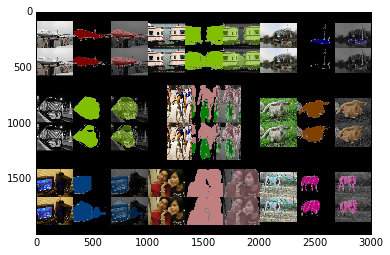






Train epoch=1:  41%|████████▋            | 3503/8498 [11:58<25:13:14, 18.18s/it]




Train epoch=1:  41%|████████▋            | 3504/8498 [11:58<17:43:47, 12.78s/it]




Train epoch=1:  41%|████████▋            | 3505/8498 [11:58<12:28:55,  9.00s/it]




Train epoch=1:  41%|█████████             | 3506/8498 [11:58<8:48:33,  6.35s/it]




Train epoch=1:  41%|█████████             | 3507/8498 [11:58<6:14:14,  4.50s/it]




Train epoch=1:  41%|█████████             | 3508/8498 [11:59<4:26:29,  3.20s/it]




Train epoch=1:  41%|█████████             | 3509/8498 [11:59<3:11:00,  2.30s/it]




Train epoch=1:  41%|█████████             | 3510/8498 [11:59<2:18:14,  1.66s/it]




Train epoch=1:  41%|█████████             | 3511/8498 [11:59<1:41:04,  1.22s/it]




Train epoch=1:  41%|█████████             | 3512/8498 [11:59<1:15:15,  1.10it/s]




Train epoch=1:  41%|█████████▉              | 3513/8498 [11:59<57:10,  1.45it/s]




Train epoch=1:  41%|█████████▉              | 3514/8498 [12:

Train epoch=1:  42%|██████████              | 3585/8498 [12:13<15:44,  5.20it/s]




Train epoch=1:  42%|██████████▏             | 3586/8498 [12:13<15:47,  5.18it/s]




Train epoch=1:  42%|██████████▏             | 3587/8498 [12:13<15:39,  5.23it/s]




Train epoch=1:  42%|██████████▏             | 3588/8498 [12:13<15:30,  5.28it/s]




Train epoch=1:  42%|██████████▏             | 3589/8498 [12:13<15:21,  5.32it/s]




Train epoch=1:  42%|██████████▏             | 3590/8498 [12:13<15:24,  5.31it/s]




Train epoch=1:  42%|██████████▏             | 3591/8498 [12:14<15:22,  5.32it/s]




Train epoch=1:  42%|██████████▏             | 3592/8498 [12:14<15:21,  5.33it/s]




Train epoch=1:  42%|██████████▏             | 3593/8498 [12:14<15:22,  5.32it/s]




Train epoch=1:  42%|██████████▏             | 3594/8498 [12:14<15:19,  5.33it/s]




Train epoch=1:  42%|██████████▏             | 3595/8498 [12:14<15:18,  5.34it/s]




Train epoch=1:  42%|██████████▏             | 3596/8498 [12:15<15

Train epoch=1:  43%|██████████▎             | 3666/8498 [12:28<15:06,  5.33it/s]




Train epoch=1:  43%|██████████▎             | 3667/8498 [12:28<14:46,  5.45it/s]




Train epoch=1:  43%|██████████▎             | 3668/8498 [12:28<15:12,  5.30it/s]




Train epoch=1:  43%|██████████▎             | 3669/8498 [12:28<14:52,  5.41it/s]




Train epoch=1:  43%|██████████▎             | 3670/8498 [12:29<14:51,  5.41it/s]




Train epoch=1:  43%|██████████▎             | 3671/8498 [12:29<14:36,  5.51it/s]




Train epoch=1:  43%|██████████▎             | 3672/8498 [12:29<14:30,  5.54it/s]




Train epoch=1:  43%|██████████▎             | 3673/8498 [12:29<14:41,  5.47it/s]




Train epoch=1:  43%|██████████▍             | 3674/8498 [12:29<14:50,  5.41it/s]




Train epoch=1:  43%|██████████▍             | 3675/8498 [12:29<14:48,  5.43it/s]




Train epoch=1:  43%|██████████▍             | 3676/8498 [12:30<14:51,  5.41it/s]




Train epoch=1:  43%|██████████▍             | 3677/8498 [12:30<14

Train epoch=1:  44%|██████████▌             | 3747/8498 [12:43<14:35,  5.43it/s]




Train epoch=1:  44%|██████████▌             | 3748/8498 [12:43<14:19,  5.53it/s]




Train epoch=1:  44%|██████████▌             | 3749/8498 [12:43<14:21,  5.51it/s]




Train epoch=1:  44%|██████████▌             | 3750/8498 [12:43<14:20,  5.52it/s]




Train epoch=1:  44%|██████████▌             | 3751/8498 [12:44<14:19,  5.52it/s]




Train epoch=1:  44%|██████████▌             | 3752/8498 [12:44<14:25,  5.49it/s]




Train epoch=1:  44%|██████████▌             | 3753/8498 [12:44<14:46,  5.35it/s]




Train epoch=1:  44%|██████████▌             | 3754/8498 [12:44<15:05,  5.24it/s]




Train epoch=1:  44%|██████████▌             | 3755/8498 [12:44<15:18,  5.17it/s]




Train epoch=1:  44%|██████████▌             | 3756/8498 [12:45<14:54,  5.30it/s]




Train epoch=1:  44%|██████████▌             | 3757/8498 [12:45<15:01,  5.26it/s]




Train epoch=1:  44%|██████████▌             | 3758/8498 [12:45<14

Train epoch=1:  45%|██████████▊             | 3828/8498 [12:58<14:46,  5.27it/s]




Train epoch=1:  45%|██████████▊             | 3829/8498 [12:58<15:04,  5.16it/s]




Train epoch=1:  45%|██████████▊             | 3830/8498 [12:58<15:18,  5.08it/s]




Train epoch=1:  45%|██████████▊             | 3831/8498 [12:59<15:03,  5.16it/s]




Train epoch=1:  45%|██████████▊             | 3832/8498 [12:59<15:06,  5.15it/s]




Train epoch=1:  45%|██████████▊             | 3833/8498 [12:59<13:34,  5.73it/s]




Train epoch=1:  45%|██████████▊             | 3834/8498 [12:59<13:40,  5.68it/s]




Train epoch=1:  45%|██████████▊             | 3835/8498 [12:59<14:04,  5.52it/s]




Train epoch=1:  45%|██████████▊             | 3836/8498 [12:59<13:44,  5.65it/s]




Train epoch=1:  45%|██████████▊             | 3837/8498 [13:00<14:05,  5.51it/s]




Train epoch=1:  45%|██████████▊             | 3838/8498 [13:00<15:11,  5.11it/s]




Train epoch=1:  45%|██████████▊             | 3839/8498 [13:00<16

Train epoch=1:  46%|███████████             | 3909/8498 [13:13<14:14,  5.37it/s]




Train epoch=1:  46%|███████████             | 3910/8498 [13:13<14:02,  5.45it/s]




Train epoch=1:  46%|███████████             | 3911/8498 [13:13<14:03,  5.44it/s]




Train epoch=1:  46%|███████████             | 3912/8498 [13:14<13:51,  5.51it/s]




Train epoch=1:  46%|███████████             | 3913/8498 [13:14<13:57,  5.47it/s]




Train epoch=1:  46%|███████████             | 3914/8498 [13:14<13:57,  5.47it/s]




Train epoch=1:  46%|███████████             | 3915/8498 [13:14<14:00,  5.45it/s]




Train epoch=1:  46%|███████████             | 3916/8498 [13:14<14:24,  5.30it/s]




Train epoch=1:  46%|███████████             | 3917/8498 [13:15<14:25,  5.29it/s]




Train epoch=1:  46%|███████████             | 3918/8498 [13:15<14:43,  5.19it/s]




Train epoch=1:  46%|███████████             | 3919/8498 [13:15<14:57,  5.10it/s]




Train epoch=1:  46%|███████████             | 3920/8498 [13:15<15

Train epoch=1:  47%|███████████▎            | 3991/8498 [13:28<14:24,  5.22it/s]




Train epoch=1:  47%|███████████▎            | 3992/8498 [13:29<14:11,  5.29it/s]




Train epoch=1:  47%|███████████▎            | 3993/8498 [13:29<14:04,  5.33it/s]




Train epoch=1:  47%|███████████▎            | 3994/8498 [13:29<14:00,  5.36it/s]




Train epoch=1:  47%|███████████▎            | 3995/8498 [13:29<13:59,  5.36it/s]




Train epoch=1:  47%|███████████▎            | 3996/8498 [13:29<14:18,  5.24it/s]




Train epoch=1:  47%|███████████▎            | 3997/8498 [13:30<14:16,  5.26it/s]




Train epoch=1:  47%|███████████▎            | 3998/8498 [13:30<14:08,  5.30it/s]




Train epoch=1:  47%|███████████▎            | 3999/8498 [13:30<13:59,  5.36it/s]




Train epoch=1:  47%|███████████▎            | 4000/8498 [13:30<14:02,  5.34it/s]




Train epoch=1:  47%|███████████▎            | 4001/8498 [13:30<14:14,  5.26it/s]




Train epoch=1:  47%|███████████▎            | 4002/8498 [13:31<14

Train epoch=1:  48%|███████████▌            | 4072/8498 [13:44<13:30,  5.46it/s]




Train epoch=1:  48%|███████████▌            | 4073/8498 [13:44<13:38,  5.41it/s]




Train epoch=1:  48%|███████████▌            | 4074/8498 [13:44<13:30,  5.46it/s]




Train epoch=1:  48%|███████████▌            | 4075/8498 [13:44<13:29,  5.47it/s]




Train epoch=1:  48%|███████████▌            | 4076/8498 [13:44<13:52,  5.31it/s]




Train epoch=1:  48%|███████████▌            | 4077/8498 [13:45<14:11,  5.19it/s]




Train epoch=1:  48%|███████████▌            | 4078/8498 [13:45<14:07,  5.22it/s]




Train epoch=1:  48%|███████████▌            | 4079/8498 [13:45<14:01,  5.25it/s]




Train epoch=1:  48%|███████████▌            | 4080/8498 [13:45<13:48,  5.33it/s]




Train epoch=1:  48%|███████████▌            | 4081/8498 [13:45<13:46,  5.34it/s]




Train epoch=1:  48%|███████████▌            | 4082/8498 [13:46<12:44,  5.78it/s]




Train epoch=1:  48%|███████████▌            | 4083/8498 [13:46<12

Train epoch=1:  49%|███████████▋            | 4154/8498 [13:59<14:38,  4.94it/s]




Train epoch=1:  49%|███████████▋            | 4155/8498 [13:59<14:24,  5.02it/s]




Train epoch=1:  49%|███████████▋            | 4156/8498 [14:00<14:09,  5.11it/s]




Train epoch=1:  49%|███████████▋            | 4157/8498 [14:00<13:52,  5.22it/s]




Train epoch=1:  49%|███████████▋            | 4158/8498 [14:00<13:42,  5.27it/s]




Train epoch=1:  49%|███████████▋            | 4159/8498 [14:00<13:24,  5.40it/s]




Train epoch=1:  49%|███████████▋            | 4160/8498 [14:00<13:13,  5.47it/s]




Train epoch=1:  49%|███████████▊            | 4161/8498 [14:00<13:17,  5.44it/s]




Train epoch=1:  49%|███████████▊            | 4162/8498 [14:01<13:20,  5.41it/s]




Train epoch=1:  49%|███████████▊            | 4163/8498 [14:01<13:28,  5.36it/s]




Train epoch=1:  49%|███████████▊            | 4164/8498 [14:01<13:49,  5.23it/s]




Train epoch=1:  49%|███████████▊            | 4165/8498 [14:01<14

Train epoch=1:  50%|███████████▉            | 4235/8498 [14:14<13:04,  5.43it/s]




Train epoch=1:  50%|███████████▉            | 4236/8498 [14:14<13:23,  5.30it/s]




Train epoch=1:  50%|███████████▉            | 4237/8498 [14:15<13:38,  5.21it/s]




Train epoch=1:  50%|███████████▉            | 4238/8498 [14:15<13:43,  5.17it/s]




Train epoch=1:  50%|███████████▉            | 4239/8498 [14:15<13:41,  5.19it/s]




Train epoch=1:  50%|███████████▉            | 4240/8498 [14:15<13:34,  5.22it/s]




Train epoch=1:  50%|███████████▉            | 4241/8498 [14:15<13:21,  5.31it/s]




Train epoch=1:  50%|███████████▉            | 4242/8498 [14:16<13:01,  5.45it/s]




Train epoch=1:  50%|███████████▉            | 4243/8498 [14:16<12:49,  5.53it/s]




Train epoch=1:  50%|███████████▉            | 4244/8498 [14:16<12:58,  5.46it/s]




Train epoch=1:  50%|███████████▉            | 4245/8498 [14:16<13:04,  5.42it/s]




Train epoch=1:  50%|███████████▉            | 4246/8498 [14:16<13

Train epoch=1:  51%|████████████▏           | 4316/8498 [14:29<13:17,  5.25it/s]




Train epoch=1:  51%|████████████▏           | 4317/8498 [14:29<13:00,  5.36it/s]




Train epoch=1:  51%|████████████▏           | 4318/8498 [14:30<12:59,  5.36it/s]




Train epoch=1:  51%|████████████▏           | 4319/8498 [14:30<12:54,  5.39it/s]




Train epoch=1:  51%|████████████▏           | 4320/8498 [14:30<12:54,  5.40it/s]




Train epoch=1:  51%|████████████▏           | 4321/8498 [14:30<12:18,  5.65it/s]




Train epoch=1:  51%|████████████▏           | 4322/8498 [14:30<12:17,  5.66it/s]




Train epoch=1:  51%|████████████▏           | 4323/8498 [14:31<12:46,  5.45it/s]




Train epoch=1:  51%|████████████▏           | 4324/8498 [14:31<13:07,  5.30it/s]




Train epoch=1:  51%|████████████▏           | 4325/8498 [14:31<13:14,  5.26it/s]




Train epoch=1:  51%|████████████▏           | 4326/8498 [14:31<13:09,  5.28it/s]




Train epoch=1:  51%|████████████▏           | 4327/8498 [14:31<13

Train epoch=1:  52%|████████████▍           | 4398/8498 [14:45<13:13,  5.17it/s]




Train epoch=1:  52%|████████████▍           | 4399/8498 [14:45<12:55,  5.29it/s]




Train epoch=1:  52%|████████████▍           | 4400/8498 [14:45<12:39,  5.40it/s]




Train epoch=1:  52%|████████████▍           | 4401/8498 [14:45<12:25,  5.49it/s]




Train epoch=1:  52%|████████████▍           | 4402/8498 [14:45<12:11,  5.60it/s]




Train epoch=1:  52%|████████████▍           | 4403/8498 [14:46<12:24,  5.50it/s]




Train epoch=1:  52%|████████████▍           | 4404/8498 [14:46<12:31,  5.45it/s]




Train epoch=1:  52%|████████████▍           | 4405/8498 [14:46<12:55,  5.28it/s]




Train epoch=1:  52%|████████████▍           | 4406/8498 [14:46<12:55,  5.27it/s]




Train epoch=1:  52%|████████████▍           | 4407/8498 [14:46<13:31,  5.04it/s]




Train epoch=1:  52%|████████████▍           | 4408/8498 [14:47<13:29,  5.05it/s]




Train epoch=1:  52%|████████████▍           | 4409/8498 [14:47<13

Train epoch=1:  53%|████████████▋           | 4479/8498 [15:00<12:59,  5.16it/s]




Train epoch=1:  53%|████████████▋           | 4480/8498 [15:00<12:46,  5.25it/s]




Train epoch=1:  53%|████████████▋           | 4481/8498 [15:00<12:42,  5.27it/s]




Train epoch=1:  53%|████████████▋           | 4482/8498 [15:00<12:38,  5.30it/s]




Train epoch=1:  53%|████████████▋           | 4483/8498 [15:01<12:25,  5.38it/s]




Train epoch=1:  53%|████████████▋           | 4484/8498 [15:01<12:27,  5.37it/s]




Train epoch=1:  53%|████████████▋           | 4485/8498 [15:01<12:51,  5.20it/s]




Train epoch=1:  53%|████████████▋           | 4486/8498 [15:01<12:38,  5.29it/s]




Train epoch=1:  53%|████████████▋           | 4487/8498 [15:01<12:35,  5.31it/s]




Train epoch=1:  53%|████████████▋           | 4488/8498 [15:01<12:35,  5.30it/s]




Train epoch=1:  53%|████████████▋           | 4489/8498 [15:02<12:53,  5.18it/s]




Train epoch=1:  53%|████████████▋           | 4490/8498 [15:02<12

Train epoch=1:  54%|████████████▉           | 4560/8498 [15:15<12:46,  5.14it/s]




Train epoch=1:  54%|████████████▉           | 4561/8498 [15:15<12:36,  5.21it/s]




Train epoch=1:  54%|████████████▉           | 4562/8498 [15:15<12:23,  5.29it/s]




Train epoch=1:  54%|████████████▉           | 4563/8498 [15:16<12:19,  5.32it/s]




Train epoch=1:  54%|████████████▉           | 4564/8498 [15:16<12:12,  5.37it/s]




Train epoch=1:  54%|████████████▉           | 4565/8498 [15:16<12:11,  5.38it/s]




Train epoch=1:  54%|████████████▉           | 4566/8498 [15:16<12:15,  5.34it/s]




Train epoch=1:  54%|████████████▉           | 4567/8498 [15:16<12:19,  5.32it/s]




Train epoch=1:  54%|████████████▉           | 4568/8498 [15:16<12:36,  5.19it/s]




Train epoch=1:  54%|████████████▉           | 4569/8498 [15:17<12:26,  5.26it/s]




Train epoch=1:  54%|████████████▉           | 4570/8498 [15:17<12:39,  5.17it/s]




Train epoch=1:  54%|████████████▉           | 4571/8498 [15:17<12

Train epoch=1:  55%|█████████████           | 4641/8498 [15:30<11:44,  5.47it/s]




Train epoch=1:  55%|█████████████           | 4642/8498 [15:31<11:38,  5.52it/s]




Train epoch=1:  55%|█████████████           | 4643/8498 [15:31<11:59,  5.36it/s]




Train epoch=1:  55%|█████████████           | 4644/8498 [15:31<12:05,  5.31it/s]




Train epoch=1:  55%|█████████████           | 4645/8498 [15:31<12:07,  5.29it/s]




Train epoch=1:  55%|█████████████           | 4646/8498 [15:31<12:22,  5.19it/s]




Train epoch=1:  55%|█████████████           | 4647/8498 [15:32<12:20,  5.20it/s]




Train epoch=1:  55%|█████████████▏          | 4648/8498 [15:32<12:29,  5.14it/s]




Train epoch=1:  55%|█████████████▏          | 4649/8498 [15:32<12:40,  5.06it/s]




Train epoch=1:  55%|█████████████▏          | 4650/8498 [15:32<12:16,  5.22it/s]




Train epoch=1:  55%|█████████████▏          | 4651/8498 [15:32<12:28,  5.14it/s]




Train epoch=1:  55%|█████████████▏          | 4652/8498 [15:33<12

Train epoch=1:  56%|█████████████▎          | 4722/8498 [15:46<11:14,  5.60it/s]




Train epoch=1:  56%|█████████████▎          | 4723/8498 [15:46<11:40,  5.39it/s]




Train epoch=1:  56%|█████████████▎          | 4724/8498 [15:46<11:42,  5.37it/s]




Train epoch=1:  56%|█████████████▎          | 4725/8498 [15:46<11:19,  5.55it/s]




Train epoch=1:  56%|█████████████▎          | 4726/8498 [15:46<11:29,  5.47it/s]




Train epoch=1:  56%|█████████████▎          | 4727/8498 [15:47<11:47,  5.33it/s]




Train epoch=1:  56%|█████████████▎          | 4728/8498 [15:47<11:50,  5.31it/s]




Train epoch=1:  56%|█████████████▎          | 4729/8498 [15:47<11:59,  5.24it/s]




Train epoch=1:  56%|█████████████▎          | 4730/8498 [15:47<11:29,  5.46it/s]




Train epoch=1:  56%|█████████████▎          | 4731/8498 [15:47<11:40,  5.38it/s]




Train epoch=1:  56%|█████████████▎          | 4732/8498 [15:48<11:52,  5.29it/s]




Train epoch=1:  56%|█████████████▎          | 4733/8498 [15:48<11

Train epoch=1:  57%|█████████████▌          | 4803/8498 [16:01<11:09,  5.52it/s]




Train epoch=1:  57%|█████████████▌          | 4804/8498 [16:01<11:04,  5.56it/s]




Train epoch=1:  57%|█████████████▌          | 4805/8498 [16:01<11:01,  5.58it/s]




Train epoch=1:  57%|█████████████▌          | 4806/8498 [16:01<11:07,  5.54it/s]




Train epoch=1:  57%|█████████████▌          | 4807/8498 [16:02<11:12,  5.49it/s]




Train epoch=1:  57%|█████████████▌          | 4808/8498 [16:02<11:07,  5.53it/s]




Train epoch=1:  57%|█████████████▌          | 4809/8498 [16:02<11:13,  5.47it/s]




Train epoch=1:  57%|█████████████▌          | 4810/8498 [16:02<11:34,  5.31it/s]




Train epoch=1:  57%|█████████████▌          | 4811/8498 [16:02<11:36,  5.29it/s]




Train epoch=1:  57%|█████████████▌          | 4812/8498 [16:02<11:32,  5.33it/s]




Train epoch=1:  57%|█████████████▌          | 4813/8498 [16:03<11:46,  5.21it/s]




Train epoch=1:  57%|█████████████▌          | 4814/8498 [16:03<11

Train epoch=1:  57%|█████████████▊          | 4884/8498 [16:16<11:20,  5.31it/s]




Train epoch=1:  57%|█████████████▊          | 4885/8498 [16:16<11:12,  5.37it/s]




Train epoch=1:  57%|█████████████▊          | 4886/8498 [16:16<11:07,  5.41it/s]




Train epoch=1:  58%|█████████████▊          | 4887/8498 [16:16<11:07,  5.41it/s]




Train epoch=1:  58%|█████████████▊          | 4888/8498 [16:17<11:21,  5.30it/s]




Train epoch=1:  58%|█████████████▊          | 4889/8498 [16:17<11:38,  5.17it/s]




Train epoch=1:  58%|█████████████▊          | 4890/8498 [16:17<11:43,  5.13it/s]




Train epoch=1:  58%|█████████████▊          | 4891/8498 [16:17<11:52,  5.07it/s]




Train epoch=1:  58%|█████████████▊          | 4892/8498 [16:17<11:59,  5.01it/s]




Train epoch=1:  58%|█████████████▊          | 4893/8498 [16:18<12:01,  5.00it/s]




Train epoch=1:  58%|█████████████▊          | 4894/8498 [16:18<11:59,  5.01it/s]




Train epoch=1:  58%|█████████████▊          | 4895/8498 [16:18<11

Train epoch=1:  58%|██████████████          | 4965/8498 [16:31<10:41,  5.50it/s]




Train epoch=1:  58%|██████████████          | 4966/8498 [16:31<11:00,  5.35it/s]




Train epoch=1:  58%|██████████████          | 4967/8498 [16:31<11:05,  5.30it/s]




Train epoch=1:  58%|██████████████          | 4968/8498 [16:32<10:52,  5.41it/s]




Train epoch=1:  58%|██████████████          | 4969/8498 [16:32<10:55,  5.39it/s]




Train epoch=1:  58%|██████████████          | 4970/8498 [16:32<11:02,  5.33it/s]




Train epoch=1:  58%|██████████████          | 4971/8498 [16:32<11:43,  5.01it/s]




Train epoch=1:  59%|██████████████          | 4972/8498 [16:32<11:35,  5.07it/s]




Train epoch=1:  59%|██████████████          | 4973/8498 [16:33<11:25,  5.14it/s]




Train epoch=1:  59%|██████████████          | 4974/8498 [16:33<11:34,  5.08it/s]




Train epoch=1:  59%|██████████████          | 4975/8498 [16:33<11:33,  5.08it/s]




Train epoch=1:  59%|██████████████          | 4976/8498 [16:33<10

Train epoch=1:  59%|██████████████▎         | 5046/8498 [16:46<10:30,  5.47it/s]




Train epoch=1:  59%|██████████████▎         | 5047/8498 [16:47<10:29,  5.48it/s]




Train epoch=1:  59%|██████████████▎         | 5048/8498 [16:47<10:49,  5.31it/s]




Train epoch=1:  59%|██████████████▎         | 5049/8498 [16:47<10:40,  5.38it/s]




Train epoch=1:  59%|██████████████▎         | 5050/8498 [16:47<10:50,  5.30it/s]




Train epoch=1:  59%|██████████████▎         | 5051/8498 [16:47<10:55,  5.26it/s]




Train epoch=1:  59%|██████████████▎         | 5052/8498 [16:48<11:04,  5.18it/s]




Train epoch=1:  59%|██████████████▎         | 5053/8498 [16:48<11:10,  5.14it/s]




Train epoch=1:  59%|██████████████▎         | 5054/8498 [16:48<11:10,  5.13it/s]




Train epoch=1:  59%|██████████████▎         | 5055/8498 [16:48<10:57,  5.24it/s]




Train epoch=1:  59%|██████████████▎         | 5056/8498 [16:48<11:10,  5.13it/s]




Train epoch=1:  60%|██████████████▎         | 5057/8498 [16:48<11

Train epoch=1:  60%|██████████████▍         | 5127/8498 [17:02<10:03,  5.59it/s]




Train epoch=1:  60%|██████████████▍         | 5128/8498 [17:02<09:54,  5.67it/s]




Train epoch=1:  60%|██████████████▍         | 5129/8498 [17:02<10:04,  5.58it/s]




Train epoch=1:  60%|██████████████▍         | 5130/8498 [17:02<09:28,  5.92it/s]




Train epoch=1:  60%|██████████████▍         | 5131/8498 [17:02<09:47,  5.73it/s]




Train epoch=1:  60%|██████████████▍         | 5132/8498 [17:03<09:34,  5.86it/s]




Train epoch=1:  60%|██████████████▍         | 5133/8498 [17:03<10:06,  5.55it/s]




Train epoch=1:  60%|██████████████▍         | 5134/8498 [17:03<10:26,  5.37it/s]




Train epoch=1:  60%|██████████████▌         | 5135/8498 [17:03<10:34,  5.30it/s]




Train epoch=1:  60%|██████████████▌         | 5136/8498 [17:03<10:42,  5.24it/s]




Train epoch=1:  60%|██████████████▌         | 5137/8498 [17:04<10:32,  5.32it/s]




Train epoch=1:  60%|██████████████▌         | 5138/8498 [17:04<10

In [ ]:
trainer.epoch = start_epoch
trainer.iteration = start_iteration
trainer.train()